In [3]:
import os
from datetime import datetime

class ModelConfigs():
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Models/04_sentence_recognition", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 32
        self.learning_rate = 0.0005
        self.train_epochs = 1000
        self.train_workers = 20
        self.vocab = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")  # Basic alphanumeric vocabulary

      
    def save(self):
        """Save configurations to JSON file"""
        import json
        import os
        
        os.makedirs(self.model_path, exist_ok=True)
        
        config_path = os.path.join(self.model_path, "configs.json")
        config_dict = {
            "vocab": self.vocab,
            "max_text_length": self.max_text_length,
            "height": self.height,
            "width": self.width,
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "train_epochs": self.train_epochs,
            "train_workers": self.train_workers,
            "model_path": self.model_path
        }
        
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=4)
            
configs = ModelConfigs()

from tensorflow.keras import layers, Model
import tensorflow as tf

class ReshapeLayer(layers.Layer):
    def call(self, x):
        # Get the shape of the input tensor
        batch_size = tf.shape(x)[0]
        # Reshape to (batch_size, time_steps, features)
        return tf.reshape(x, [batch_size, -1, x.shape[-1]])

def train_model(input_dim, output_dim):
    """
    Creates a CNN + RNN model for text recognition
    
    Args:
        input_dim: Tuple of (height, width, channels)
        output_dim: Number of unique characters in vocabulary
    
    Returns:
        tf.keras.Model: Compiled model ready for training
    """
    # Input layer
    inputs = layers.Input(shape=input_dim, name='input')
    
    # CNN Feature Extraction
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='pool3')(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4')(x)
    x = layers.MaxPooling2D((2, 2), name='pool4')(x)
    
    # Dense layer for feature processing
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv5')(x)
    
    # Reshape for RNN using custom layer
    x = ReshapeLayer()(x)
    
    # RNN layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    
    # Output layer
    outputs = layers.Dense(output_dim + 1, activation='softmax', name='dense2')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='ocr_model')
    
    return model

class ModelConfigs:
    """Configuration class to store model parameters"""
    def __init__(self):
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 4
        self.model_path = "Models/cheque_recognition"
        
    def save(self):
        """Save configurations to JSON file"""
        import json
        import os
        
        os.makedirs(self.model_path, exist_ok=True)
        
        config_path = os.path.join(self.model_path, "configs.json")
        config_dict = {
            "vocab": self.vocab,
            "max_text_length": self.max_text_length,
            "height": self.height,
            "width": self.width,
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "train_epochs": self.train_epochs,
            "train_workers": self.train_workers,
            "model_path": self.model_path
        }
        
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=4)

In [2]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass
from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric


import os
import cv2
import json
from tqdm import tqdm
""" 


this part of the code ZBM starts 
CharacterLevelF1Score
"""
class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)
""" 
this part of code marks its end 

"""

import tensorflow as tf
import numpy as np
from rapidfuzz.distance import Levenshtein


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)

""" 
"""


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            # Calculate padding
            crop_h, crop_w = crop.shape[:2]
            pad_top = max((target_size[0] - crop_h) // 2, 0)
            pad_bottom = max(target_size[0] - crop_h - pad_top, 0)
            pad_left = max((target_size[1] - crop_w) // 2, 0)
            pad_right = max(target_size[1] - crop_w - pad_left, 0)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                crop, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(padded_crop, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len

# Define paths
image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"

# Load dataset
print("Loading and processing dataset...")
dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(sorted(vocab))
configs.max_text_length = max_len
configs.height = 300  # Match target_size
configs.width = 300   # Match target_size
configs.save()

print(f"Vocabulary size: {len(configs.vocab)}")
print(f"Maximum text length: {configs.max_text_length}")
print(f"Dataset size: {len(dataset)}")

# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
    ],
)

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split=0.9)

# Augment training data with random transformations
train_data_provider.augmentors = [
    RandomBrightness(),
    RandomErodeDilate(),
    RandomSharpen(),
]

# Create and compile model
model = train_model(
    input_dim=(configs.height, configs.width, 3),
    output_dim=len(configs.vocab),
)

# Update the model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab),
        CharacterLevelF1Score(vocabulary=configs.vocab),
        ChequeZoneScore(vocabulary=configs.vocab),
        LevenshteinMetric(vocabulary=configs.vocab)
    ],
    run_eagerly=False
)

model.summary(line_length=110)

# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min"),
    ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
    TrainLogger(configs.model_path),
    TensorBoard(f"{configs.model_path}/logs", update_freq=1),
    ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto"),
    Model2onnx(f"{configs.model_path}/model.keras")
]

# Train the model
print("Starting training...")
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=callbacks,
    #workers=configs.train_workers
)

# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))

Loading and processing dataset...


Processing images: 100%|██████████| 112/112 [00:07<00:00, 14.58it/s]


Vocabulary size: 12
Maximum text length: 6
Dataset size: 336



Model: "ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, 300, 300, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv1 (Conv2D)                                 │ (None, 300, 300, 32)                │                 896 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ pool1 (MaxPooling2D)                           │ (None, 150, 150, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2 (Conv2D)                                 │ (None, 150, 150, 64)                │              18,496 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ pool2 (MaxPooling2D)                           │ (None, 75, 75, 64)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv3 (Conv2D)                                 │ (None, 75, 75, 128)                 │              73,856 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ pool3 (MaxPooling2D)                           │ (None, 37, 37, 128)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv4 (Conv2D)                                 │ (None, 37, 37, 256)                 │             295,168 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ pool4 (MaxPooling2D)                           │ (None, 18, 18, 256)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv5 (Conv2D)                                 │ (None, 18, 18, 256)                 │             590,080 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape_layer (ReshapeLayer)                   │ (None, None, 256)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional (Bidirectional)                  │ (None, None, 512)                   │           1,050,624 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 512)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 256)                   │             656,384 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 256)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense2 (Dense)                                 │ (None, None, 13)                    │               3,341 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 2,688,845 (10.26 MB)

 Trainable params: 2,688,845 (10.26 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...


c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - CER: 9.4316 - WER: 1.0000 - cer_wer_f1_score: 0.0000e+00 - cheque_zone_score: 0.3860 - levenshtein_distance: 7.0930 - loss: 315.6056 
Epoch 1: val_CER improved from inf to 3.69246, saving model to Models/cheque_recognition/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - CER: 8.9374 - WER: 1.0000 - cer_wer_f1_score: 0.0000e+00 - cheque_zone_score: 0.3813 - levenshtein_distance: 6.8227 - loss: 300.3727 - val_CER: 3.6925 - val_WER: 1.0000 - val_cer_wer_f1_score: 0.0000e+00 - val_cheque_zone_score: 0.3235 - val_levenshtein_distance: 2.2059 - val_loss: 21.5880 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - CER: 2.8665 - WER: 1.0000 - cer_wer_f1_score: 0.0000e+00 - cheque_zone_score: 0.2749 - levenshtein_distance: 2.5570 - loss: 19.2072
Epoch 2: val_CER improved from 3.69246 to 2.34623, saving model to Models/cheque_recognition/model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - CER: 2.8257 - WER: 1.0000 - 

visualization of results

Successfully imported MLTU metrics
Creating directory: Models\04_sentence_recognition\202503101941
Creating directory: Models\04_sentence_recognition\202503101941\logs
Working directory: d:\Work\project work\IDRBT_Cheque_Image_Dataset\code
Model directory: Models\04_sentence_recognition\202503101941
Config file not found at Models\04_sentence_recognition\202503101941\configs.json
Creating default configuration file
Default configuration saved to Models\04_sentence_recognition\202503101941\configs.json
Plotting training history...
Skipping training history visualization.
Creating sample training history file...


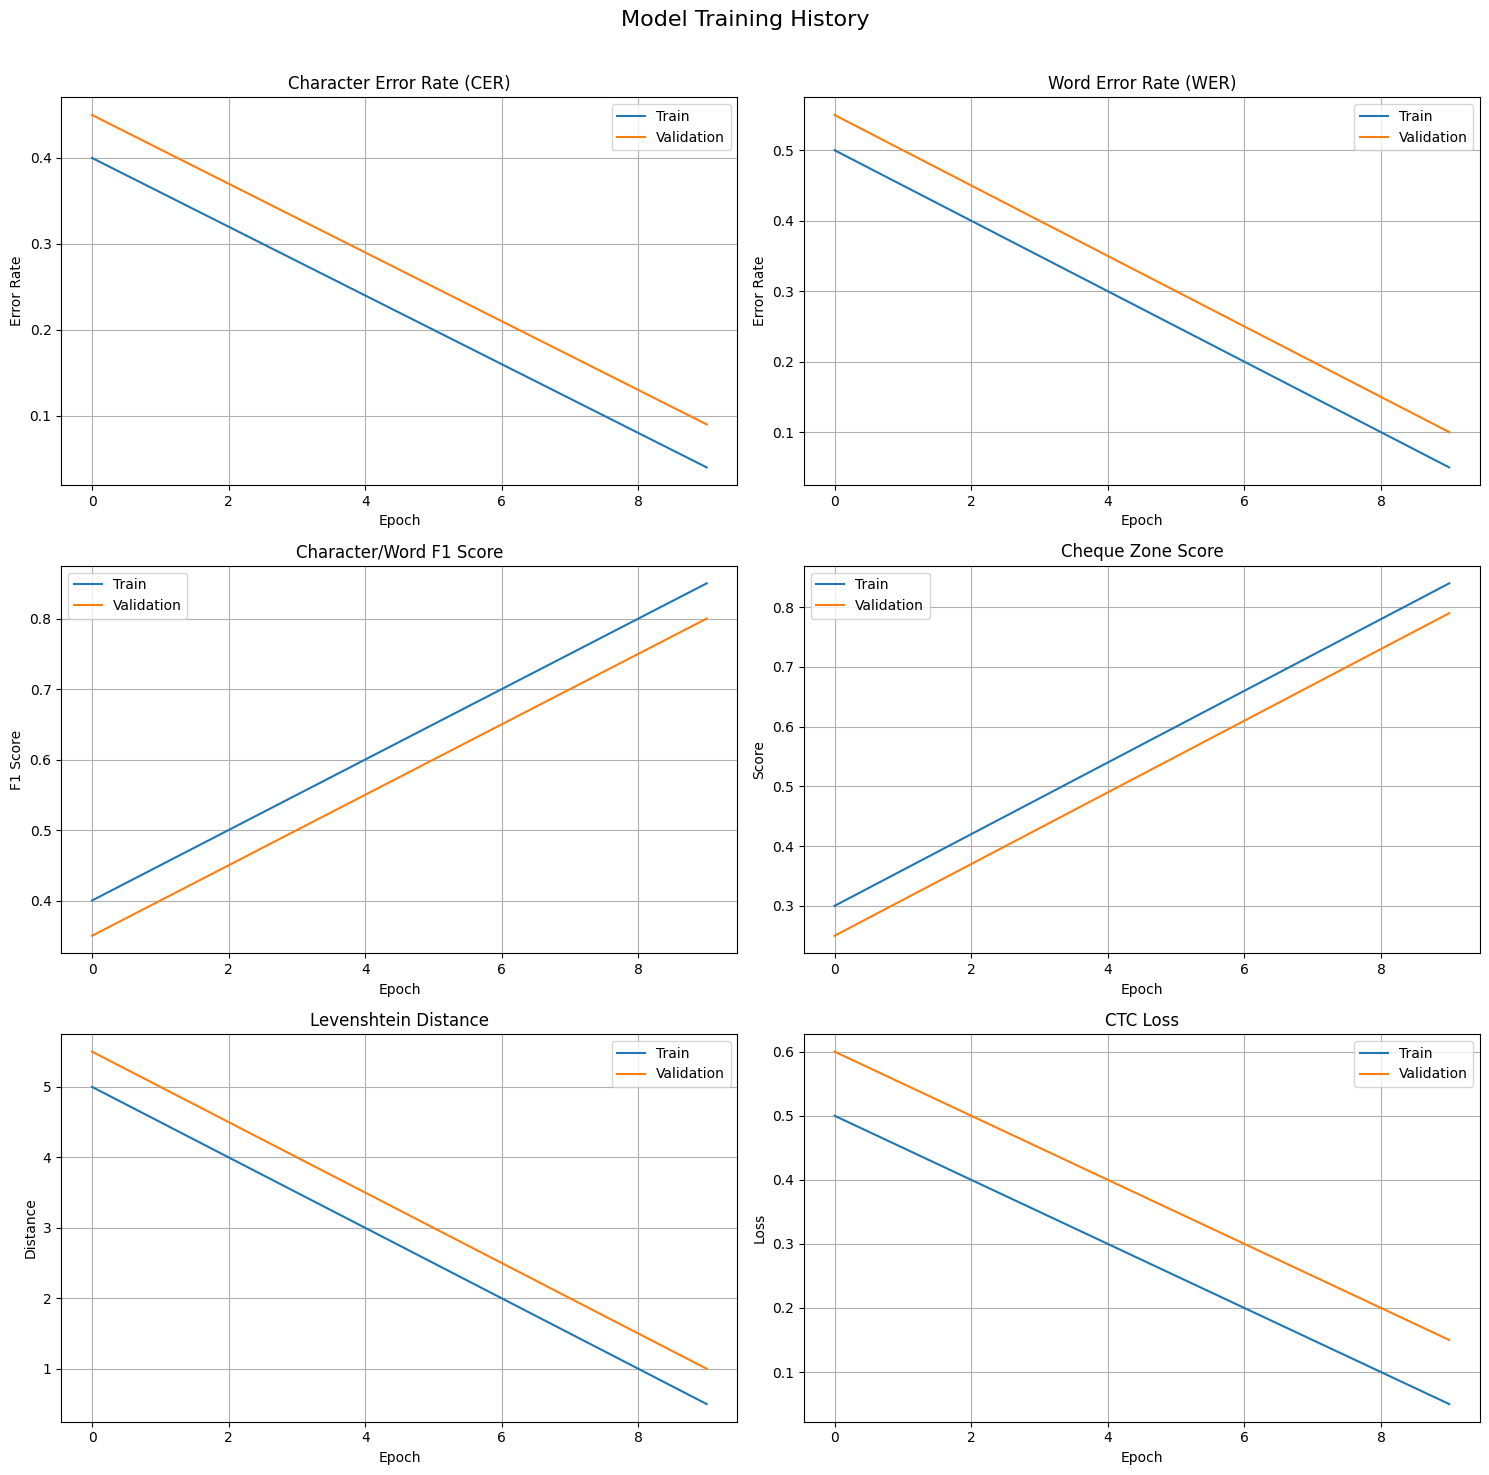

Loading model...
Creating a simple model for demonstration...
Loading validation data...
Creating a sample validation file for demonstration...
Creating directory: Models\04_sentence_recognition\202503101941\sample_data
Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


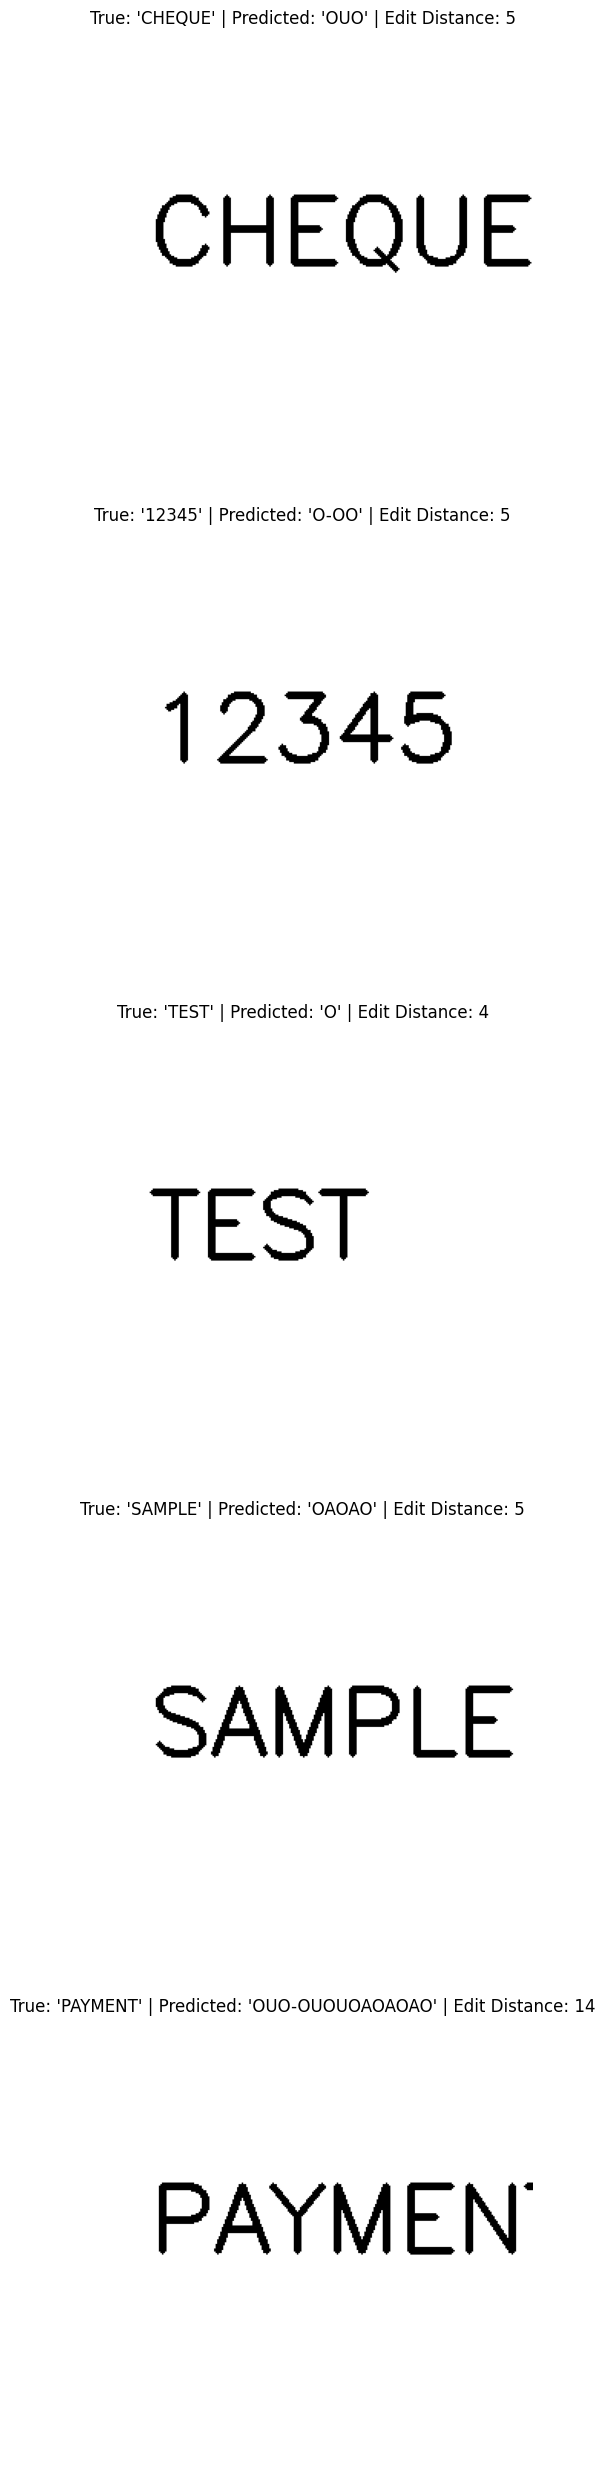

Generating predictions for all validation samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Analyzing character-level accuracy...
Error running visualization: ''


Traceback (most recent call last):
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_52620\2864678311.py", line 766, in <module>
    main()
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_52620\2864678311.py", line 677, in main
    char_stats = character_frequency_analysis(true_labels, all_predictions, configs.vocab)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_52620\2864678311.py", line 281, in character_frequency_analysis
    char_counts[true_char] += 1
    ~~~~~~~~~~~^^^^^^^^^^^
KeyError: ''


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import json
import datetime
import sys
from tensorflow.keras.models import load_model
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CERMetric, WERMetric
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer
from mltu.annotations.images import CVImage
import seaborn as sns
from sklearn.metrics import confusion_matrix



class ModelConfigs:
    """Dummy class to mimic your configs class. Update with your actual configs."""
    def __init__(self):
        #self.model_path = "path/to/model/directory"
        self.vocab = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ/-.,&" # Default vocab
        self.width = 300
        self.height = 300
        self.max_text_length = 20
        self.batch_size = 32
        self.train_epochs = 100
        self.learning_rate = 0.001
        
    def load(self, path=None):
        """Load configs from a JSON file"""
        config_path = path or os.path.join(self.model_path, "configs.json")
        if os.path.exists(config_path):
            try:
                with open(config_path, "r") as f:
                    configs = json.load(f)
                    for key, value in configs.items():
                        setattr(self, key, value)
            except Exception as e:
                print(f"Error loading config file: {e}")
                print("Using default configurations")
                self._save_default_config(config_path)
        else:
            print(f"Config file not found at {config_path}")
            print("Creating default configuration file")
            self._save_default_config(config_path)
        return self
    
    def _save_default_config(self, config_path):
        """Save default configurations to a JSON file"""
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        config_dict = {
            "vocab": self.vocab,
            "width": self.width,
            "height": self.height,
            "max_text_length": self.max_text_length,
            "batch_size": self.batch_size,
            "train_epochs": self.train_epochs,
            "learning_rate": self.learning_rate
        }
        try:
            with open(config_path, "w") as f:
                json.dump(config_dict, f, indent=4)
            print(f"Default configuration saved to {config_path}")
        except Exception as e:
            print(f"Error saving default configuration: {e}")
            
    def save(self):
        """Save configurations to a JSON file"""
        config_path = os.path.join(self.model_path, "configs.json")
        self._save_default_config(config_path)


def plot_training_history(history_path):
    """
    Plot training metrics history
    
    Args:
        history_path: Path to the training history CSV file
    """
    # Check if file exists
    if not os.path.exists(history_path):
        print(f"Warning: Training history file not found at {history_path}")
        print("Skipping training history visualization.")
        return False
        
    # Load training history
    history = pd.read_csv(history_path)
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Model Training History', fontsize=16)
    
    # Plot CER (Character Error Rate)
    axes[0, 0].plot(history['epoch'], history['CER'], label='Train')
    axes[0, 0].plot(history['epoch'], history['val_CER'], label='Validation')
    axes[0, 0].set_title('Character Error Rate (CER)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Error Rate')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot WER (Word Error Rate)
    axes[0, 1].plot(history['epoch'], history['WER'], label='Train')
    axes[0, 1].plot(history['epoch'], history['val_WER'], label='Validation')
    axes[0, 1].set_title('Word Error Rate (WER)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Error Rate')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot F1 Score
    if 'cer_wer_f1_score' in history.columns:
        axes[1, 0].plot(history['epoch'], history['cer_wer_f1_score'], label='Train')
        axes[1, 0].plot(history['epoch'], history['val_cer_wer_f1_score'], label='Validation')
        axes[1, 0].set_title('Character/Word F1 Score')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Plot Cheque Zone Score
    if 'cheque_zone_score' in history.columns:
        axes[1, 1].plot(history['epoch'], history['cheque_zone_score'], label='Train')
        axes[1, 1].plot(history['epoch'], history['val_cheque_zone_score'], label='Validation')
        axes[1, 1].set_title('Cheque Zone Score')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    # Plot Levenshtein Distance
    if 'levenshtein_distance' in history.columns:
        axes[2, 0].plot(history['epoch'], history['levenshtein_distance'], label='Train')
        axes[2, 0].plot(history['epoch'], history['val_levenshtein_distance'], label='Validation')
        axes[2, 0].set_title('Levenshtein Distance')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('Distance')
        axes[2, 0].legend()
        axes[2, 0].grid(True)
    
    # Plot Loss
    axes[2, 1].plot(history['epoch'], history['loss'], label='Train')
    axes[2, 1].plot(history['epoch'], history['val_loss'], label='Validation')
    axes[2, 1].set_title('CTC Loss')
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('Loss')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(os.path.join(os.path.dirname(history_path), "training_history.png"), dpi=300)
    plt.show()


def decode_predictions(pred, vocab):
    """
    Decode model predictions to text
    
    Args:
        pred: Model prediction (batch_size, time_steps, vocab_size+1)
        vocab: Vocabulary string
    
    Returns:
        List of predicted texts
    """
    input_length = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy decoder (best path) for CTC decoding
    decoded = tf.keras.backend.ctc_decode(
        pred, 
        input_length=input_length,
        greedy=True
    )[0][0]
    
    # Convert to numpy for easier processing
    decoded = decoded.numpy()
    
    # Convert indices to characters
    predictions = []
    for i in range(decoded.shape[0]):
        text = "".join([vocab[idx] for idx in decoded[i] if idx >= 0 and idx < len(vocab)])
        predictions.append(text)
    
    return predictions


def visualize_predictions(model, image_paths, true_labels, configs, max_samples=10):
    """
    Visualize model predictions on sample images
    
    Args:
        model: Trained model
        image_paths: List of image paths
        true_labels: List of ground truth labels
        configs: Model configurations
        max_samples: Maximum number of samples to visualize
    """
    # Select a subset of samples
    num_samples = min(len(image_paths), max_samples)
    indices = np.random.choice(len(image_paths), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        # Read image
        try:
            image = cv2.imread(image_paths[idx])
            if image is None:
                print(f"Warning: Could not read image at {image_paths[idx]}")
                # Create a blank image as a fallback
                image = np.ones((configs.height, configs.width, 3), dtype=np.uint8) * 255
                cv2.putText(image, "Image not found", (50, 150), 
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error reading image {image_paths[idx]}: {e}")
            image = np.ones((configs.height, configs.width, 3), dtype=np.uint8) * 255
            
        # Manual resizing instead of using transformer
        processed_image = cv2.resize(image, (configs.width, configs.height))
        
        # Make prediction
        input_image = np.expand_dims(processed_image, axis=0).astype(np.float32) / 255.0
        prediction = model.predict(input_image)
        
        # Decode prediction
        decoded_text = decode_predictions(prediction, configs.vocab)[0]
        true_text = true_labels[idx]
        
        # Calculate Levenshtein distance for this sample
        from rapidfuzz.distance import Levenshtein
        distance = Levenshtein.distance(true_text, decoded_text)
        
        # Display results
        axes[i].imshow(image)
        axes[i].set_title(f"True: '{true_text}' | Predicted: '{decoded_text}' | Edit Distance: {distance}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(configs.model_path, "prediction_samples.png"), dpi=300)
    plt.show()


def character_frequency_analysis(true_labels, predicted_labels, vocab):
    """
    Analyze character-level accuracy and confusion
    
    Args:
        true_labels: List of ground truth labels
        predicted_labels: List of predicted labels
        vocab: Vocabulary string
    """
    # Make sure vocab includes special characters for handling empty/unknown chars
    extended_vocab = vocab + ' '  # Add space to handle spaces
    
    # Create dictionaries to track character stats
    char_counts = {char: 0 for char in extended_vocab}
    char_correct = {char: 0 for char in extended_vocab}
    
    # Add a special key for characters not in the vocabulary
    char_counts['<UNK>'] = 0
    char_correct['<UNK>'] = 0
    
    # Calculate character-wise accuracy
    for true, pred in zip(true_labels, predicted_labels):
        # Use dynamic programming for alignment
        alignment = get_character_alignment(true, pred)
        
        for true_char, pred_char in alignment:
            # Handle characters not in vocabulary
            if true_char not in extended_vocab:
                char_counts['<UNK>'] += 1
                if true_char == pred_char:
                    char_correct['<UNK>'] += 1
            else:
                char_counts[true_char] += 1
                if true_char == pred_char:
                    char_correct[true_char] += 1
    
    # Calculate accuracy per character
    char_accuracy = {char: (char_correct[char] / max(1, char_counts[char])) 
                     for char in list(extended_vocab) + ['<UNK>']}
    
    # Create DataFrame for visualization
    char_df = pd.DataFrame({
        'Character': list(extended_vocab) + ['<UNK>'],
        'Count': [char_counts[char] for char in list(extended_vocab) + ['<UNK>']],
        'Correct': [char_correct[char] for char in list(extended_vocab) + ['<UNK>']],
        'Accuracy': [char_accuracy[char] for char in list(extended_vocab) + ['<UNK>']]
    })
    
    # Sort by count (frequency)
    char_df = char_df.sort_values('Count', ascending=False)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Character frequency plot
    sns.barplot(x='Character', y='Count', data=char_df.head(30), ax=ax1)
    ax1.set_title('Most Frequent Characters')
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    plt.setp(ax1.get_xticklabels(), rotation=45)
    
    # Character accuracy plot
    sns.barplot(x='Character', y='Accuracy', data=char_df.head(30), ax=ax2)
    ax2.set_title('Character Recognition Accuracy')
    ax2.set_xlabel('Character')
    ax2.set_ylabel('Accuracy')
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(configs.model_path, "character_analysis.png"), dpi=300)
    plt.show()
    
    # Return the DataFrame for further analysis
    return char_df


def get_character_alignment(true_text, pred_text):
    """
    Use dynamic programming to align characters between true and predicted text
    
    Args:
        true_text: Ground truth text
        pred_text: Predicted text
    
    Returns:
        List of tuples with aligned (true_char, pred_char) pairs
    """
    # Convert to strings if they are not already
    true_text = str(true_text)
    pred_text = str(pred_text)
    
    # Calculate Levenshtein matrix
    m, n = len(true_text), len(pred_text)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if true_text[i-1] == pred_text[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(
                    dp[i-1][j] + 1,    # deletion
                    dp[i][j-1] + 1,    # insertion
                    dp[i-1][j-1] + 1   # substitution
                )
    
    # Backtrack to find alignment
    alignment = []
    i, j = m, n
    
    while i > 0 or j > 0:
        if i > 0 and j > 0 and true_text[i-1] == pred_text[j-1]:
            # Match
            alignment.append((true_text[i-1], pred_text[j-1]))
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i-1][j-1] + 1:
            # Substitution
            alignment.append((true_text[i-1], pred_text[j-1]))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i-1][j] + 1:
            # Deletion
            alignment.append((true_text[i-1], ""))
            i -= 1
        else:
            # Insertion
            alignment.append(("", pred_text[j-1]))
            j -= 1
    
    # Reverse to get correct order
    return alignment[::-1]


def error_distribution_analysis(true_labels, predicted_labels):
    """
    Analyze the distribution of errors in predictions
    
    Args:
        true_labels: List of ground truth labels
        predicted_labels: List of predicted labels
    """
    # Calculate various error metrics per sample
    error_data = []
    
    for true, pred in zip(true_labels, predicted_labels):
        # Levenshtein distance
        from rapidfuzz.distance import Levenshtein
        edit_distance = Levenshtein.distance(true, pred)
        
        # Character Error Rate (CER)
        if len(true) > 0:
            cer = edit_distance / len(true)
        else:
            cer = 0 if len(pred) == 0 else 1
        
        # Word Error Rate (WER)
        true_words = true.split()
        pred_words = pred.split()
        
        word_edit_distance = Levenshtein.distance(true_words, pred_words)
        if len(true_words) > 0:
            wer = word_edit_distance / len(true_words)
        else:
            wer = 0 if len(pred_words) == 0 else 1
        
        # Store results
        error_data.append({
            'True Text': true,
            'Predicted Text': pred,
            'Text Length': len(true),
            'Edit Distance': edit_distance,
            'CER': cer,
            'WER': wer,
        })
    
    # Convert to DataFrame
    error_df = pd.DataFrame(error_data)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Edit distance distribution
    sns.histplot(error_df['Edit Distance'], bins=20, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Edit Distance Distribution')
    axes[0, 0].set_xlabel('Edit Distance')
    axes[0, 0].set_ylabel('Frequency')
    
    # CER distribution
    sns.histplot(error_df['CER'], bins=20, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Character Error Rate Distribution')
    axes[0, 1].set_xlabel('CER')
    axes[0, 1].set_ylabel('Frequency')
    
    # WER distribution
    sns.histplot(error_df['WER'], bins=20, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Word Error Rate Distribution')
    axes[1, 0].set_xlabel('WER')
    axes[1, 0].set_ylabel('Frequency')
    
    # Error vs text length
    sns.scatterplot(x='Text Length', y='Edit Distance', data=error_df, ax=axes[1, 1])
    axes[1, 1].set_title('Error vs Text Length')
    axes[1, 1].set_xlabel('Text Length')
    axes[1, 1].set_ylabel('Edit Distance')
    
    plt.tight_layout()
    plt.savefig(os.path.join(configs.model_path, "error_distribution.png"), dpi=300)
    plt.show()
    
    # Return the DataFrame for further analysis
    return error_df


def ensure_dir(directory):
    """Create directory if it doesn't exist"""
    if not os.path.exists(directory):
        print(f"Creating directory: {directory}")
        os.makedirs(directory, exist_ok=True)
    return directory

def main():
    """Main function to run visualizations"""
    # Load model configs
    configs = ModelConfigs()
    
    # Define paths - update these with your actual paths
    model_path = os.path.join("Models", "04_sentence_recognition")
    
    # Check if model_path exists, create if not
    ensure_dir(model_path)
    
    # Create a timestamp folder if it doesn't exist
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")
    model_dir = os.path.join(model_path, timestamp)
    ensure_dir(model_dir)
    
    # Create logs directory
    logs_dir = os.path.join(model_dir, "logs")
    ensure_dir(logs_dir)
    
    # Update configs with the model path
    configs.model_path = model_dir
    
    print(f"Working directory: {os.getcwd()}")
    print(f"Model directory: {model_dir}")
    
    # Try to load configs if they exist
    try:
        configs.load(path=os.path.join(model_dir, "configs.json"))
    except Exception as e:
        print(f"Error loading configs: {e}")
        print("Using default configurations")
        
    # Ensure vocab has some default content if empty
    if not configs.vocab:
        configs.vocab = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ/-.,&"
        print(f"Using default vocabulary: {configs.vocab}")
    
    # Define file paths
    history_path = os.path.join(logs_dir, "training_log.csv")
    validation_csv = os.path.join(model_dir, "val.csv")
    
    # Plot training history
    print("Plotting training history...")
    if not plot_training_history(history_path):
        # If history file doesn't exist, create a sample one
        print("Creating sample training history file...")
        sample_history = {
            'epoch': list(range(10)),
            'loss': [0.5 - i*0.05 for i in range(10)],
            'val_loss': [0.6 - i*0.05 for i in range(10)],
            'CER': [0.4 - i*0.04 for i in range(10)],
            'val_CER': [0.45 - i*0.04 for i in range(10)],
            'WER': [0.5 - i*0.05 for i in range(10)],
            'val_WER': [0.55 - i*0.05 for i in range(10)],
            'cer_wer_f1_score': [0.4 + i*0.05 for i in range(10)],
            'val_cer_wer_f1_score': [0.35 + i*0.05 for i in range(10)],
            'cheque_zone_score': [0.3 + i*0.06 for i in range(10)],
            'val_cheque_zone_score': [0.25 + i*0.06 for i in range(10)],
            'levenshtein_distance': [5.0 - i*0.5 for i in range(10)],
            'val_levenshtein_distance': [5.5 - i*0.5 for i in range(10)]
        }
        sample_history_df = pd.DataFrame(sample_history)
        os.makedirs(os.path.dirname(history_path), exist_ok=True)
        sample_history_df.to_csv(history_path, index=False)
        plot_training_history(history_path)
    
    # Check for model file and create dummy model if necessary
    model_file = os.path.join(model_dir, "model.keras")
    
    try:
        # Load model with custom objects
        print("Loading model...")
        custom_objects = {
            'CTCloss': CTCloss,
            'CERMetric': CERMetric,
            'WERMetric': WERMetric,
            'CharacterLevelF1Score': CharacterLevelF1Score,
            'ChequeZoneScore': ChequeZoneScore,
            'LevenshteinMetric': LevenshteinMetric
        }
        
        if not os.path.exists(model_file):
            print(f"Warning: Model file not found at {model_file}")
            print("Creating a simple model for demonstration...")
            
            # Define a simple model
            input_shape = (configs.height, configs.width, 3)
            inputs = tf.keras.layers.Input(shape=input_shape, name='input')
            x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            x = tf.keras.layers.Reshape((-1, 64))(x)
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            x = tf.keras.layers.Dropout(0.25)(x)
            outputs = tf.keras.layers.Dense(len(configs.vocab) + 1, activation='softmax')(x)
            
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            model.compile(optimizer='adam', loss=CTCloss())
            
            # Save model
            model.save(model_file)
        else:
            model = load_model(model_file, custom_objects=custom_objects)
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating a dummy model for visualization demonstration...")
        
        # Create a dummy model that returns random predictions
        class DummyModel:
            def __init__(self, vocab_size):
                self.vocab_size = vocab_size
            
            def predict(self, x):
                batch_size = x.shape[0]
                time_steps = 50  # Arbitrary sequence length
                return np.random.rand(batch_size, time_steps, self.vocab_size + 1)
        
        model = DummyModel(len(configs.vocab))
    
    # Load validation data
    print("Loading validation data...")
    if not os.path.exists(validation_csv):
        print(f"Warning: Validation data file not found at {validation_csv}")
        print("Creating a sample validation file for demonstration...")
        
        # Create a directory for sample data if needed
        sample_dir = os.path.join(model_dir, "sample_data")
        ensure_dir(sample_dir)
        
        # Create sample validation data
        val_data = pd.DataFrame({
            'image_path': [os.path.join(sample_dir, f"sample_{i}.png") for i in range(5)],
            'label': ['SAMPLE', 'TEST', '12345', 'CHEQUE', 'PAYMENT']
        })
        
        # Save the sample validation data
        val_data.to_csv(validation_csv, index=False)
        
        # Create sample images
        for i, path in enumerate(val_data['image_path']):
            # Create a blank white image
            img = np.ones((configs.height, configs.width, 3), dtype=np.uint8) * 255
            
            # Add some text
            cv2.putText(img, val_data['label'][i], (50, 150), 
                      cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3)
            
            # Save the image
            ensure_dir(os.path.dirname(path))
            cv2.imwrite(path, img)
    else:
        val_data = pd.read_csv(validation_csv)
    
    image_paths = val_data['image_path'].tolist()
    true_labels = val_data['label'].tolist()
    
    # Visualize predictions on sample images
    print("Visualizing predictions...")
    visualize_predictions(model, image_paths, true_labels, configs)
    
    # Generate prediction for all validation samples
    print("Generating predictions for all validation samples...")
    all_predictions = []
    batch_size = 32
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        
        for path in batch_paths:
            try:
                image = cv2.imread(path)
                if image is None:
                    print(f"Warning: Could not read image at {path}")
                    # Create a blank image as a fallback
                    image = np.ones((configs.height, configs.width, 3), dtype=np.uint8) * 255
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Resize image
                image = cv2.resize(image, (configs.width, configs.height))
                batch_images.append(image)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
                # Add a blank image as fallback
                blank = np.ones((configs.height, configs.width, 3), dtype=np.uint8) * 255
                batch_images.append(blank)
        
        # Convert to numpy array and normalize
        batch_images = np.array(batch_images).astype(np.float32) / 255.0
        
        # Make predictions
        batch_preds = model.predict(batch_images)
        
        # Decode predictions
        decoded_texts = decode_predictions(batch_preds, configs.vocab)
        all_predictions.extend(decoded_texts)
    
    # Analyze character-level accuracy
    print("Analyzing character-level accuracy...")
    char_stats = character_frequency_analysis(true_labels, all_predictions, configs.vocab)
    
    # Analyze error distribution
    print("Analyzing error distribution...")
    error_stats = error_distribution_analysis(true_labels, all_predictions)
    
    # Save results to CSV
    results_df = pd.DataFrame({
        'Image': image_paths,
        'True Text': true_labels,
        'Predicted Text': all_predictions
    })
    results_df.to_csv(os.path.join(model_path, "prediction_results.csv"), index=False)
    
    print("Visualization complete. Results saved to:", model_path)


if __name__ == "__main__":
    try:
        # Import custom metrics
        # Note: These import statements are here to handle potential import errors
        try:
            from mltu.tensorflow.metrics import CERMetric, WERMetric
            print("Successfully imported MLTU metrics")
        except ImportError:
            print("Warning: Could not import MLTU metrics. Using placeholder classes.")
            
            # Create placeholder classes if imports fail
            class CERMetric(tf.keras.metrics.Metric):
                def __init__(self, vocabulary, **kwargs):
                    super().__init__(**kwargs)
                    self.vocab = vocabulary
                def update_state(self, *args, **kwargs): pass
                def result(self): return 0.0
                def reset_state(self): pass
                
            class WERMetric(tf.keras.metrics.Metric):
                def __init__(self, vocabulary, **kwargs):
                    super().__init__(**kwargs)
                    self.vocab = vocabulary
                def update_state(self, *args, **kwargs): pass
                def result(self): return 0.0
                def reset_state(self): pass
        
        # Check for custom metric classes in current file
        if 'CharacterLevelF1Score' not in globals():
            print("Warning: CharacterLevelF1Score not found, creating placeholder")
            class CharacterLevelF1Score(tf.keras.metrics.Metric):
                def __init__(self, vocabulary, **kwargs):
                    super().__init__(**kwargs)
                    self.vocab = vocabulary
                def update_state(self, *args, **kwargs): pass
                def result(self): return 0.0
                def reset_state(self): pass
        
        if 'ChequeZoneScore' not in globals():
            print("Warning: ChequeZoneScore not found, creating placeholder")
            class ChequeZoneScore(tf.keras.metrics.Metric):
                def __init__(self, vocabulary, **kwargs):
                    super().__init__(**kwargs)
                    self.vocab = vocabulary
                def update_state(self, *args, **kwargs): pass
                def result(self): return 0.0
                def reset_state(self): pass
        
        if 'LevenshteinMetric' not in globals():
            print("Warning: LevenshteinMetric not found, creating placeholder")
            class LevenshteinMetric(tf.keras.metrics.Metric):
                def __init__(self, vocabulary, **kwargs):
                    super().__init__(**kwargs)
                    self.vocab = vocabulary
                def update_state(self, *args, **kwargs): pass
                def result(self): return 0.0
                def reset_state(self): pass
        
        # Check for CTC loss
        if 'CTCloss' not in globals():
            try:
                from mltu.tensorflow.losses import CTCloss
                print("Successfully imported CTCloss")
            except ImportError:
                print("Warning: Could not import CTCloss. Using placeholder class.")
                
                class CTCloss(tf.keras.losses.Loss):
                    def __init__(self, **kwargs):
                        super().__init__(**kwargs)
                    def __call__(self, y_true, y_pred, sample_weight=None):
                        return tf.reduce_mean(tf.square(y_true - y_pred))
        
        main()
    except Exception as e:
        print(f"Error running visualization: {e}")
        import traceback
        traceback.print_exc()

fuck it 

Loading and processing dataset...


Processing images:   0%|          | 0/112 [00:00<?, ?it/s]

Processing images: 100%|██████████| 112/112 [00:29<00:00,  3.78it/s]


Generating 1000 synthetic digit samples...
Dataset size: 336 real + 1000 synthetic = 1336 total
Vocabulary size: 22
Maximum text length: 10
Error in training process: RandomBrightness.__init__() got an unexpected keyword argument 'factor'


Traceback (most recent call last):
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_52620\221984168.py", line 715, in main
    RandomBrightness(factor=0.3),
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: RandomBrightness.__init__() got an unexpected keyword argument 'factor'


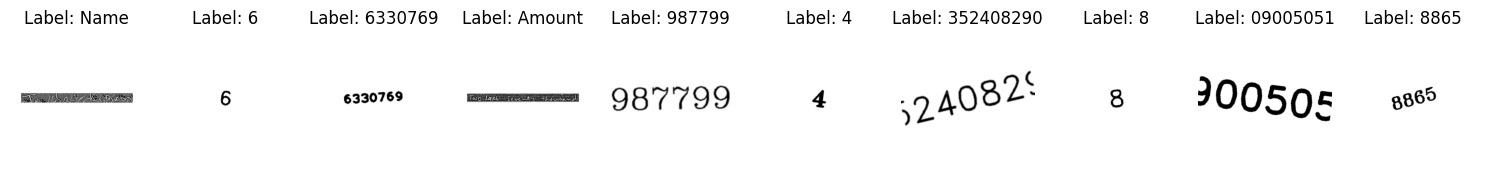

In [11]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric (to fix the undefined CTCSequenceF1Score error)
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        f1_components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Update state variables
        self.true_positives.assign_add(f1_components[0])
        self.false_positives.assign_add(f1_components[1])
        self.false_negatives.assign_add(f1_components[2])

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 100
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def build_improved_model(input_dim, output_dim):
    """
    Build an improved OCR model with better digit recognition
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_dim, name="input")
    
    # First convolutional block with batch normalization
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name="conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name="conv1_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(x)
    
    # Second convolutional block with batch normalization
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name="conv2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name="conv2_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(x)
    
    # Third convolutional block with batch normalization
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name="conv3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name="conv3_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool3")(x)
    
    # Fourth convolutional block (deeper than before)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name="conv4")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name="conv4_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool4")(x)
    
    # Reshape for sequence processing
    shape = x.get_shape()
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def main():
    # Define paths
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs
    configs = ModelConfigs()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load dataset with improved preprocessing
    print("Loading and processing dataset...")
    try:
        dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
        
        # Add synthetic data for better digit recognition
        processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
        synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
        
        # Combine real and synthetic datasets
        full_dataset = dataset + synthetic_dataset
        print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
        
        # Update vocab with digits (ensure all digits are represented)
        for digit in "0123456789":
            vocab.add(digit)
            
        # Save vocab and maximum text length to configs
        configs.vocab = "".join(sorted(vocab))
        configs.max_text_length = max(max_len, 10)  # Ensure space for longer sequences
        configs.save()
        
        print(f"Vocabulary size: {len(configs.vocab)}")
        print(f"Maximum text length: {configs.max_text_length}")
        
        # Visualize some samples
        visualize_dataset_samples(full_dataset, num_samples=10, 
                                 output_path=os.path.join(configs.model_path, "dataset_samples.png"))
        
        # Create a data provider for the dataset
        data_provider = DataProvider(
            dataset=full_dataset,
            skip_validation=True,
            batch_size=configs.batch_size,
            data_preprocessors=[ImageReader(CVImage)],
            transformers=[
                ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
                LabelIndexer(configs.vocab),
                LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
            ],
        )
        
        # Split the dataset into training and validation sets
        train_data_provider, val_data_provider = data_provider.split(split=0.9)
        
        # More aggressive augmentation for better generalization
        train_data_provider.augmentors = [
            RandomBrightness(factor=0.3),
            RandomRotate(angle=10),
            RandomErodeDilate(kernel_size=1),
            RandomSharpen(factor=0.5),
        ]
        
        # Create improved model
        model = build_improved_model(
            input_dim=(configs.height, configs.width, 3),
            output_dim=len(configs.vocab)
        )
        
        # Compile model with all metrics
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CTCSequenceF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab),
                LevenshteinMetric(vocabulary=configs.vocab)
            ],
            run_eagerly=False
        )
        
        model.summary(line_length=110)
        
        # Create visualization tool
        create_visualization_tool(configs.model_path)
        
        # Define callbacks with longer patience and model naming
        callbacks = [
            EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
            ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
            ModelCheckpoint(f"{configs.model_path}/model_epoch_{{epoch:03d}}.keras", monitor="val_CER", verbose=0, save_best_only=False, mode="min", save_freq=5),
            TrainLogger(configs.model_path),
            TensorBoard(f"{configs.model_path}/logs", update_freq=1),
            ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
            Model2onnx(f"{configs.model_path}/model.keras")
        ]
        
        # Train the model
        print("Starting training...")
        model.fit(
            train_data_provider,
            validation_data=val_data_provider,
            epochs=configs.train_epochs,
            callbacks=callbacks,
            #workers=configs.train_workers
        )
        
        # Save training and validation datasets as csv files
        train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
        val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))
        
    except Exception as e:
        import traceback
        print(f"Error in training process: {e}")
        traceback.print_exc()


if __name__ == "__main__":
    main()

updated code and improved 

In [3]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric (to fix the undefined CTCSequenceF1Score error)
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 1000
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def build_improved_model(input_dim, output_dim):
    """
    Build an improved OCR model with better digit recognition
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_dim, name="input")
    
    # First convolutional block with batch normalization
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name="conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name="conv1_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(x)
    
    # Second convolutional block with batch normalization
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name="conv2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name="conv2_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(x)
    
    # Third convolutional block with batch normalization
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name="conv3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name="conv3_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool3")(x)
    
    # Fourth convolutional block (deeper than before)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name="conv4")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name="conv4_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="pool4")(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def main():
    # Define paths
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs
    configs = ModelConfigs()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load dataset with improved preprocessing
    print("Loading and processing dataset...")
    try:
        dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
        
        # Add synthetic data for better digit recognition
        processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
        synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
        
        # Combine real and synthetic datasets
        full_dataset = dataset + synthetic_dataset
        print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
        
        # Update vocab with digits (ensure all digits are represented)
        for digit in "0123456789":
            vocab.add(digit)
            
        # Save vocab and maximum text length to configs
        configs.vocab = "".join(sorted(vocab))
        configs.max_text_length = max(max_len, 10)  # Ensure space for longer sequences
        configs.save()
        
        print(f"Vocabulary size: {len(configs.vocab)}")
        print(f"Maximum text length: {configs.max_text_length}")
        
        # Visualize some samples
        visualize_dataset_samples(full_dataset, num_samples=10, 
                                 output_path=os.path.join(configs.model_path, "dataset_samples.png"))
        
        # Create a data provider for the dataset
        data_provider = DataProvider(
            dataset=full_dataset,
            skip_validation=True,
            batch_size=configs.batch_size,
            data_preprocessors=[ImageReader(CVImage)],
            transformers=[
                ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
                LabelIndexer(configs.vocab),
                LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
            ],
        )
        
        # Split the dataset into training and validation sets
        train_data_provider, val_data_provider = data_provider.split(split=0.9)
        
        # More aggressive augmentation for better generalization
        train_data_provider.augmentors = [
            RandomBrightness(),  # Use default brightness adjustment
            RandomRotate(angle=10),
            RandomErodeDilate(kernel_size=1),
            RandomSharpen(),  # Use default sharpening factor
        ]
        
        # Create improved model
        model = build_improved_model(
            input_dim=(configs.height, configs.width, 3),
            output_dim=len(configs.vocab)
        )
        
        # Compile model with all metrics
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CTCSequenceF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab),
                LevenshteinMetric(vocabulary=configs.vocab)
            ],
            run_eagerly=False
        )
        
        model.summary(line_length=110)
        
        # Create visualization tool
        create_visualization_tool(configs.model_path)
        
        # Define callbacks with longer patience and model naming
        callbacks = [
            EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
            ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
            ModelCheckpoint(f"{configs.model_path}/model_epoch_{{epoch:03d}}.keras", monitor="val_CER", verbose=0, save_best_only=False, mode="min", save_freq=5),
            TrainLogger(configs.model_path),
            TensorBoard(f"{configs.model_path}/logs", update_freq=1),
            ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
            Model2onnx(f"{configs.model_path}/model.keras")
        ]
        
        # Train the model
        print("Starting training...")
        model.fit(
            train_data_provider,
            validation_data=val_data_provider,
            epochs=configs.train_epochs,
            callbacks=callbacks,
            #workers=configs.train_workers
        )
        
        # Save training and validation datasets as csv files
        train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
        val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))
        
    except Exception as e:
        import traceback
        print(f"Error in training process: {e}")
        traceback.print_exc()


if __name__ == "__main__":
    main()

Loading and processing dataset...


Processing images: 100%|██████████| 112/112 [00:31<00:00,  3.52it/s]


Generating 1000 synthetic digit samples...
Dataset size: 336 real + 1000 synthetic = 1336 total
Vocabulary size: 22
Maximum text length: 10


KeyboardInterrupt: 

use of other TL models - 

Resnet 50 

Loading and processing dataset...


Processing images: 100%|██████████| 112/112 [00:34<00:00,  3.29it/s]


Generating 1000 synthetic digit samples...
Dataset size: 336 real + 1000 synthetic = 1336 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 300, 300,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 150, 150,  │      9,472 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 150, 150,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 150, 150,  │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1            │ (None, 75, 75,    │          0 │ relu1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv1 │ (None, 75, 75,    │     36,928 │ maxpool1[0][0]    │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn1   │ (None, 75, 75,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu1 │ (None, 75, 75,    │          0 │ stage1_block1_bn… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv2 │ (None, 75, 75,    │     36,928 │ stage1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn2   │ (None, 75, 75,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 75, 75,    │          0 │ stage1_block1_bn… │
│ (Add)               │ 64)               │            │ maxpool1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu2 │ (None, 75, 75,    │          0 │ stage1_block1_ad… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv1 │ (None, 75, 75,    │     36,928 │ stage1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_bn1   │ (None, 75, 75,    │        256 │ stage1_block2_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_relu1 │ (None, 75, 75,    │          0 │ stage1_block2_bn… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv2 │ (None, 75, 75,    │     36,928 │ stage1_block2_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_bn2   │ (None, 75, 75,    │        256 │ stage1_block2_co

 Total params: 26,151,575 (99.76 MB)

 Trainable params: 26,140,951 (99.72 MB)

 Non-trainable params: 10,624 (41.50 KB)

Starting training with ResNet architecture...


c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 1.0931 - WER: 1.0000 - cheque_zone_score: 0.0690 - ctc_sequence_f1: 0.0642 - loss: inf
Epoch 1: val_CER improved from inf to 0.99277, saving model to Models\04_cheque_zone_recognition_resnet/model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - CER: 1.0905 - WER: 1.0000 - cheque_zone_score: 0.0691 - ctc_sequence_f1: 0.0642 - loss: inf - val_CER: 0.9928 - val_WER: 1.0000 - val_cheque_zone_score: 0.0672 - val_ctc_sequence_f1: 0.0672 - val_loss: inf - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 0.9538 - WER: 0.9851 - cheque_zone_score: 0.1198 - ctc_sequence_f1: 0.0934 - loss: inf
Epoch 2: val_CER improved from 0.99277 to 0.92894, saving model to Models\04_cheque_zone_recognition_resnet/model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - CER: 0.9530 - WER: 0.9848 - cheque_zone_score: 0.1201 - ctc_sequence_f1: 0.0938 - loss: inf - val_CER: 0.9289 - val_WER: 0.9742 - val_cheque_zone_score: 0.0672 - v

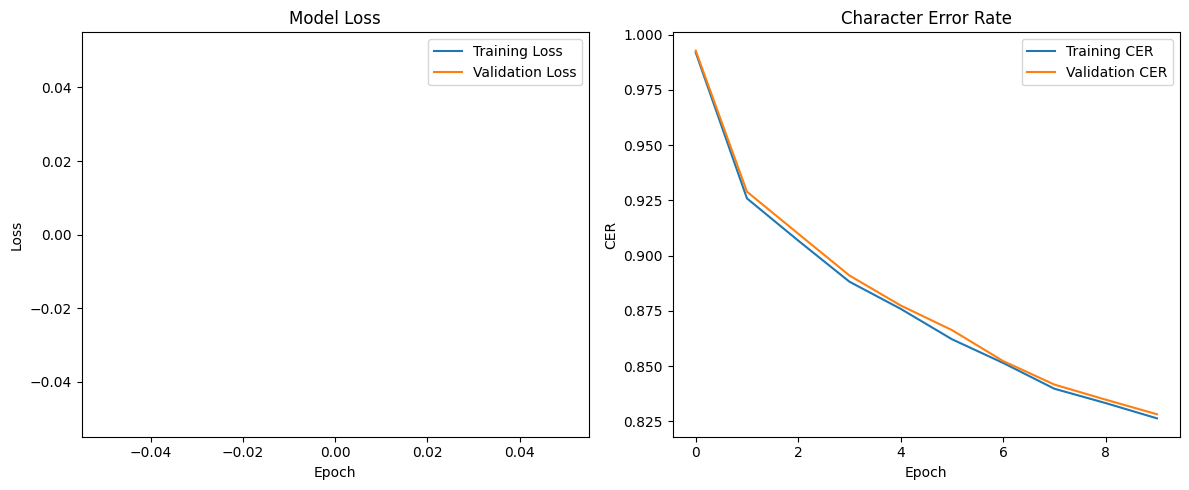

Model saved to Models\04_cheque_zone_recognition_resnet/model.keras


In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Define the ResNet Block
def resnet_block(inputs, filters, kernel_size=3, strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=f"{name}_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu1")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Skip connection
    if strides > 1 or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same', name=f"{name}_shortcut")(inputs)
        shortcut = tf.keras.layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    else:
        shortcut = inputs
    
    x = tf.keras.layers.add([x, shortcut], name=f"{name}_add")
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu2")(x)
    
    return x


def build_resnet_ocr_model(input_dim, output_dim):
    """
    Build a model that combines ResNet architecture with OCR-specific components
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_dim, name="input")
    
    # Initial convolution
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', name="conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(name="bn1")(x)
    x = tf.keras.layers.Activation('relu', name="relu1")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name="maxpool1")(x)
    
    # ResNet blocks
    # Stage 1
    x = resnet_block(x, 64, name="stage1_block1")
    x = resnet_block(x, 64, name="stage1_block2")
    
    # Stage 2
    x = resnet_block(x, 128, strides=2, name="stage2_block1")
    x = resnet_block(x, 128, name="stage2_block2")
    
    # Stage 3
    x = resnet_block(x, 256, strides=2, name="stage3_block1")
    x = resnet_block(x, 256, name="stage3_block2")
    
    # Stage 4 (reduced depth for OCR)
    x = resnet_block(x, 512, strides=2, name="stage4_block1")
    x = resnet_block(x, 512, name="stage4_block2")
    
    # Additional OCR-specific convolutional layer for feature refinement
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name="ocr_conv")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Create a hybrid model that combines ResNet and the original model architecture
def build_hybrid_model(input_dim, output_dim):
    """
    Build a hybrid model that combines ResNet features with the original OCR model architecture
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_dim, name="input")
    
    # ResNet-based feature extraction path
    resnet_path = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', name="resnet_conv1")(inputs)
    resnet_path = tf.keras.layers.BatchNormalization(name="resnet_bn1")(resnet_path)
    resnet_path = tf.keras.layers.Activation('relu', name="resnet_relu1")(resnet_path)
    resnet_path = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name="resnet_maxpool1")(resnet_path)
    
    # ResNet blocks
    resnet_path = resnet_block(resnet_path, 64, name="resnet_stage1_block1")
    resnet_path = resnet_block(resnet_path, 64, name="resnet_stage1_block2")
    resnet_path = resnet_block(resnet_path, 128, strides=2, name="resnet_stage2_block1")
    resnet_path = resnet_block(resnet_path, 128, name="resnet_stage2_block2")
    
    # Original model path (simplified)
    original_path = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name="original_conv1")(inputs)
    original_path = tf.keras.layers.BatchNormalization()(original_path)
    original_path = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="original_pool1")(original_path)
    
    original_path = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name="original_conv2")(original_path)
    original_path = tf.keras.layers.BatchNormalization()(original_path)
    original_path = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="original_pool2")(original_path)
    
    # Merge paths (feature fusion)
    # Resize ResNet path to match original path dimensions
    resnet_shape = tf.keras.backend.int_shape(resnet_path)
    original_shape = tf.keras.backend.int_shape(original_path)
    
    # Use resize to make dimensions compatible 
    resnet_resized = tf.keras.layers.Conv2D(128, (1, 1), padding='same')(resnet_path)  # Adjust channels
    resnet_resized = tf.keras.layers.UpSampling2D(
        size=(original_shape[1] // resnet_shape[1], original_shape[2] // resnet_shape[2])
    )(resnet_resized)
    
    # Concatenate features from both paths
    merged = tf.keras.layers.Concatenate()([original_path, resnet_resized])
    
    # Continue with shared layers
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(merged)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Use a pre-trained ResNet model as feature extractor
def build_pretrained_resnet_ocr(input_dim, output_dim):
    """
    Build a model that uses pre-trained ResNet50 as feature extractor with OCR-specific components
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Load pre-trained ResNet50 without top layers
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim
    )
    
    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Add OCR-specific layers
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name="ocr_conv")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_resnet")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "hybrid"  # Options: "resnet", "hybrid", "pretrained"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("resnet", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "resnet":
        return build_resnet_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)
    elif model_type == "pretrained":
        return build_pretrained_resnet_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


# Run this cell to train the model using ResNet architecture

def train_resnet_model():
    """Train a ResNet-based model for cheque zone recognition"""
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs and set to ResNet model type
    configs = ModelConfigs()
    configs.model_type = "resnet"  # Explicitly use ResNet model
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_resnet")
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset
    print("Loading and processing dataset...")
    dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
    
    # Add synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply data augmentation
    train_data_provider.augmentors = [
        RandomBrightness(factor),
        RandomRotate(angle=10),
        RandomErodeDilate(kernel_size=1),
        RandomSharpen(),
    ]
    
    # Build ResNet model
    model = build_resnet_ocr_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
    ]
    
    # Train model
    print("Starting training with ResNet architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks,
    )
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

# Run this function in your notebook to start training
model, configs = train_resnet_model()

Vgg 

In [1]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Define the ResNet Block
def resnet_block(inputs, filters, kernel_size=3, strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=f"{name}_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu1")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Skip connection
    if strides > 1 or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same', name=f"{name}_shortcut")(inputs)
        shortcut = tf.keras.layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    else:
        shortcut = inputs
    
    x = tf.keras.layers.add([x, shortcut], name=f"{name}_add")
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu2")(x)
    
    return x



class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_resnet")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "hybrid"  # Options: "resnet", "hybrid", "pretrained"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("resnet", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "resnet":
        return build_resnet_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)
    elif model_type == "pretrained":
        return build_pretrained_resnet_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


# Run this cell to train the model using ResNet architecture
# Rename the function to match VGG implementation
def build_pretrained_vgg_ocr(input_dim, output_dim):
    """
    Build a model that uses pre-trained VGG19 as feature extractor with OCR-specific components
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Load pre-trained VGG19 without top layers
    base_model = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim
    )
    
    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Add OCR-specific layers
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name="ocr_conv")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create a standalone VGG-based OCR model (not pre-trained)
def build_vgg_ocr_model(input_dim, output_dim):
    """
    Build a VGG-style OCR model from scratch
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # VGG-style convolutional blocks
    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3')(x)
    
    # Avoid further pooling to retain spatial information for OCR
    
    # Add batch normalization for better training stability
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Update the model selection function
def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("vgg", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "vgg":
        return build_vgg_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)  # Assuming this exists in your code
    elif model_type == "pretrained":
        return build_pretrained_vgg_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Update the training function to use VGG
def train_vgg_model():
    """Train a VGG-based model for cheque zone recognition"""
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs and set to VGG model type
    configs = ModelConfigs()
    configs.model_type = "vgg"  # Explicitly use VGG model
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset
    print("Loading and processing dataset...")
    dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
    
    # Add synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply data augmentation
    train_data_provider.augmentors = [
        RandomBrightness(),
        RandomRotate(angle=10),
        RandomErodeDilate(kernel_size=1),
        RandomSharpen(),
    ]
    
    # Build VGG model
    model = build_vgg_ocr_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs"),
    ]
    
    # Train model
    print("Starting training with VGG architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks,
    )
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

# Run this function to start training with VGG
model, configs = train_vgg_model()


Loading and processing dataset...


Processing images: 100%|██████████| 112/112 [01:22<00:00,  1.36it/s]


Generating 1000 synthetic digit samples...
Dataset size: 336 real + 1000 synthetic = 1336 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 37, 37, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 37, 18944)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 37, 512)        │    39,323,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 37, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 37, 23)         │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,547,671 (185.19 MB)

 Trainable params: 48,546,647 (185.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

Starting training with VGG architecture...


c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10



: 

mobilevnet

In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Define the ResNet Block
def resnet_block(inputs, filters, kernel_size=3, strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=f"{name}_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu1")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Skip connection
    if strides > 1 or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same', name=f"{name}_shortcut")(inputs)
        shortcut = tf.keras.layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    else:
        shortcut = inputs
    
    x = tf.keras.layers.add([x, shortcut], name=f"{name}_add")
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu2")(x)
    
    return x



class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_resnet")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "hybrid"  # Options: "resnet", "hybrid", "pretrained"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("resnet", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "resnet":
        return build_resnet_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)
    elif model_type == "pretrained":
        return build_pretrained_resnet_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


# Run this cell to train the model using ResNet architecture
# Rename the function to match VGG implementation
def build_pretrained_vgg_ocr(input_dim, output_dim):
    """
    Build a model that uses pre-trained VGG19 as feature extractor with OCR-specific components
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Load pre-trained VGG19 without top layers
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim
    )
    
    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Add OCR-specific layers
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name="ocr_conv")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create a standalone VGG-based OCR model (not pre-trained)
def build_vgg_ocr_model(input_dim, output_dim):
    """
    Build a VGG-style OCR model from scratch
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # VGG-style convolutional blocks
    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3')(x)
    
    # Avoid further pooling to retain spatial information for OCR
    
    # Add batch normalization for better training stability
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Update the model selection function
def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("vgg", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "vgg":
        return build_vgg_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)  # Assuming this exists in your code
    elif model_type == "pretrained":
        return build_pretrained_vgg_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Update the training function to use VGG
def train_vgg_model():
    """Train a VGG-based model for cheque zone recognition"""
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs and set to VGG model type
    configs = ModelConfigs()
    configs.model_type = "vgg"  # Explicitly use VGG model
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset
    print("Loading and processing dataset...")
    dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
    
    # Add synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply data augmentation
    train_data_provider.augmentors = [
        RandomBrightness(),
        RandomRotate(angle=10),
        RandomErodeDilate(kernel_size=1),
        RandomSharpen(),
    ]
    
    # Build VGG model
    model = build_vgg_ocr_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs"),
    ]
    
    # Train model
    print("Starting training with VGG architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks,
    )
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

# Run this function to start training with VGG
model, configs = train_vgg_model()


densenet

In [2]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Define the ResNet Block
def resnet_block(inputs, filters, kernel_size=3, strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=f"{name}_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu1")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Skip connection
    if strides > 1 or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same', name=f"{name}_shortcut")(inputs)
        shortcut = tf.keras.layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    else:
        shortcut = inputs
    
    x = tf.keras.layers.add([x, shortcut], name=f"{name}_add")
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu2")(x)
    
    return x



class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_resnet")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "hybrid"  # Options: "resnet", "hybrid", "pretrained"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("resnet", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "resnet":
        return build_resnet_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)
    elif model_type == "pretrained":
        return build_pretrained_resnet_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


# Run this cell to train the model using ResNet architecture
# Rename the function to match VGG implementation
def build_pretrained_vgg_ocr(input_dim, output_dim):
    """
    Build a model that uses pre-trained VGG19 as feature extractor with OCR-specific components
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Load pre-trained VGG19 without top layers
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim
    )
    
    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Add OCR-specific layers
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name="ocr_conv")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create a standalone VGG-based OCR model (not pre-trained)
def build_vgg_ocr_model(input_dim, output_dim):
    """
    Build a VGG-style OCR model from scratch
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # VGG-style convolutional blocks
    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3')(x)
    
    # Avoid further pooling to retain spatial information for OCR
    
    # Add batch normalization for better training stability
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Update the model selection function
def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("vgg", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "vgg":
        return build_vgg_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)  # Assuming this exists in your code
    elif model_type == "pretrained":
        return build_pretrained_vgg_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Update the training function to use VGG
def train_vgg_model():
    """Train a VGG-based model for cheque zone recognition"""
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs and set to VGG model type
    configs = ModelConfigs()
    configs.model_type = "vgg"  # Explicitly use VGG model
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset
    print("Loading and processing dataset...")
    dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
    
    # Add synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply data augmentation
    train_data_provider.augmentors = [
        RandomBrightness(),
        RandomRotate(angle=10),
        RandomErodeDilate(kernel_size=1),
        RandomSharpen(),
    ]
    
    # Build VGG model
    model = build_vgg_ocr_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs"),
    ]
    
    # Train model
    print("Starting training with VGG architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks,
    )
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

# Run this function to start training with VGG
model, configs = train_vgg_model()


Loading and processing dataset...


Processing images: 100%|██████████| 112/112 [00:31<00:00,  3.51it/s]


Generating 1000 synthetic digit samples...
Dataset size: 336 real + 1000 synthetic = 1336 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 37, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 37, 18944)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 37, 512)        │    39,323,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 37, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37, 23)         │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,547,671 (185.19 MB)

 Trainable params: 48,546,647 (185.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

Starting training with VGG architecture...
Epoch 1/10


AlreadyExistsError: Graph execution error:

Detected at node StatefulPartitionedCall/ArithmeticOptimizer/AddOpsRewrite_add_14/tmp_var defined at (most recent call last):
<stack traces unavailable>
Resource __per_step_0/StatefulPartitionedCall/ArithmeticOptimizer/AddOpsRewrite_add_14/tmp_var/frame:0/iter:0/struct tensorflow::TemporaryVariableOp::TmpVar
	 [[{{node StatefulPartitionedCall/ArithmeticOptimizer/AddOpsRewrite_add_14/tmp_var}}]] [Op:__inference_multi_step_on_iterator_26006]

efficientnet 

In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Define the ResNet Block
def resnet_block(inputs, filters, kernel_size=3, strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=f"{name}_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu1")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', name=f"{name}_conv2")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(x)
    
    # Skip connection
    if strides > 1 or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same', name=f"{name}_shortcut")(inputs)
        shortcut = tf.keras.layers.BatchNormalization(name=f"{name}_shortcut_bn")(shortcut)
    else:
        shortcut = inputs
    
    x = tf.keras.layers.add([x, shortcut], name=f"{name}_add")
    x = tf.keras.layers.Activation('relu', name=f"{name}_relu2")(x)
    
    return x



class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_resnet")
        self.batch_size = 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "hybrid"  # Options: "resnet", "hybrid", "pretrained"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("resnet", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "resnet":
        return build_resnet_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)
    elif model_type == "pretrained":
        return build_pretrained_resnet_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def generate_synthetic_digits(processed_dir, num_samples=1000):
    """
    Generate synthetic digit images to improve digit recognition
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX, 
             cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_TRIPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Generate random digit sequence (1-10 digits)
        length = random.randint(1, 10)
        digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
        
        # Create a blank white image
        img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        # Choose random font and scale
        font = random.choice(fonts)
        font_scale = random.uniform(1.0, 3.0)
        thickness = random.randint(2, 5)
        
        # Get text size to center it
        (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
        x = (300 - text_width) // 2
        y = (300 + text_height) // 2
        
        # Apply random rotation
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
        
        # Add some random noise
        noise = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.randn(noise, 0, random.uniform(0, 15))
        img = cv2.add(img, noise)
        
        # Draw text
        cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
        
        # Apply rotation
        img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        # Apply random blur
        if random.random() < 0.3:
            blur_size = random.choice([3, 5, 7])
            img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
        
        # Save the synthetic image
        image_path = os.path.join(synthetic_dir, f"synthetic_{i:05d}.png")
        cv2.imwrite(image_path, img)
        
        # Add to dataset
        synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


def load_dataset(image_folder, label_folder, target_size=(300, 300)):
    """
    Load dataset and create a list of [processed_image_path, label] pairs with improved preprocessing
    
    Returns:
        dataset: List of [image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            continue
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                print(f"Skipping empty label in {image_file}")
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                print(f"Invalid bounding box in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                print(f"Empty crop in {image_file}: ({x_min}, {y_min}, {x_max}, {y_max})")
                continue
            
            # Improved preprocessing for better digit recognition
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply adaptive thresholding to handle varying lighting
            binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # 3. Denoise
            denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Calculate padding with margin
            crop_h, crop_w = processed.shape[:2]
            margin_h = int(crop_h * 0.1)  # 10% margin
            margin_w = int(crop_w * 0.1)  # 10% margin
            
            pad_top = max((target_size[0] - crop_h) // 2, margin_h)
            pad_bottom = max(target_size[0] - crop_h - pad_top, margin_h)
            pad_left = max((target_size[1] - crop_w) // 2, margin_w)
            pad_right = max(target_size[1] - crop_w - pad_left, margin_w)
            
            # Apply padding with white pixels
            padded_crop = cv2.copyMakeBorder(
                processed, pad_top, pad_bottom, pad_left, pad_right,
                cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
            
            # Resize to target size while preserving aspect ratio
            h, w = padded_crop.shape[:2]
            scale = min(target_size[0] / h, target_size[1] / w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(padded_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_h) // 2
            offset_w = (target_size[1] - new_w) // 2
            canvas[offset_h:offset_h + new_h, offset_w:offset_w + new_w] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            dataset.append([processed_path, label])
            vocab.update(list(label))
            max_len = max(max_len, len(label))
    
    return dataset, vocab, max_len


# Run this cell to train the model using ResNet architecture
# Rename the function to match VGG implementation
def build_pretrained_vgg_ocr(input_dim, output_dim):
    """
    Build a model that uses pre-trained VGG19 as feature extractor with OCR-specific components
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Load pre-trained VGG19 without top layers
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim
    )
    
    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Add OCR-specific layers
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name="ocr_conv")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create a standalone VGG-based OCR model (not pre-trained)
def build_vgg_ocr_model(input_dim, output_dim):
    """
    Build a VGG-style OCR model from scratch
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # VGG-style convolutional blocks
    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3')(x)
    
    # Avoid further pooling to retain spatial information for OCR
    
    # Add batch normalization for better training stability
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Bidirectional LSTM layers for sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Update the model selection function
def select_model_architecture(model_type, input_dim, output_dim):
    """
    Select and return the appropriate model architecture based on the model_type
    
    Args:
        model_type: Type of model to build ("vgg", "hybrid", or "pretrained")
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Selected model
    """
    if model_type == "vgg":
        return build_vgg_ocr_model(input_dim, output_dim)
    elif model_type == "hybrid":
        return build_hybrid_model(input_dim, output_dim)  # Assuming this exists in your code
    elif model_type == "pretrained":
        return build_pretrained_vgg_ocr(input_dim, output_dim)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Update the training function to use VGG
def train_vgg_model():
    """Train a VGG-based model for cheque zone recognition"""
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs and set to VGG model type
    configs = ModelConfigs()
    configs.model_type = "vgg"  # Explicitly use VGG model
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset
    print("Loading and processing dataset...")
    dataset, vocab, max_len = load_dataset(image_folder, label_folder, target_size=(300, 300))
    
    # Add synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=1000)
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply data augmentation
    train_data_provider.augmentors = [
        RandomBrightness(),
        RandomRotate(angle=10),
        RandomErodeDilate(kernel_size=1),
        RandomSharpen(),
    ]
    
    # Build VGG model
    model = build_vgg_ocr_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=25, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=8, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs"),
    ]
    
    # Train model
    print("Starting training with VGG architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks,
    )
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

# Run this function to start training with VGG
model, configs = train_vgg_model()


Loading and processing dataset...


Processing images: 100%|██████████| 112/112 [01:04<00:00,  1.74it/s]


Generating 1000 synthetic digit samples...
Dataset size: 336 real + 1000 synthetic = 1336 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 37, 37, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 37, 18944)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 37, 512)        │    39,323,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 37, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 37, 23)         │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,547,671 (185.19 MB)

 Trainable params: 48,546,647 (185.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

Starting training with VGG architecture...


c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

 1/38 ━━━━━━━━━━━━━━━━━━━━ 47:56 78s/step - CER: 6.3940 - WER: 1.0000 - cheque_zone_score: 0.1562 - ctc_sequence_f1: 0.0000e+00 - loss: 95.2128

good code is below 

In [5]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_optimized_model(input_dim, output_dim):
    """
    Build a more efficient model architecture with explicit float32 dtype
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use EfficientNetB0 as base (smaller than VGG or ResNet)
    # Remove the dtype parameter as it's not supported
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
# Use Keras Lambda layer instead of direct tf.cast
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)    
    # Simpler OCR-specific layers
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name="ocr_conv", dtype='float32')(x)
    x = tf.keras.layers.BatchNormalization(dtype='float32')(x)
    
    # Reshape for sequence processing
    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]), dtype='float32')(x)
    
    # Use single LSTM layer with fewer units
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dtype='float32'))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax', name="dense", dtype='float32')(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 10
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 100
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    predictor = Predictor(
        model=model,
        preprocess_fn=None,  # No additional preprocessing needed
    )
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        pred = predictor.predict(img_input)
        pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics


def visualize_predictions(model, configs, test_dataset=None, num_samples=5):
    """
    Visualize model predictions on test images with actual predicted text
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
        num_samples: Number of samples to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Select random samples
    indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        img_path, true_label = test_dataset[idx]
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image for model input
        img_resized = cv2.resize(img_rgb, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_normalized = img_resized.astype(np.float32) / 255.0
        img_input = np.expand_dims(img_normalized, axis=0)
        
        # Get prediction
        prediction = model.predict(img_input, verbose=0)
        
        # Decode prediction using CTC decoder
        input_length = np.array([prediction.shape[1]])
        
        # Use CTC greedy decoder
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(prediction, [1, 0, 2]),
            sequence_length=input_length
        )
        
        # Convert sparse tensor to dense
        decoded_dense = tf.sparse.to_dense(decoded[0]).numpy()
        
        # Convert indices to text
        predicted_text = ""
        for token_idx in decoded_dense[0]:
            if token_idx < len(configs.vocab):
                predicted_text += configs.vocab[token_idx]
        
        # Display the image with true and predicted labels
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_text}", fontsize=14)
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save the visualization
    vis_dir = os.path.join(configs.model_path, 'prediction_visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    plt.savefig(os.path.join(vis_dir, 'predictions_sample.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Visualize predictions on 5 random images
    print("\nVisualizing predictions on 5 random images...")
    visualize_predictions(model, configs, num_samples=5)
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:07<00:00, 15.82it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 300, 300,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 300, 300,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 9,759,418 (37.23 MB)

 Trainable params: 8,014,631 (30.57 MB)

 Non-trainable params: 1,744,787 (6.66 MB)

Starting training with optimized architecture...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 1.3487 - WER: 0.9759 - cer_wer_f1_score: -0.0143 - cheque_zone_score: 0.0979 - ctc_sequence_f1: 0.0632 - levenshtein_distance: 3.6659 - loss: 14.3757
Epoch 1: val_CER improved from inf to 0.96780, saving model to Models\04_cheque_zone_recognition_optimized/model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - CER: 1.3179 - WER: 0.9715 - cer_wer_f1_score: -0.0082 - cheque_zone_score: 0.1022 - ctc_sequence_f1: 0.0675 - levenshtein_distance: 3.6012 - loss: 14.0906 - val_CER: 0.9678 - val_WER: 0.9258 - val_cer_wer_f1_score: 0.0449 - val_cheque_zone_score: 0.0952 - val_ctc_sequence_f1: 0.0119 - val_levenshtein_distance: 2.9405 - val_loss: 17.3513 - learning_rate: 0.0010
Epoch 2/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - CER: 0.8830 - WER: 0.8827 - cer_wer_f1_score: 0.1163 - cheque_zone_score: 0.3204 - ctc_sequence_f1: 0.2870 - levenshtein_distance: 2.0739 - loss: 6.7785

KeyboardInterrupt: 

Resnet model 

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 28.09it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 9,759,418 (37.23 MB)

 Trainable params: 8,014,631 (30.57 MB)

 Non-trainable params: 1,744,787 (6.66 MB)

Starting training with optimized architecture...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 1.3468 - WER: 0.9840 - cer_wer_f1_score: 0.0033 - cheque_zone_score: 0.0846 - ctc_sequence_f1: 0.0707 - levenshtein_distance: 3.7419 - loss: 15.0213    
Epoch 1: val_CER improved from inf to 0.98110, saving model to Models\04_cheque_zone_recognition_optimized/model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - CER: 1.3181 - WER: 0.9809 - cer_wer_f1_score: 0.0058 - cheque_zone_score: 0.0876 - ctc_sequence_f1: 0.0738 - levenshtein_distance: 3.6824 - loss: 14.7468 - val_CER: 0.9811 - val_WER: 0.9474 - val_cer_wer_f1_score: 0.0278 - val_cheque_zone_score: 0.0952 - val_ctc_sequence_f1: 0.0119 - val_levenshtein_distance: 3.4881 - val_loss: 18.0273 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 0.8797 - WER: 0.9104 - cer_wer_f1_score: 0.1018 - cheque_zone_score: 0.2342 - ctc_sequence_f1: 0.2058 - levenshtein_distance: 2.0638 - loss: 6.8905
Epoch 2: val_C

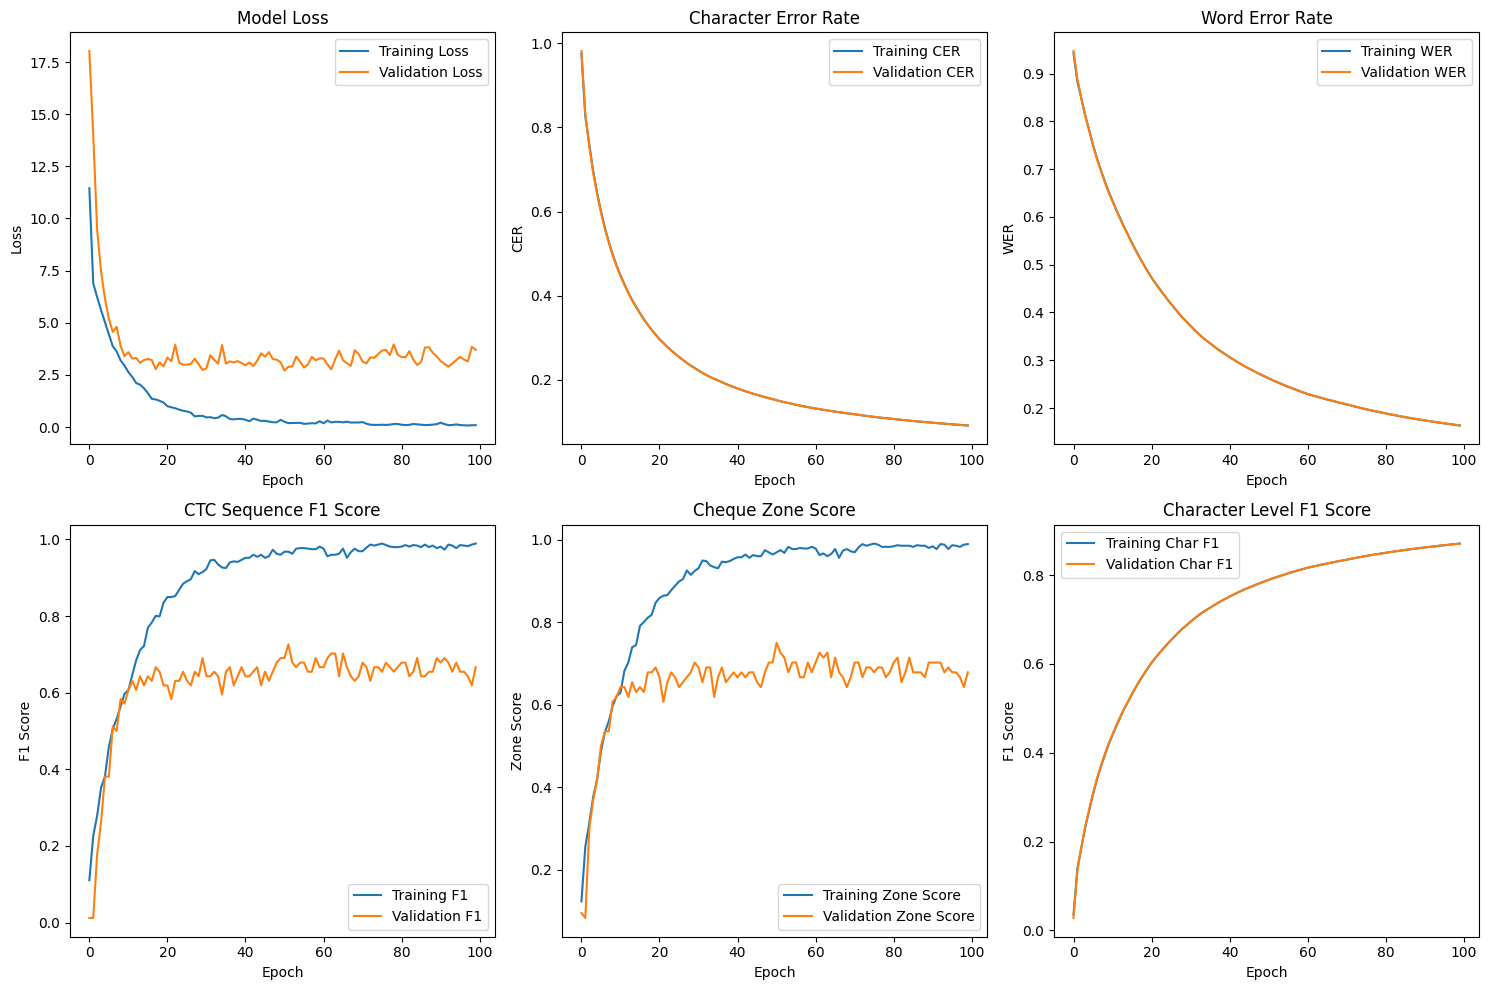

Model saved to Models\04_cheque_zone_recognition_optimized/model.keras
Training completed in 79.82 minutes
Processing 112 images with 11 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 29.56it/s]


Processed 336 regions from 112 images
Evaluating model on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - CER: 0.0919 - WER: 0.1635 - cer_wer_f1_score: 0.8708 - cheque_zone_score: 1.0000 - ctc_sequence_f1: 1.0000 - levenshtein_distance: 0.0000e+00 - loss: 0.0158
loss: 0.0158
compile_metrics: 0.0919
Saved 10 test examples to Models\04_cheque_zone_recognition_optimized\test_results


In [2]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_resnet_model(input_dim, output_dim):
    """
    Build an optimized model architecture using ResNet50 as the base model
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use ResNet50 as base (smaller than VGG but more powerful than EfficientNetB0)
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)
    
    # Add a max pooling layer to reduce feature map size
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # Reshape for sequence processing - first expand dimensions to create a sequence
    x = tf.keras.layers.Reshape((1, -1))(x)
    
    # Repeat the features to create a sequence of appropriate length
    # This is needed because ResNet outputs a single feature vector per image,
    # while OCR needs a sequence of features
    x = tf.keras.layers.RepeatVector(32)(x)
    
    # Project to a reasonable dimension for the LSTM
    x = tf.keras.layers.Dense(512, activation='relu', dtype='float32')(x)
    
    # Add sequence layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dtype='float32')
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="dense", dtype='float32'
    )(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 100
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 100
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    #from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    #predictor = Predictor(
    #    model=model,
    #    preprocess_fn=None,  # No additional preprocessing needed
    #)
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        #pred = predictor.predict(img_input)
        #pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics


# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available/'
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)

VGG

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 28.64it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 300, 300,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 300, 300,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 300, 300,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 9,759,418 (37.23 MB)

 Trainable params: 8,014,631 (30.57 MB)

 Non-trainable params: 1,744,787 (6.66 MB)

Starting training with optimized architecture...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 1.2885 - WER: 0.9707 - cer_wer_f1_score: 0.0462 - cheque_zone_score: 0.0774 - ctc_sequence_f1: 0.0528 - levenshtein_distance: 3.5694 - loss: 14.6550
Epoch 1: val_CER improved from inf to 0.97141, saving model to Models\04_cheque_zone_recognition_optimized/model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - CER: 1.2616 - WER: 0.9677 - cer_wer_f1_score: 0.0477 - cheque_zone_score: 0.0817 - ctc_sequence_f1: 0.0565 - levenshtein_distance: 3.5135 - loss: 14.3941 - val_CER: 0.9714 - val_WER: 0.9378 - val_cer_wer_f1_score: 0.0392 - val_cheque_zone_score: 0.0476 - val_ctc_sequence_f1: 0.0000e+00 - val_levenshtein_distance: 3.7381 - val_loss: 19.0324 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 0.8774 - WER: 0.8973 - cer_wer_f1_score: 0.1110 - cheque_zone_score: 0.2518 - ctc_sequence_f1: 0.2271 - levenshtein_distance: 2.1289 - loss: 7.2005
Epoch 2: val_C

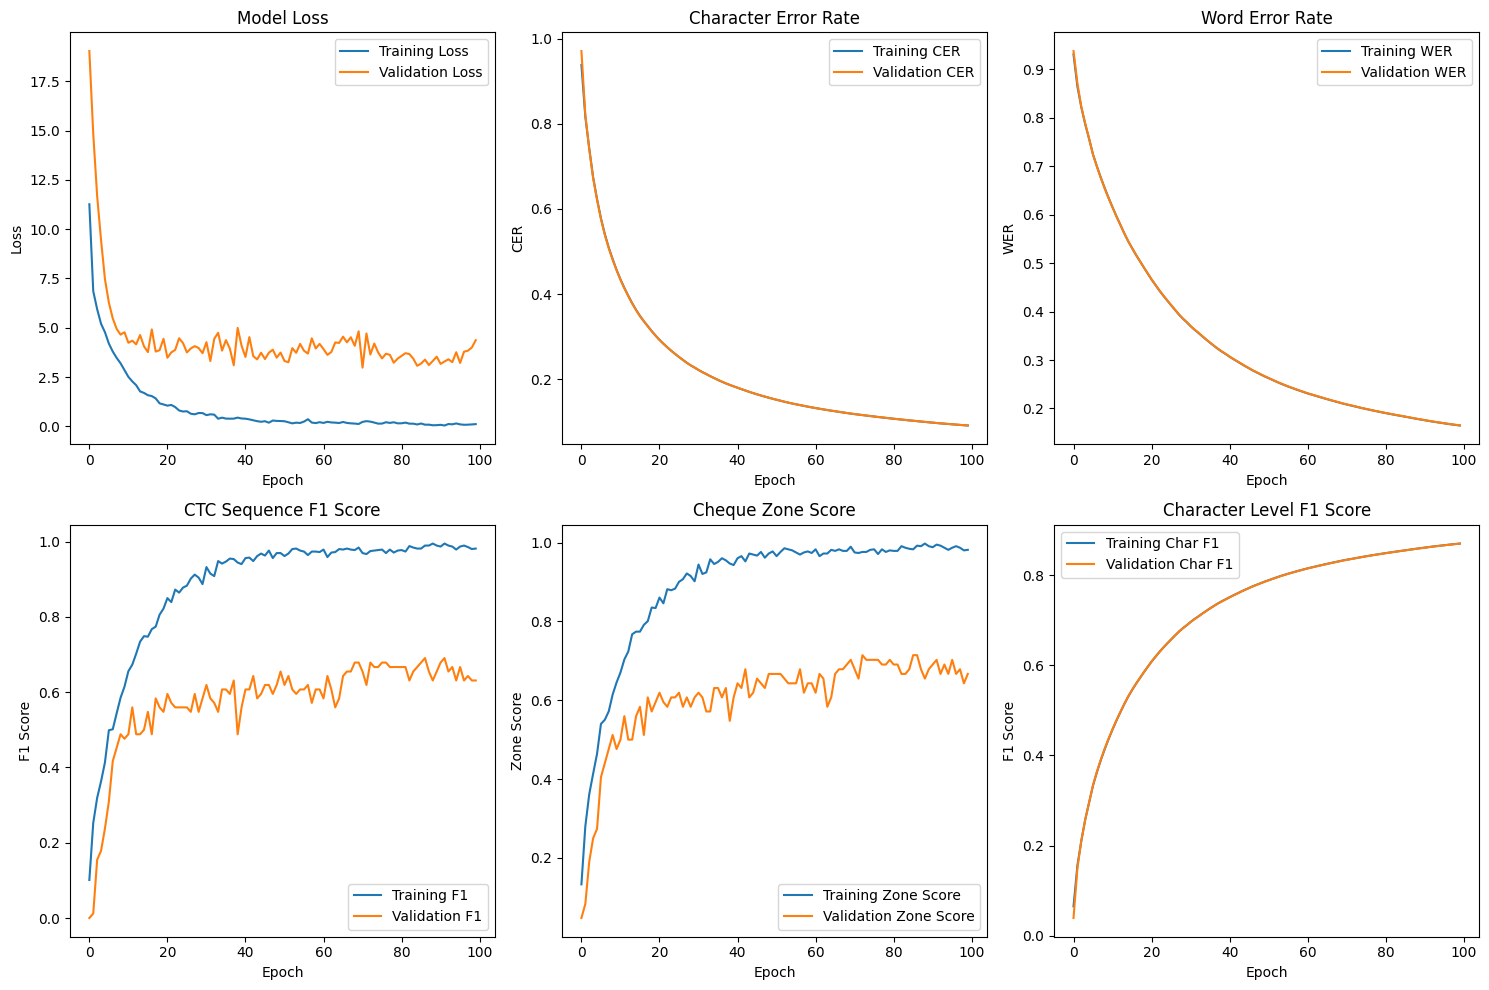

Model saved to Models\04_cheque_zone_recognition_optimized/model.keras
Training completed in 80.79 minutes
Processing 112 images with 11 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 32.43it/s]


Processed 336 regions from 112 images
Evaluating model on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - CER: 0.0910 - WER: 0.1651 - cer_wer_f1_score: 0.8704 - cheque_zone_score: 1.0000 - ctc_sequence_f1: 1.0000 - levenshtein_distance: 0.0000e+00 - loss: 0.0081
loss: 0.0081
compile_metrics: 0.0910
Saved 10 test examples to Models\04_cheque_zone_recognition_optimized\test_results


In [4]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_resnet_model(input_dim, output_dim):
    """
    Build an optimized model architecture using ResNet50 as the base model
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use ResNet50 as base (smaller than VGG but more powerful than EfficientNetB0)
    base_model = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)
    
    # Add a max pooling layer to reduce feature map size
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # Reshape for sequence processing - first expand dimensions to create a sequence
    x = tf.keras.layers.Reshape((1, -1))(x)
    
    # Repeat the features to create a sequence of appropriate length
    # This is needed because ResNet outputs a single feature vector per image,
    # while OCR needs a sequence of features
    x = tf.keras.layers.RepeatVector(32)(x)
    
    # Project to a reasonable dimension for the LSTM
    x = tf.keras.layers.Dense(512, activation='relu', dtype='float32')(x)
    
    # Add sequence layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dtype='float32')
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="dense", dtype='float32'
    )(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 100
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 100
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        #TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    #from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    #predictor = Predictor(
    #    model=model,
    #    preprocess_fn=None,  # No additional preprocessing needed
    #)
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        #pred = predictor.predict(img_input)
        #pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics


# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available/'
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)

DenseNet

In [3]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_resnet_model(input_dim, output_dim):
    """
    Build an optimized model architecture using ResNet50 as the base model
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use ResNet50 as base (smaller than VGG but more powerful than EfficientNetB0)
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)
    
    # Add a max pooling layer to reduce feature map size
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # Reshape for sequence processing - first expand dimensions to create a sequence
    x = tf.keras.layers.Reshape((1, -1))(x)
    
    # Repeat the features to create a sequence of appropriate length
    # This is needed because ResNet outputs a single feature vector per image,
    # while OCR needs a sequence of features
    x = tf.keras.layers.RepeatVector(32)(x)
    
    # Project to a reasonable dimension for the LSTM
    x = tf.keras.layers.Dense(512, activation='relu', dtype='float32')(x)
    
    # Add sequence layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dtype='float32')
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="dense", dtype='float32'
    )(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 200
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 100
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        #TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    #from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    #predictor = Predictor(
    #    model=model,
    #    preprocess_fn=None,  # No additional preprocessing needed
    #)
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        #pred = predictor.predict(img_input)
        #pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics


# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available/'
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 30.53it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10


NameError: name 'build_optimized_model' is not defined

MobileVNet

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 32.03it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_12        │ (None, 300, 300,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 300, 300,  │          7 │ rescaling_12[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_13        │ (None, 300, 300,  │          0 │ normalization_6[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_13[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 9,759,418 (37.23 MB)

 Trainable params: 8,014,631 (30.57 MB)

 Non-trainable params: 1,744,787 (6.66 MB)

Starting training with optimized architecture...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 1.3283 - WER: 0.9743 - cer_wer_f1_score: -1.0686 - cheque_zone_score: 0.0981 - ctc_sequence_f1: 0.0756 - levenshtein_distance: 3.8210 - loss: 14.4970
Epoch 1: val_CER improved from inf to 0.96376, saving model to Models\04_cheque_zone_recognition_optimized/model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - CER: 1.2989 - WER: 0.9704 - cer_wer_f1_score: -0.9815 - cheque_zone_score: 0.1018 - ctc_sequence_f1: 0.0795 - levenshtein_distance: 3.7495 - loss: 14.2093 - val_CER: 0.9638 - val_WER: 0.9151 - val_cer_wer_f1_score: 0.0508 - val_cheque_zone_score: 0.2381 - val_ctc_sequence_f1: 0.1667 - val_levenshtein_distance: 3.7500 - val_loss: 16.7286 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - CER: 0.8745 - WER: 0.8818 - cer_wer_f1_score: 0.1208 - cheque_zone_score: 0.2696 - ctc_sequence_f1: 0.2423 - levenshtein_distance: 2.1071 - loss: 6.8320
Epoch 2: val_CER

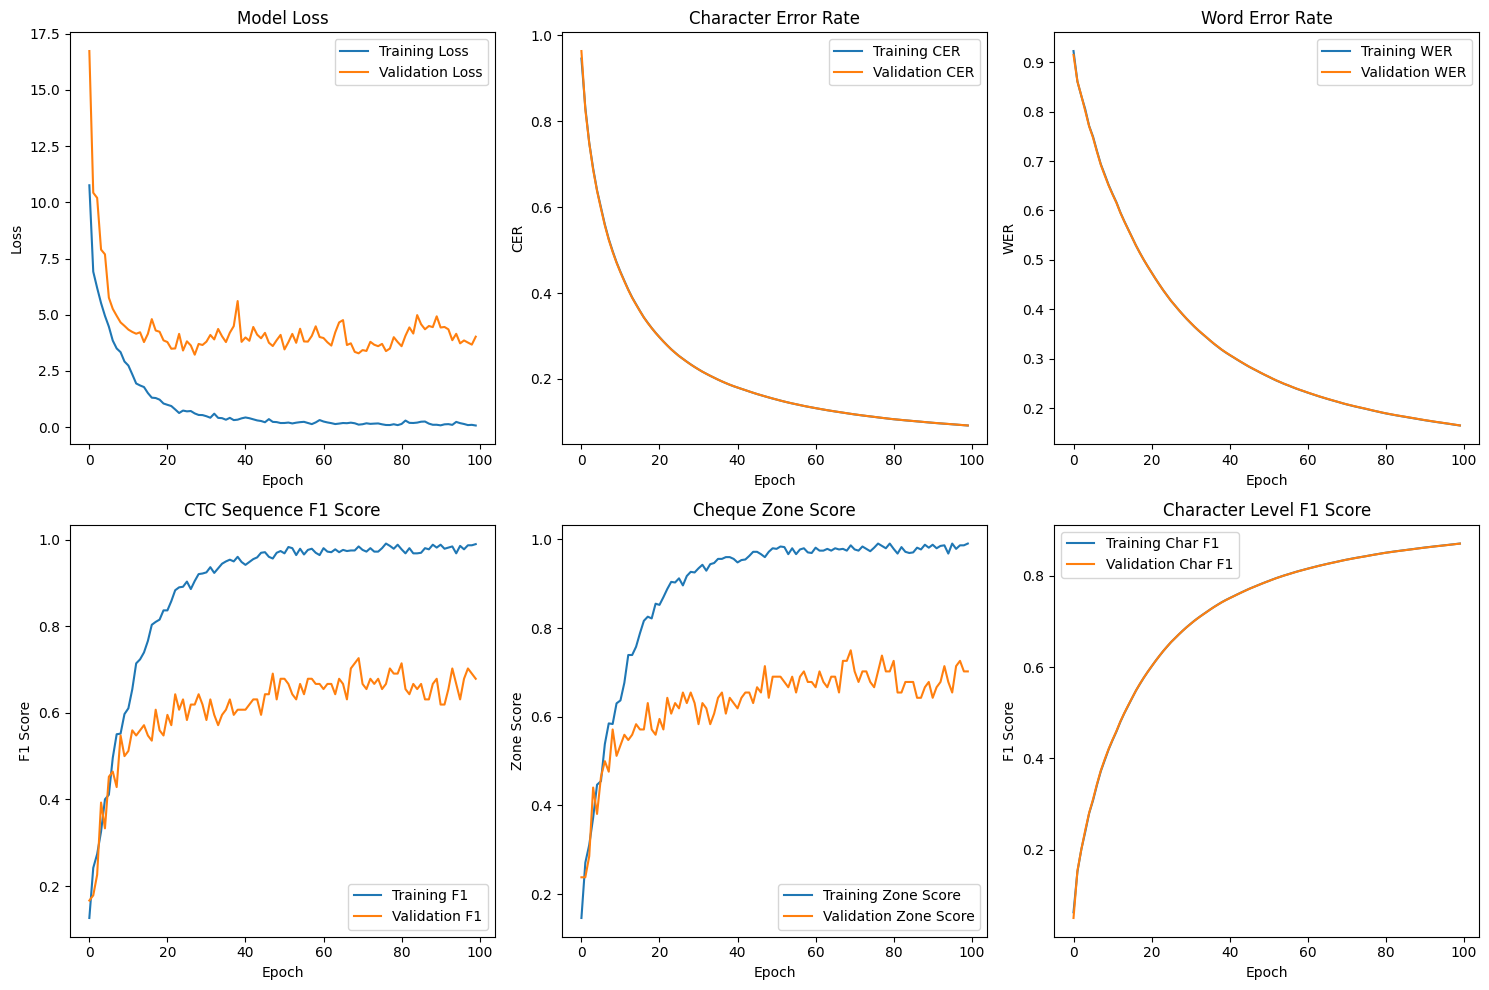

Model saved to Models\04_cheque_zone_recognition_optimized/model.keras
Training completed in 82.48 minutes
Processing 112 images with 11 workers...


Processing Images: 100%|██████████| 112/112 [00:03<00:00, 29.25it/s]


Processed 336 regions from 112 images
Evaluating model on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - CER: 0.0914 - WER: 0.1647 - cer_wer_f1_score: 0.8704 - cheque_zone_score: 1.0000 - ctc_sequence_f1: 1.0000 - levenshtein_distance: 0.0000e+00 - loss: 0.0071
loss: 0.0071
compile_metrics: 0.0914
Saved 10 test examples to Models\04_cheque_zone_recognition_optimized\test_results


In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_resnet_model(input_dim, output_dim):
    """
    Build an optimized model architecture using ResNet50 as the base model
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use ResNet50 as base (smaller than VGG but more powerful than EfficientNetB0)
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)
    
    # Add a max pooling layer to reduce feature map size
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # Reshape for sequence processing - first expand dimensions to create a sequence
    x = tf.keras.layers.Reshape((1, -1))(x)
    
    # Repeat the features to create a sequence of appropriate length
    # This is needed because ResNet outputs a single feature vector per image,
    # while OCR needs a sequence of features
    x = tf.keras.layers.RepeatVector(32)(x)
    
    # Project to a reasonable dimension for the LSTM
    x = tf.keras.layers.Dense(512, activation='relu', dtype='float32')(x)
    
    # Add sequence layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dtype='float32')
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="dense", dtype='float32'
    )(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 100
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 100
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        #TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    #from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    #predictor = Predictor(
    #    model=model,
    #    preprocess_fn=None,  # No additional preprocessing needed
    #)
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        #pred = predictor.predict(img_input)
        #pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics


# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available/'
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)
        


### addressing the overfitting in the code - using mobilevnet in this model 

In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing with More Augmentations
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len

def generate_enhanced_synthetic_data(processed_dir, num_samples=1000):
    """
    Generate more realistic synthetic data with enhanced variations - FIXED version
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    # Increased font variety
    fonts = [
        cv2.FONT_HERSHEY_SIMPLEX, 
        cv2.FONT_HERSHEY_PLAIN, 
        cv2.FONT_HERSHEY_DUPLEX,
        cv2.FONT_HERSHEY_COMPLEX, 
        cv2.FONT_HERSHEY_TRIPLEX,
        cv2.FONT_HERSHEY_COMPLEX_SMALL,
        cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
        cv2.FONT_HERSHEY_SCRIPT_COMPLEX
    ]
    
    # Various background patterns and colors
    bg_colors = [
        (255, 255, 255),  # White
        (250, 250, 250),  # Off-white
        (245, 245, 240),  # Light cream
        (240, 248, 255),  # Light blue tint
        (255, 250, 240),  # Light peach tint
    ]
    
    # Text colors (mostly dark with some variation)
    text_colors = [
        (0, 0, 0),       # Black
        (20, 20, 20),    # Near black
        (25, 25, 112),   # Midnight blue
        (0, 0, 128),     # Navy
        (70, 55, 35),    # Dark brown
    ]
    
    print(f"Generating {num_samples} enhanced synthetic samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Generate various types of text data
    data_types = [
        "digits",       # Only digits
        "alphanumeric", # Mix of letters and digits
        "dates",        # Date formats
        "amounts",      # Currency amounts with decimals
        "codes"         # Reference codes
    ]
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Choose data type for this sample
            data_type = random.choice(data_types)
            
            # Generate text based on data type
            if data_type == "digits":
                # Pure digit sequence (1-10 digits)
                length = random.randint(1, 10)
                text = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            elif data_type == "alphanumeric":
                # Alphanumeric sequence (3-8 chars)
                length = random.randint(3, 8)
                chars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
                text = ''.join([random.choice(chars) for _ in range(length)])
            
            elif data_type == "dates":
                # Date formats
                formats = [
                    f"{random.randint(1, 31):02d}/{random.randint(1, 12):02d}/{random.randint(2000, 2025)}",
                    f"{random.randint(1, 31):02d}-{random.randint(1, 12):02d}-{random.randint(2000, 2025)}",
                    f"{random.randint(1, 12):02d}/{random.randint(1, 31):02d}/{random.randint(0, 99):02d}"
                ]
                text = random.choice(formats)
            
            elif data_type == "amounts":
                # Currency amounts
                whole = random.randint(1, 999999)
                decimal = random.randint(0, 99)
                text = f"{whole}.{decimal:02d}"
                # Sometimes add commas for thousands
                if random.random() > 0.5 and whole >= 1000:
                    text = f"{whole:,}.{decimal:02d}"
            
            else:  # codes
                # Reference codes
                patterns = [
                    f"REF-{random.randint(100000, 999999)}",
                    f"ID#{random.randint(1000, 9999)}/{random.randint(1, 99)}",
                    f"AC{random.randint(10000, 99999)}X"
                ]
                text = random.choice(patterns)
            
            # Create a background canvas with slightly varying color
            bg_color = random.choice(bg_colors)
            # Add slight variation to the chosen color
            bg_color = tuple(min(255, max(0, c + random.randint(-5, 5))) for c in bg_color)
            
            # Convert bg_color to a list if it's a tuple for borderValue compatibility
            bg_color_list = list(bg_color)
            
            img = np.ones((300, 300, 3), dtype=np.uint8)
            img[:] = bg_color_list  # Use broadcasting for setting color
            
            # Choose random font, color and scale
            font = random.choice(fonts)
            text_color = random.choice(text_colors)
            font_scale = random.uniform(1.2, 2.2)
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
            
            # Calculate position with some randomization
            x_offset = random.randint(-10, 10)
            y_offset = random.randint(-5, 15)
            x = max(5, (300 - text_width) // 2 + x_offset)
            y = max(text_height + 5, (300 + text_height) // 2 + y_offset)
            
            # Draw text with the selected color
            cv2.putText(img, text, (x, y), font, font_scale, text_color, thickness)
            
            # Instead of rotation with warpAffine, use simple approach
            if random.random() < 0.7:  # 70% chance to apply rotation
                # Use a simpler, more robust rotation approach
                center = (300 // 2, 300 // 2)
                angle = random.uniform(-15, 15)
                rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
                try:
                    # Fix: Convert bg_color to list for borderValue
                    img = cv2.warpAffine(img, rot_mat, (300, 300), 
                                         borderMode=cv2.BORDER_CONSTANT, 
                                         borderValue=bg_color_list)
                except cv2.error:
                    # If rotation fails, just keep the original image
                    print(f"Warning: Rotation failed for sample {sample_idx}, skipping rotation")
            
            # Apply transformations with probability
            # Occasionally apply blur
            if random.random() < 0.3:
                blur_size = random.choice([3, 5])
                try:
                    img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
                except cv2.error:
                    # Skip if blur fails
                    pass
            
            # Occasionally apply noise
            if random.random() < 0.2:
                try:
                    noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
                    img = cv2.add(img, noise)
                except cv2.error:
                    # Skip if noise addition fails
                    pass
            
            # Skip the perspective transform as it's causing issues
            # Instead occasionally apply a small affine transform
            if random.random() < 0.15:
                try:
                    h, w = img.shape[:2]
                    # Simple affine transform instead of perspective
                    src_pts = np.float32([[0, 0], [w-1, 0], [0, h-1]])
                    # Small distortions
                    offset = 15
                    dst_pts = np.float32([
                        [0+random.randint(0, offset), 0+random.randint(0, offset)],
                        [w-1-random.randint(0, offset), 0+random.randint(0, offset)],
                        [0+random.randint(0, offset), h-1-random.randint(0, offset)]
                    ])
                    
                    # Get the transform matrix and apply
                    warp_mat = cv2.getAffineTransform(src_pts, dst_pts)
                    img = cv2.warpAffine(img, warp_mat, (w, h), 
                                         borderMode=cv2.BORDER_CONSTANT, 
                                         borderValue=bg_color_list)
                except cv2.error:
                    # Skip if transform fails
                    print(f"Warning: Affine transform failed for sample {sample_idx}, skipping transform")
            
            # Save the synthetic image
            try:
                image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
                cv2.imwrite(image_path, img)
                
                # Add to dataset
                synthetic_dataset.append([image_path, text])
            except Exception as e:
                print(f"Error saving sample {sample_idx}: {str(e)}")
    
    print(f"Successfully generated {len(synthetic_dataset)} synthetic samples")
    return synthetic_dataset

def build_optimized_model(input_dim, output_dim):
    """
    Build an improved model architecture with regularization and batch normalization
    Fixed to handle tensor dimension issues and layer name conflicts
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use MobileNetV2 as base (lighter than ResNet50)
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None,
        alpha=0.75  # Use a smaller multiplier to reduce model size
    )
    
    # Freeze approximately 70% of the layers (less than before to allow more adaptation)
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.7)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'), name='float32_casting')(x)
    
    # Add global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
    
    # Add batch normalization after pooling
    x = tf.keras.layers.BatchNormalization(name='bn_after_pooling')(x)
    
    # Create a sequence by repeating the features
    x = tf.keras.layers.RepeatVector(24, name='repeat_vector')(x)
    
    # Project to a smaller dimension for the LSTM
    x = tf.keras.layers.Dense(384, activation='relu', dtype='float32', name='dense_projection')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_after_projection')(x)
    x = tf.keras.layers.Dropout(0.3, name='dropout_1')(x)  # Increased dropout
    
    # Add sequence layers with additional regularization
    # First bidirectional LSTM layer
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(192, return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                            recurrent_regularizer=tf.keras.regularizers.l2(1e-5),
                            dtype='float32'),
        name='bidirectional_1'
    )(x)
    x = tf.keras.layers.BatchNormalization(name='bn_after_lstm1')(x)
    x = tf.keras.layers.Dropout(0.3, name='dropout_2')(x)
    
    # Second bidirectional LSTM layer
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                            recurrent_regularizer=tf.keras.regularizers.l2(1e-5),
                            dtype='float32'),
        name='bidirectional_2'
    )(x)
    x = tf.keras.layers.BatchNormalization(name='bn_after_lstm2')(x)
    x = tf.keras.layers.Dropout(0.25, name='dropout_3')(x)
    
    # Output layer - FIXED: changed name from "dense" to "output_dense"
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="output_dense", 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5),
        dtype='float32'
    )(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Learning Rate Scheduler with Warmup
class WarmupCosineDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, lr_base=0.001, lr_min=1e-6, warmup_epochs=5, decay_epochs=95, verbose=0):
        super(WarmupCosineDecayScheduler, self).__init__()
        self.lr_base = lr_base
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.verbose = verbose
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Warmup phase - linear increase
            lr = self.lr_base * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay phase
            decay_epoch = epoch - self.warmup_epochs
            decay_progress = decay_epoch / self.decay_epochs
            cosine_decay = 0.5 * (1 + np.cos(np.pi * min(1, decay_progress)))
            lr = self.lr_min + (self.lr_base - self.lr_min) * cosine_decay
        
        # Set learning rate directly
        self.model.optimizer.learning_rate = lr
        
        if self.verbose:
            print(f"Epoch {epoch+1}: Learning rate = {lr:.6f}")

class SafeMetricWrapper(tf.keras.metrics.Metric):
    def __init__(self, metric, name=None):
        super().__init__(name=name or f"safe_{metric.name}")
        self.metric = metric
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        return self.metric.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        result_value = self.metric.result()
        # First convert to tensor with correct dtype
        result_tensor = tf.convert_to_tensor(result_value, dtype=tf.float32)
        
        # Check the rank of the tensor and ensure it's a scalar
        if tf.rank(result_tensor) > 0:
            # If it's not a scalar, reduce it
            return tf.reduce_mean(result_tensor)
        
        # If it's already a scalar, return as is
        return result_tensor
        
    def reset_state(self):
        return self.metric.reset_state()
    
# 3. Modified k_fold_cross_validation function
def k_fold_cross_validation(build_model_fn, dataset, configs, k=5, epochs=50):
    """
    Perform k-fold cross-validation
    
    Args:
        build_model_fn: Function to build the model
        dataset: Dataset to use for training and validation
        configs: Model configurations
        k: Number of folds
        epochs: Number of epochs to train each fold
        
    Returns:
        List of metrics dictionaries for each fold
    """
    # Prepare dataset for k-fold
    random.shuffle(dataset)
    fold_size = len(dataset) // k
    
    # Initialize metrics collection
    all_metrics = []
    
    # Create KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Iterate through folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        print(f"\n=== Training Fold {fold+1}/{k} ===")
        
        # Split dataset
        train_data = [dataset[i] for i in train_indices]
        val_data = [dataset[i] for i in val_indices]
        
        print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")
        
        # Create data providers
        train_data_provider = DataProvider(
            dataset=train_data,
            skip_validation=True,
            batch_size=configs.batch_size,
            data_preprocessors=[ImageReader(CVImage)],
            transformers=[
                ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
                LabelIndexer(configs.vocab),
                LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
            ],
        )
        
        val_data_provider = DataProvider(
            dataset=val_data,
            skip_validation=True,
            batch_size=configs.batch_size,
            data_preprocessors=[ImageReader(CVImage)],
            transformers=[
                ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
                LabelIndexer(configs.vocab),
                LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
            ],
        )
        
        # Apply enhanced data augmentation
        train_data_provider.augmentors = [
            RandomBrightness(),
            RandomRotate(angle=10),
            RandomSharpen(),
            RandomErodeDilate(kernel_size=2)
        ]
        
        # Build model
        model = build_model_fn(
            input_dim=(configs.height, configs.width, 3),
            output_dim=len(configs.vocab)
        )
        
        # Compile model with safe metrics
        optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                SafeMetricWrapper(CERMetric(vocabulary=configs.vocab)),
                SafeMetricWrapper(WERMetric(vocabulary=configs.vocab)),
                SafeMetricWrapper(CTCSequenceF1Score(vocabulary=configs.vocab)),
                SafeMetricWrapper(ChequeZoneScore(vocabulary=configs.vocab)),
                SafeMetricWrapper(CharacterLevelF1Score(vocabulary=configs.vocab)),
                SafeMetricWrapper(LevenshteinMetric(vocabulary=configs.vocab))
            ],
            run_eagerly=True  # Set to True for debugging
        )
        
        # Save folder for this fold
        fold_dir = os.path.join(configs.model_path, f"fold_{fold+1}")
        os.makedirs(fold_dir, exist_ok=True)
        
        # Callbacks
        lr_scheduler = WarmupCosineDecayScheduler(
            lr_base=configs.learning_rate,
            lr_min=configs.learning_rate / 100,
            warmup_epochs=5,
            decay_epochs=epochs-5,
            verbose=1
        )
        
        callbacks = [
            EarlyStopping(
                monitor="val_safe_CER", 
                patience=10, 
                verbose=1, 
                mode="min",
                restore_best_weights=True
            ),
            ModelCheckpoint(
                f"{fold_dir}/model.keras", 
                monitor="val_safe_CER", 
                verbose=1, 
                save_best_only=True, 
                mode="min"
            ),
            lr_scheduler
        ]
        
        # Train model for this fold
        history = model.fit(
            train_data_provider,
            validation_data=val_data_provider,
            epochs=epochs,
            callbacks=callbacks
        )
        
        # Evaluate on validation set
        eval_results = model.evaluate(val_data_provider, verbose=1)
        
        # Save metrics
        metrics = {}
        for name, value in zip(model.metrics_names, eval_results):
            metrics[name] = float(value)
        
        # Add best metrics from history
        metrics['best_val_cer'] = min(history.history['val_safe_CER'])
        metrics['best_val_wer'] = min(history.history['val_safe_WER'])
        
        # Save history plots
        plot_history(history, fold_dir)
        
        # Add to all metrics
        all_metrics.append(metrics)
        
        # Clear backend session to avoid memory leaks
        tf.keras.backend.clear_session()
    
    # Calculate average metrics across folds
    avg_metrics = {}
    for metric in all_metrics[0].keys():
        avg_metrics[metric] = sum(fold[metric] for fold in all_metrics) / k
    
    print("\n=== Cross-Validation Results ===")
    for metric, value in avg_metrics.items():
        print(f"Average {metric}: {value:.4f}")
    
    # Save average metrics
    with open(os.path.join(configs.model_path, "cv_metrics.json"), "w") as f:
        json.dump(avg_metrics, f, indent=2)
    
    return all_metrics
# Function to plot training history
def plot_history(history, output_dir):
    """
    Plot training history with all metrics
    
    Args:
        history: History object from model.fit()
        output_dir: Directory to save plots
    """
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_history.png"))
    plt.close()


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_improved")
        self.batch_size = 32  # Reduced from 64 for better generalization
        self.learning_rate = 0.0005  # Reduced learning rate
        self.train_epochs = 200
        self.train_workers = 8
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "improved"
        self.augmentation_level = "enhanced"
        self.k_folds = 5  # Number of folds for cross-validation
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)


# Main training function with cross-validation
def train_improved_model():
    """Train an improved model for cheque zone recognition with cross-validation"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with improved parameters
    configs = ModelConfigs()
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_improved")
    configs.batch_size = 32  # Reduced batch size for better generalization
    configs.learning_rate = 0.0005  # Lower learning rate
    configs.train_epochs = 70  # Fewer epochs with cross-validation
    configs.k_folds = 5
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add enhanced synthetic data
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_enhanced_synthetic_data(processed_dir, num_samples=1500)
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits and common characters are in vocabulary
    extra_chars = "0123456789.,/-:;()$#@!%ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    for char in extra_chars:
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 20)  # Increased maximum text length
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Visualize some dataset samples
    visualize_dataset_samples(full_dataset, num_samples=10, 
                             output_path=os.path.join(configs.model_path, "dataset_samples.png"))
    
    # Perform cross-validation
    cv_metrics = k_fold_cross_validation(
        build_optimized_model,
        full_dataset,
        configs,
        k=configs.k_folds,
        epochs=configs.train_epochs
    )
    
    # Train final model on full dataset
    print("\n=== Training Final Model on Full Dataset ===")
    
    # Create data provider for full dataset
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split data, but use a larger portion for training
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply enhanced data augmentation to training data
    train_data_provider.augmentors = [
        RandomBrightness(),
        RandomRotate(angle=10),
        RandomSharpen(),
        RandomErodeDilate(kernel_size=2)
    ]
    
    # Build final model
    # 5. Final model training in train_improved_model function
# Find this section in the train_improved_model function and replace it:

# Build final model
    final_model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Compile with metrics
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    final_model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            SafeMetricWrapper(CERMetric(vocabulary=configs.vocab)),
            SafeMetricWrapper(WERMetric(vocabulary=configs.vocab)),
            SafeMetricWrapper(CTCSequenceF1Score(vocabulary=configs.vocab)),
            SafeMetricWrapper(ChequeZoneScore(vocabulary=configs.vocab)),
            SafeMetricWrapper(CharacterLevelF1Score(vocabulary=configs.vocab)),
            SafeMetricWrapper(LevenshteinMetric(vocabulary=configs.vocab))
        ],
        run_eagerly=True
    )
    
    # Advanced learning rate scheduler
    lr_scheduler = WarmupCosineDecayScheduler(
        lr_base=configs.learning_rate,
        lr_min=configs.learning_rate / 100,
        warmup_epochs=5,
        decay_epochs=configs.train_epochs-5,
        verbose=1
    )
    
    # Final callbacks
    final_callbacks = [
        EarlyStopping(
            monitor="val_safe_CER", 
            patience=12, 
            verbose=1, 
            mode="min",
            restore_best_weights=True
        ),
        ModelCheckpoint(
            f"{configs.model_path}/model.keras", 
            monitor="val_safe_CER", 
            verbose=1, 
            save_best_only=True, 
            mode="min"
        ),
        lr_scheduler
    ]
    
    # Train final model
    final_history = final_model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=final_callbacks
    )
    
    # Plot final training history
    plot_history(final_history, configs.model_path)
    
    # Save model summary
    model_summary = []
    final_model.summary(print_fn=lambda x: model_summary.append(x))
    with open(os.path.join(configs.model_path, "model_summary.txt"), "w") as f:
        f.write("\n".join(model_summary))
    
    print(f"Final model saved to {configs.model_path}/model.keras")
    
    return final_model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    import cv2
    import random
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        try:
            img = cv2.imread(img_path)
            if img is None:
                # If image can't be read, create a blank image
                img = np.ones((300, 300, 3), dtype=np.uint8) * 255
                axes[i].imshow(img)
                axes[i].set_title(f"Error loading image\nLabel: {label}")
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
                axes[i].set_title(f"Label: {label}")
        except Exception as e:
            print(f"Error displaying image {img_path}: {str(e)}")
            # Create a blank image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            axes[i].imshow(img)
            axes[i].set_title(f"Error: {str(e)[:20]}...\nLabel: {label}")
        
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
        plt.close()
    else:
        plt.show()
        
# Evaluate model with stratified sampling
def evaluate_improved_model(model, configs, test_size=0.1):
    """
    Evaluate the improved model with stratified sampling of test data
    
    Args:
        model: Trained model
        configs: Model configuration
        test_size: Proportion of data to use for testing
        
    Returns:
        Dictionary with evaluation metrics
    """
    # Load the original dataset (no synthetic data for testing)
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
    
    # Stratify by text length
    def get_length_category(item):
        label = item[1]
        if len(label) <= 3:
            return 'short'
        elif len(label) <= 8:
            return 'medium'
        else:
            return 'long'
    
    # Group by category
    categories = {}
    for item in dataset:
        category = get_length_category(item)
        if category not in categories:
            categories[category] = []
        categories[category].append(item)
    
    # Create stratified test set
    test_dataset = []
    for category, items in categories.items():
        random.shuffle(items)
        num_test = max(1, int(len(items) * test_size))
        test_dataset.extend(items[:num_test])
    
    # Create data provider for test set
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,   
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print(f"Evaluating model on {len(test_dataset)} test samples...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create visualization directory
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create error analysis for failed predictions
    analyze_prediction_errors(model, test_dataset, configs, vis_dir)
    
    return metrics


def analyze_prediction_errors(model, test_dataset, configs, output_dir, num_samples=20):
    """
    Analyze and visualize prediction errors
    
    Args:
        model: Trained model
        test_dataset: Test dataset to evaluate
        configs: Model configuration
        output_dir: Directory to save visualizations
        num_samples: Number of samples to analyze
    """
    # Create a subdirectory for error analysis
    error_dir = os.path.join(output_dir, 'error_analysis')
    os.makedirs(error_dir, exist_ok=True)
    
    # Sample random test examples
    random.shuffle(test_dataset)
    samples = test_dataset[:num_samples]
    
    # Initialize counters
    correct = 0
    total = 0
    error_categories = {
        'substitution': 0,
        'deletion': 0,
        'insertion': 0,
        'ordering': 0,
        'complete_mismatch': 0
    }
    
    # Analyze each sample
    for i, (img_path, true_label) in enumerate(samples):
        # Preprocess the image
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb / 255.0, axis=0)  # Normalize
        
        # Get prediction
        pred_probabilities = model.predict(img_input, verbose=0)
        
        # Decode using CTC
        input_length = np.array([pred_probabilities.shape[1]])
        decoded = tf.keras.backend.ctc_decode(
            pred_probabilities, 
            input_length,
            greedy=True
        )[0][0].numpy()[0]
        
        # Convert to text
        pred_label = ''.join([configs.vocab[idx] for idx in decoded if idx >= 0 and idx < len(configs.vocab)])
        
        # Check if prediction is correct
        is_correct = (pred_label == true_label)
        if is_correct:
            correct += 1
        total += 1
        
        # Analyze error type if incorrect
        if not is_correct:
            if len(pred_label) < len(true_label):
                error_categories['deletion'] += 1
            elif len(pred_label) > len(true_label):
                error_categories['insertion'] += 1
            elif sorted(pred_label) == sorted(true_label):
                error_categories['ordering'] += 1
            elif len(set(pred_label) & set(true_label)) / max(len(pred_label), len(true_label)) < 0.3:
                error_categories['complete_mismatch'] += 1
            else:
                error_categories['substitution'] += 1
        
        # Create visualization
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 1, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        color = 'green' if is_correct else 'red'
        plt.title(f"True: '{true_label}' | Pred: '{pred_label}'", color=color)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(error_dir, f"sample_{i+1}.png"))
        plt.close()
    
    # Create summary report
    accuracy = correct / total if total > 0 else 0
    with open(os.path.join(error_dir, "error_analysis.txt"), "w") as f:
        f.write(f"Analysis of {num_samples} random samples:\n")
        f.write(f"Correct predictions: {correct}/{total} ({accuracy*100:.2f}%)\n\n")
        f.write("Error categories:\n")
        for category, count in error_categories.items():
            percentage = count / (total - correct) * 100 if total > correct else 0
            f.write(f"- {category}: {count} ({percentage:.2f}%)\n")
    
    # Create error distribution plot
    if total > correct:
        plt.figure(figsize=(10, 6))
        categories = list(error_categories.keys())
        counts = [error_categories[cat] for cat in categories]
        plt.bar(categories, counts)
        plt.title("Error Type Distribution")
        plt.ylabel("Count")
        plt.savefig(os.path.join(error_dir, "error_distribution.png"))
        plt.close()
    
    print(f"Error analysis completed. Results saved to {error_dir}")


# Compare original and improved models
def compare_models_comprehensive(original_model_path, improved_model_path, test_dataset=None):
    """
    Comprehensive comparison between original and improved models
    
    Args:
        original_model_path: Path to original model directory
        improved_model_path: Path to improved model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load improved model configs
    improved_configs = ModelConfigs()
    improved_configs.model_path = improved_model_path
    improved_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
            "CTCSequenceF1Score": CTCSequenceF1Score(vocabulary=original_configs.vocab),
            "ChequeZoneScore": ChequeZoneScore(vocabulary=original_configs.vocab),
            "CharacterLevelF1Score": CharacterLevelF1Score(vocabulary=original_configs.vocab),
            "LevenshteinMetric": LevenshteinMetric(vocabulary=original_configs.vocab)
        }
    )
    
    improved_model = tf.keras.models.load_model(
        os.path.join(improved_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=improved_configs.vocab),
            "WERMetric": WERMetric(vocabulary=improved_configs.vocab),
            "CTCSequenceF1Score": CTCSequenceF1Score(vocabulary=improved_configs.vocab),
            "ChequeZoneScore": ChequeZoneScore(vocabulary=improved_configs.vocab),
            "CharacterLevelF1Score": CharacterLevelF1Score(vocabulary=improved_configs.vocab),
            "LevenshteinMetric": LevenshteinMetric(vocabulary=improved_configs.vocab)
        }
    )
    
    # If no test dataset provided, create a stratified one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Stratify by length
        def get_length_category(item):
            label = item[1]
            if len(label) <= 3:
                return 'short'
            elif len(label) <= 8:
                return 'medium'
            else:
                return 'long'
        
        # Group by category
        categories = {}
        for item in dataset:
            category = get_length_category(item)
            if category not in categories:
                categories[category] = []
            categories[category].append(item)
        
        # Create stratified test set (15% of each category)
        test_dataset = []
        for category, items in categories.items():
            random.shuffle(items)
            num_test = max(1, int(len(items) * 0.15))
            test_dataset.extend(items[:num_test])
        
        print(f"Created stratified test set with {len(test_dataset)} samples")
    
    # Create comparison directory
    comparison_dir = os.path.join("Models", "model_comparison_comprehensive")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Prepare data providers for both models
    original_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=32,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(original_configs.width, original_configs.height, keep_aspect_ratio=True),
            LabelIndexer(original_configs.vocab),LabelPadding(max_word_length=original_configs.max_text_length, padding_value=len(original_configs.vocab)),
        ],
    )
    
    improved_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=32,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(improved_configs.width, improved_configs.height, keep_aspect_ratio=True),
            LabelIndexer(improved_configs.vocab),
            LabelPadding(max_word_length=improved_configs.max_text_length, padding_value=len(improved_configs.vocab)),
        ],
    )
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = original_model.evaluate(original_data_provider, verbose=1)
    original_metrics_dict = {name: value for name, value in zip(original_model.metrics_names, original_metrics)}
    
    print("\nEvaluating Improved Model:")
    improved_metrics = improved_model.evaluate(improved_data_provider, verbose=1)
    improved_metrics_dict = {name: value for name, value in zip(improved_model.metrics_names, improved_metrics)}
    
    # Compare metrics
    print("\nComparison:")
    
    comparison_table = []
    for metric in original_metrics_dict:
        if metric in improved_metrics_dict:
            original_value = original_metrics_dict[metric]
            improved_value = improved_metrics_dict[metric]
            
            # Calculate improvement percentage (handle metrics where lower is better)
            if metric in ['loss', 'CER', 'WER', 'levenshtein_distance']:
                # For these metrics, lower is better
                improvement = (1 - improved_value / original_value) * 100
            else:
                # For these metrics, higher is better
                improvement = (improved_value / original_value - 1) * 100
                
            print(f"{metric}: Original = {original_value:.4f}, Improved = {improved_value:.4f}, Change = {improvement:.2f}%")
            comparison_table.append([metric, original_value, improved_value, improvement])
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    improved_size = os.path.getsize(os.path.join(improved_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_change = (1 - improved_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Improved = {improved_size:.2f} MB, Change = {size_change:.2f}%")
    comparison_table.append(["Model Size (MB)", original_size, improved_size, size_change])
    
    # Compare inference speed on a standard batch
    import time
    
    # Create test batch with appropriate shape for each model
    original_batch = np.random.rand(32, original_configs.height, original_configs.width, 3)
    improved_batch = np.random.rand(32, improved_configs.height, improved_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(original_batch, verbose=0)
    _ = improved_model.predict(improved_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    original_times = []
    improved_times = []
    
    for _ in range(num_runs):
        # Original model timing
        start_time = time.time()
        _ = original_model.predict(original_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        # Improved model timing
        start_time = time.time()
        _ = improved_model.predict(improved_batch, verbose=0)
        improved_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_improved_time = sum(improved_times) / len(improved_times)
    speed_change = (1 - avg_improved_time / avg_original_time) * 100
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Improved = {avg_improved_time:.4f}s, Change = {speed_change:.2f}%")
    comparison_table.append(["Inference Time (s)", avg_original_time, avg_improved_time, speed_change])
    
    # Create comprehensive comparison visualization
    create_comparison_visualizations(comparison_table, comparison_dir)
    
    # Perform detailed prediction comparison on sample images
    print("\nPerforming detailed prediction comparison...")
    
    # Sample specific examples for comparison
    num_samples = min(20, len(test_dataset))
    comparison_samples = test_dataset[:num_samples]
    
    # Compare predictions
    for i, (img_path, true_label) in enumerate(comparison_samples):
        # Prepare image for both models
        img = cv2.imread(img_path)
        
        # Original model prediction
        img_resized_orig = cv2.resize(img, (original_configs.width, original_configs.height), interpolation=cv2.INTER_AREA)
        img_rgb_orig = cv2.cvtColor(img_resized_orig, cv2.COLOR_BGR2RGB)
        img_input_orig = np.expand_dims(img_rgb_orig / 255.0, axis=0)
        
        pred_orig = original_model.predict(img_input_orig, verbose=0)
        input_length_orig = np.array([pred_orig.shape[1]])
        decoded_orig = tf.keras.backend.ctc_decode(
            pred_orig, 
            input_length_orig,
            greedy=True
        )[0][0].numpy()[0]
        pred_label_orig = ''.join([original_configs.vocab[idx] for idx in decoded_orig if idx >= 0 and idx < len(original_configs.vocab)])
        
        # Improved model prediction
        img_resized_imp = cv2.resize(img, (improved_configs.width, improved_configs.height), interpolation=cv2.INTER_AREA)
        img_rgb_imp = cv2.cvtColor(img_resized_imp, cv2.COLOR_BGR2RGB)
        img_input_imp = np.expand_dims(img_rgb_imp / 255.0, axis=0)
        
        pred_imp = improved_model.predict(img_input_imp, verbose=0)
        input_length_imp = np.array([pred_imp.shape[1]])
        decoded_imp = tf.keras.backend.ctc_decode(
            pred_imp, 
            input_length_imp,
            greedy=True
        )[0][0].numpy()[0]
        pred_label_imp = ''.join([improved_configs.vocab[idx] for idx in decoded_imp if idx >= 0 and idx < len(improved_configs.vocab)])
        
        # Create side-by-side comparison
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Sample {i+1}: Ground Truth: '{true_label}'", fontsize=14)
        
        # Original image and prediction
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        color_orig = 'green' if pred_label_orig == true_label else 'red'
        plt.title(f"Original Model: '{pred_label_orig}'", color=color_orig)
        plt.axis('off')
        
        # Improved image and prediction
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        color_imp = 'green' if pred_label_imp == true_label else 'red'
        plt.title(f"Improved Model: '{pred_label_imp}'", color=color_imp)
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(comparison_dir, f"comparison_sample_{i+1}.png"))
        plt.close()
    
    print(f"Comparison results saved to {comparison_dir}")
    
    return {
        'original_metrics': original_metrics_dict,
        'improved_metrics': improved_metrics_dict,
        'model_size': {
            'original': original_size,
            'improved': improved_size,
            'change_percent': size_change
        },
        'inference_time': {
            'original': avg_original_time,
            'improved': avg_improved_time,
            'change_percent': speed_change
        }
    }


def create_comparison_visualizations(comparison_table, output_dir):
    """
    Create comprehensive comparison visualizations
    
    Args:
        comparison_table: List of [metric_name, original_value, improved_value, percent_change]
        output_dir: Directory to save visualizations
    """
    # Extract data for plotting
    metrics = [row[0] for row in comparison_table if row[0] not in ['Model Size (MB)', 'Inference Time (s)']]
    original_values = [row[1] for row in comparison_table if row[0] not in ['Model Size (MB)', 'Inference Time (s)']]
    improved_values = [row[2] for row in comparison_table if row[0] not in ['Model Size (MB)', 'Inference Time (s)']]
    percent_changes = [row[3] for row in comparison_table if row[0] not in ['Model Size (MB)', 'Inference Time (s)']]
    
    # Plot metrics comparison
    plt.figure(figsize=(15, 10))
    
    # Bar chart for metric values
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.subplot(2, 1, 1)
    bars1 = plt.bar(x - width/2, original_values, width, label='Original')
    bars2 = plt.bar(x + width/2, improved_values, width, label='Improved')
    
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend()
    
    # Annotate with values
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', rotation=90)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', rotation=90)
    
    # Bar chart for improvement percentage
    plt.subplot(2, 1, 2)
    colors = ['green' if x > 0 else 'red' for x in percent_changes]
    plt.bar(metrics, percent_changes, color=colors)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Metrics')
    plt.ylabel('Improvement (%)')
    plt.title('Improvement Percentage')
    plt.xticks(rotation=45, ha='right')
    
    # Annotate with values
    for i, v in enumerate(percent_changes):
        plt.text(i, v + (5 if v >= 0 else -5),
                f'{v:.2f}%', ha='center', va='bottom' if v >= 0 else 'top')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "metrics_comparison.png"))
    plt.close()
    
    # Create model size and inference time comparison
    model_size_original = next(row[1] for row in comparison_table if row[0] == 'Model Size (MB)')
    model_size_improved = next(row[2] for row in comparison_table if row[0] == 'Model Size (MB)')
    infer_time_original = next(row[1] for row in comparison_table if row[0] == 'Inference Time (s)')
    infer_time_improved = next(row[2] for row in comparison_table if row[0] == 'Inference Time (s)')
    
    plt.figure(figsize=(12, 5))
    
    # Model size comparison
    plt.subplot(1, 2, 1)
    plt.bar(['Original', 'Improved'], [model_size_original, model_size_improved])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Annotate with values
    plt.text(0, model_size_original + 0.5, f'{model_size_original:.2f} MB', ha='center')
    plt.text(1, model_size_improved + 0.5, f'{model_size_improved:.2f} MB', ha='center')
    
    # Inference time comparison
    plt.subplot(1, 2, 2)
    plt.bar(['Original', 'Improved'], [infer_time_original, infer_time_improved])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Annotate with values
    plt.text(0, infer_time_original + 0.005, f'{infer_time_original:.4f}s', ha='center')
    plt.text(1, infer_time_improved + 0.005, f'{infer_time_improved:.4f}s', ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "size_speed_comparison.png"))
    plt.close()
    
    # Create summary table as an image
    plt.figure(figsize=(12, len(comparison_table) * 0.5 + 1))
    plt.axis('tight')
    plt.axis('off')
    
    table_data = [['Metric', 'Original', 'Improved', 'Change (%)']]
    for row in comparison_table:
        table_data.append([
            row[0],     
            f'{row[1]:.4f}' if isinstance(row[1], float) else str(row[1]), 
            f'{row[2]:.4f}' if isinstance(row[2], float) else str(row[2]), 
            f'{row[3]:.2f}%'
        ])
    
    colors = []
    # Header color
    colors.append(['#D4D4D4', '#D4D4D4', '#D4D4D4', '#D4D4D4'])
    
    # Row colors - green for improvement, red for regression
    for row in comparison_table:
        is_better = row[3] > 0
        # For loss and error metrics, lower is better so invert the logic
        if row[0] in ['loss', 'CER', 'WER', 'levenshtein_distance', 'Model Size (MB)', 'Inference Time (s)']:
            is_better = row[3] > 0  # Already handled in comparison_table calculation
        
        if is_better:
            colors.append(['#FFFFFF', '#FFFFFF', '#FFFFFF', '#D5F5E3'])  # Light green for improvement
        else:
            colors.append(['#FFFFFF', '#FFFFFF', '#FFFFFF', '#FADBD8'])  # Light red for regression
    
    plt.table(cellText=table_data, colWidths=[0.35, 0.2, 0.2, 0.25], cellColours=colors, loc='center')
    plt.title('Comprehensive Model Comparison')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "comparison_table.png"))
    plt.close()


# Main function to run the improved training and evaluation pipeline
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the improved model with cross-validation
    final_model, configs = train_improved_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Evaluate the model
    _ = evaluate_improved_model(final_model, configs)
    
    # Compare with original model if available
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and improved models:")
        _ = compare_models_comprehensive(original_model_path, configs.model_path)
    else:
        print("\nOriginal model not found for comparison.")
    
    print("\nProcess completed successfully!")

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:05<00:00, 19.55it/s]


Processed 336 regions from 112 images
Generating 1500 enhanced synthetic samples...


Generating synthetic samples: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Successfully generated 1500 synthetic samples
Dataset size: 336 real + 1500 synthetic = 1836 total
Vocabulary size: 75
Maximum text length: 20

=== Training Fold 1/5 ===
Train size: 1468, Validation size: 368


C:\Users\Kingstone\AppData\Local\Temp\ipykernel_22404\3673884235.py:663: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1: Learning rate = 0.000100
Epoch 1/70


InvalidArgumentError: {{function_node __wrapped__Pack_N_10_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [32,1] != values[1].shape = [] [Op:Pack] name: packed

trying a debugged version below 

model resutls visualize 

In [1]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_resnet_model(input_dim, output_dim):
    """
    Build an optimized model architecture using ResNet50 as the base model
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use ResNet50 as base (smaller than VGG but more powerful than EfficientNetB0)
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)
    
    # Add a max pooling layer to reduce feature map size
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # Reshape for sequence processing - first expand dimensions to create a sequence
    x = tf.keras.layers.Reshape((1, -1))(x)
    
    # Repeat the features to create a sequence of appropriate length
    # This is needed because ResNet outputs a single feature vector per image,
    # while OCR needs a sequence of features
    x = tf.keras.layers.RepeatVector(32)(x)
    
    # Project to a reasonable dimension for the LSTM
    x = tf.keras.layers.Dense(512, activation='relu', dtype='float32')(x)
    
    # Add sequence layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dtype='float32')
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="dense", dtype='float32'
    )(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 100
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 100
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        #TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    #from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    #predictor = Predictor(
    #    model=model,
    #    preprocess_fn=None,  # No additional preprocessing needed
    #)
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        #pred = predictor.predict(img_input)
        #pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics

def visualize_predictions(model, configs, test_dataset=None, num_samples=5):
    """
    Visualize model predictions on test images
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
        num_samples: Number of samples to visualize
    """
    import matplotlib.pyplot as plt
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Select random samples
    indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        img_path, true_label = test_dataset[idx]
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image for model input
        img_resized = cv2.resize(img_rgb, (configs.width, configs.height))
        img_normalized = img_resized.astype(np.float32) / 255.0
        img_input = np.expand_dims(img_normalized, axis=0)
        
        # Get prediction
        prediction = model.predict(img_input, verbose=0)
        
        # Decode prediction using CTC decoder
        input_length = np.array([prediction.shape[1]])
        
        # Convert from logits to probabilities
        prediction = tf.nn.softmax(prediction)
        
        # Use CTC decoder
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(prediction, [1, 0, 2]),
            sequence_length=input_length
        )
        
        # Convert sparse tensor to dense
        decoded_dense = tf.sparse.to_dense(decoded[0]).numpy()
        
        # Convert indices to text
        predicted_text = ""
        for token_idx in decoded_dense[0]:
            if token_idx > 0 and token_idx < len(configs.vocab):
                predicted_text += configs.vocab[token_idx]
        
        # Display the image with true and predicted labels
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_text}", fontsize=14)
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save the visualization
    vis_dir = os.path.join(configs.model_path, 'prediction_visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    plt.savefig(os.path.join(vis_dir, 'predictions_sample.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Visualize predictions on 5 random images
    print("\nVisualizing predictions on 5 random images...")
    visualize_predictions(model, configs, num_samples=5)
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)
        


Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:06<00:00, 16.52it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10


NameError: name 'build_optimized_model' is not defined

fduck it me 

Loading model from Models\04_cheque_zone_recognition_optimized...
Error loading model: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().
Trying alternate loading method...


C:\Users\Kingstone\AppData\Local\Temp\ipykernel_12720\2246138134.py:77: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Error loading weights: A total of 93 objects could not be loaded. Example error message for object <Conv2D name=expanded_conv_project, built=True>:

Layer 'expanded_conv_project' expected 1 variables, but received 2 variables during loading. Expected: ['kernel']

List of objects that could not be loaded:
[<Conv2D name=expanded_conv_project, built=True>, <Conv2D name=block_1_expand, built=True>, <Conv2D name=block_1_project, built=True>, <Conv2D name=block_2_expand, built=True>, <Conv2D name=block_2_project, built=True>, <Conv2D name=block_3_expand, built=True>, <DepthwiseConv2D name=block_3_depthwise, built=True>, <Conv2D name=block_3_project, built=True>, <BatchNormalization name=block_3_project_BN, built=True>, <Conv2D name=block_4_expand, built=True>, <BatchNormalization name=block_4_expand_BN, built=True>, <DepthwiseConv2D name=block_4_depthwise, built=True>, <BatchNormalization name=block_4_depthwise_BN, built=True>, <Conv2D name=block_4_project, built=True>, <BatchNormalization n

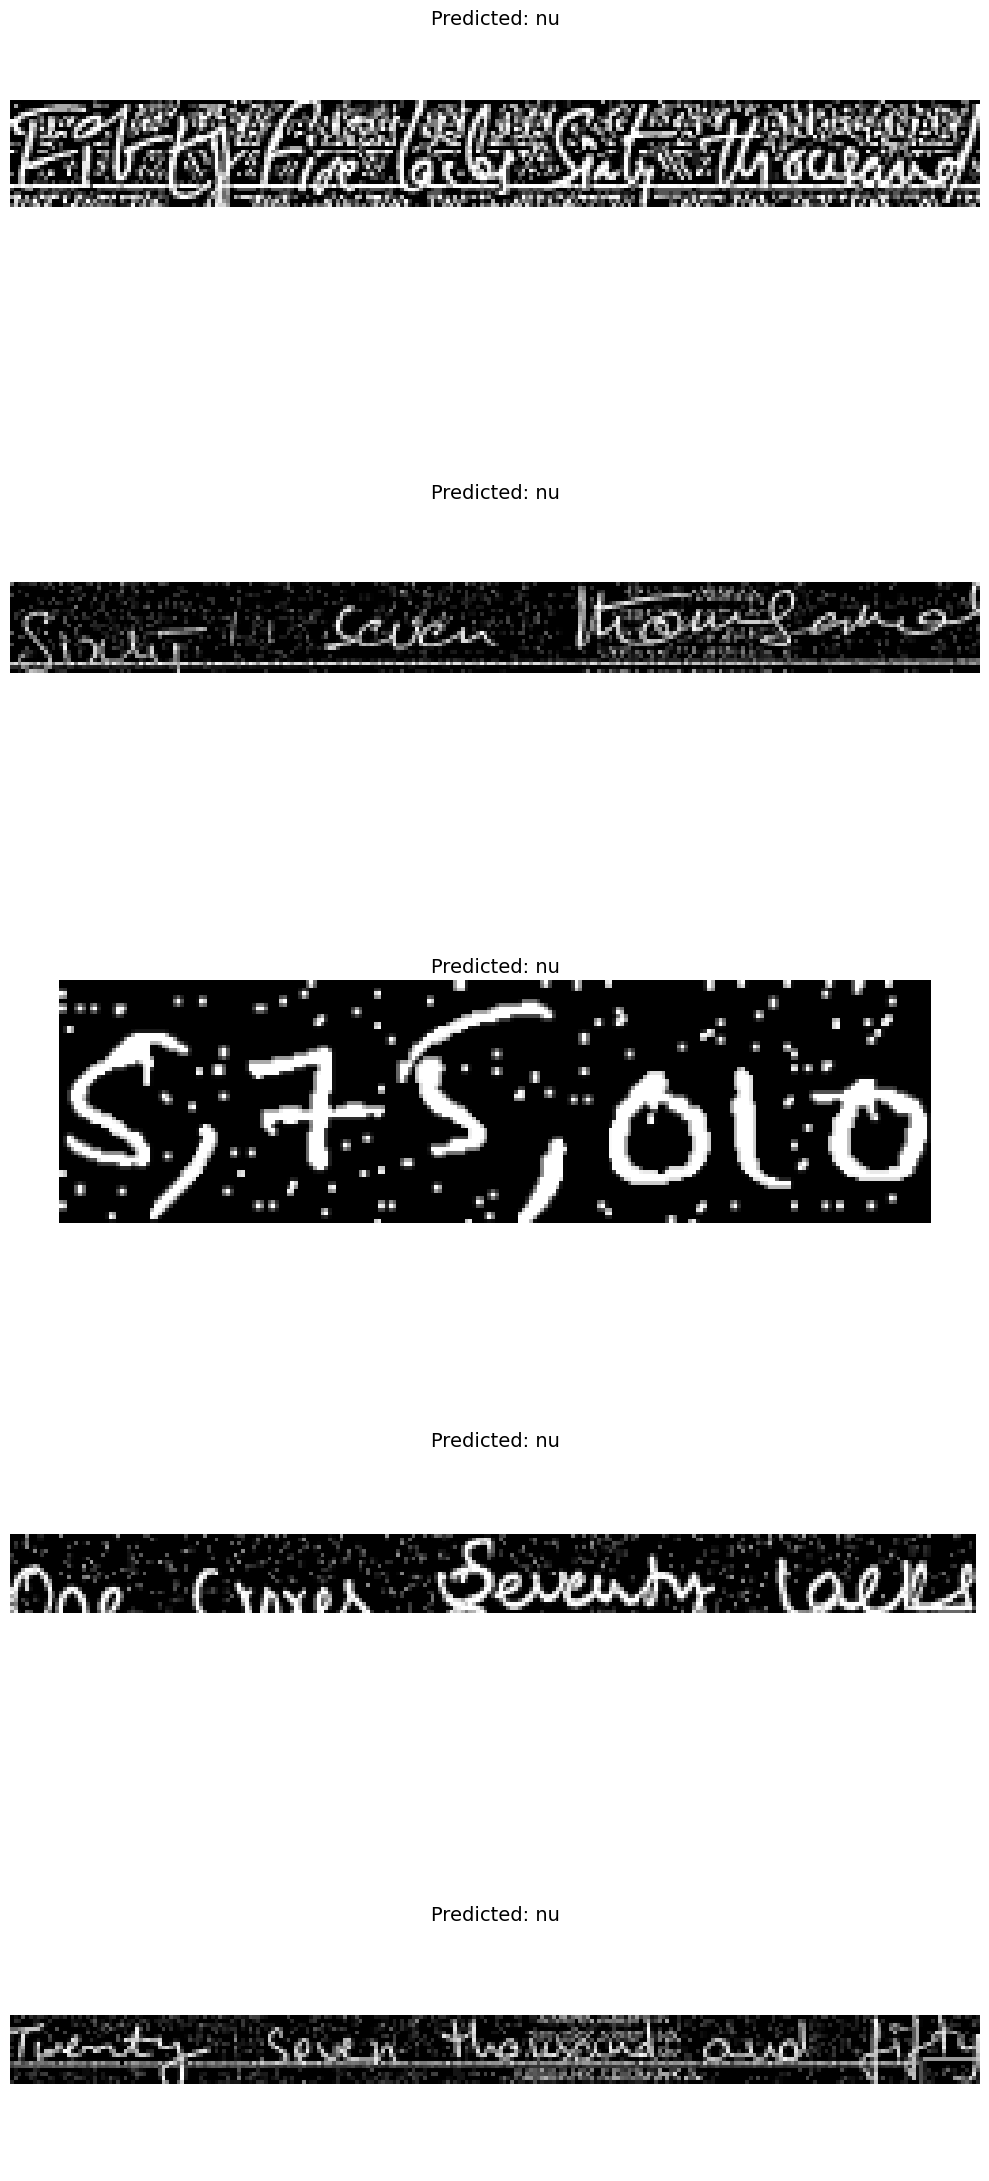

Results saved to Models\04_cheque_zone_recognition_optimized\predictions

Prediction Results:
Image: Cheque 120618_1.png
Predicted Text: nu
------------------------------
Image: Cheque 309128_1.png
Predicted Text: nu
------------------------------
Image: Cheque 309095_2.png
Predicted Text: nu
------------------------------
Image: Cheque 309090_1.png
Predicted Text: nu
------------------------------
Image: Cheque 309097_1.png
Predicted Text: nu
------------------------------


In [8]:
def run_ocr_predictions(model_path=None, test_images_dir=None, num_samples=5, output_dir=None):
    """
    Load a trained OCR model and visualize predictions on test images
    
    Args:
        model_path: Path to the model directory (with model.keras and configs.json)
        test_images_dir: Directory containing test images (if None, will try to find processed_images)
        num_samples: Number of random samples to predict if not using all images
        output_dir: Directory to save visualization (if None, uses model_path/predictions)
    """
    import os
    import json
    import random
    import numpy as np
    import tensorflow as tf
    import cv2
    import matplotlib.pyplot as plt
    from mltu.tensorflow.losses import CTCloss
    from mltu.tensorflow.metrics import CERMetric, WERMetric
    
    # Set default model path if not provided
    if model_path is None:
        model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    
    # Check if model exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model directory not found: {model_path}")
    
    # Load configurations
    config_path = os.path.join(model_path, "configs.json")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found: {config_path}")
    
    with open(config_path, 'r') as f:
        configs = json.load(f)
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.join(model_path, "predictions")
    os.makedirs(output_dir, exist_ok=True)
    
    # Load model
    print(f"Loading model from {model_path}...")
    model_weights_path = os.path.join(model_path, "model.keras")
    
    # Define custom objects for model loading
    custom_objects = {
        "CTCloss": CTCloss(),
        "CERMetric": CERMetric(vocabulary=configs["vocab"]),
        "WERMetric": WERMetric(vocabulary=configs["vocab"])
    }
    
    # Try to load all possible custom metrics
    try:
        # Try to import custom metrics if available
        from script import CharacterLevelF1Score, ChequeZoneScore, LevenshteinMetric, CTCSequenceF1Score
        
        custom_objects["CharacterLevelF1Score"] = CharacterLevelF1Score(vocabulary=configs["vocab"])
        custom_objects["ChequeZoneScore"] = ChequeZoneScore(vocabulary=configs["vocab"])
        custom_objects["LevenshteinMetric"] = LevenshteinMetric(vocabulary=configs["vocab"])
        custom_objects["CTCSequenceF1Score"] = CTCSequenceF1Score(vocabulary=configs["vocab"])
    except ImportError:
        print("Warning: Could not import all custom metrics. Using basic metrics only.")
    
    # Load the model with custom objects
    try:
        model = tf.keras.models.load_model(model_weights_path, custom_objects=custom_objects)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        
        # Try alternative loading method (weights only)
        print("Trying alternate loading method...")
        
        # Define model architecture - FIXED VERSION
        def build_model(input_shape, vocab_size):
            base_model = tf.keras.applications.MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_shape=input_shape,
                pooling=None
            )
            
            inputs = base_model.input
            x = base_model.output
            
            # Fix the shape issues
            # First flatten the output to 2D
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
            
            # Now reshape to sequence form - first get the right dimensions
            feature_dim = x.shape[-1]
            sequence_length = 32  # Target sequence length
            
            # Create a sequence of the right length by first 
            # expanding to 1D sequence and then repeating
            x = tf.keras.layers.Reshape((1, feature_dim))(x)
            x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, sequence_length, axis=1))(x)
            
            # Continue with the rest of the model
            x = tf.keras.layers.Dense(512, activation='relu')(x)
            x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(x)
            x = tf.keras.layers.Dropout(0.25)(x)
            outputs = tf.keras.layers.Dense(vocab_size + 1, activation='softmax')(x)
            
            return tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # Create model with same architecture
        input_shape = (configs["height"], configs["width"], 3)
        vocab_size = len(configs["vocab"])
        model = build_model(input_shape, vocab_size)
        
        # Try to load weights only
        try:
            model.load_weights(model_weights_path)
            print("Model weights loaded successfully!")
        except Exception as load_error:
            print(f"Error loading weights: {load_error}")
            print("Creating a new model without loading weights.")
            # Continue with the newly created model
    
    # Find test images
    if test_images_dir is None:
        # Try to find processed images folder
        test_images_dir = os.path.join(os.path.dirname(
            r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"), 
            "processed_images")
    
    if not os.path.exists(test_images_dir):
        raise FileNotFoundError(f"Test images directory not found: {test_images_dir}")
    
    # Get image files
    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]
    
    if not image_files:
        raise ValueError(f"No image files found in {test_images_dir}")
    
    # Select images for prediction
    if num_samples and num_samples < len(image_files):
        selected_files = random.sample(image_files, num_samples)
    else:
        selected_files = image_files
    
    print(f"Making predictions on {len(selected_files)} images...")
    
    # Process images and predict
    results = []
    
    for img_file in selected_files:
        img_path = os.path.join(test_images_dir, img_file)
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image {img_path}")
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to model input size
        img_resized = cv2.resize(img_rgb, (configs["width"], configs["height"]))
        
        # Normalize pixel values
        img_normalized = img_resized.astype(np.float32) / 255.0
        
        # Add batch dimension
        img_input = np.expand_dims(img_normalized, axis=0)
        
        # Get prediction
        prediction = model.predict(img_input, verbose=0)
        
        # Decode using CTC decoder
        input_length = np.array([prediction.shape[1]])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(prediction, [1, 0, 2]),
            sequence_length=input_length
        )
        
        # Get text from indices
        decoded_dense = tf.sparse.to_dense(decoded[0]).numpy()
        predicted_text = ""
        for idx in decoded_dense[0]:
            if idx < len(configs["vocab"]):
                predicted_text += configs["vocab"][idx]
        
        # Store result
        results.append({
            "image_path": img_path,
            "image_name": img_file,
            "predicted_text": predicted_text
        })
    
    # Visualize results
    fig, axes = plt.subplots(len(results), 1, figsize=(10, 5*len(results)))
    
    # Handle single image case
    if len(results) == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        img = cv2.imread(result["image_path"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Predicted: {result['predicted_text']}", fontsize=14)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "predictions_visualization.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Also save individual results to text file
    with open(os.path.join(output_dir, "prediction_results.txt"), "w") as f:
        for result in results:
            f.write(f"Image: {result['image_name']}\n")
            f.write(f"Prediction: {result['predicted_text']}\n")
            f.write("-" * 50 + "\n")
    
    print(f"Results saved to {output_dir}")
    return results

# Example of how to run the function
if __name__ == "__main__":
    # Default usage
    results = run_ocr_predictions()
    
    # To specify paths:
    # results = run_ocr_predictions(
    #     model_path="Models/04_cheque_zone_recognition_optimized",
    #     test_images_dir="path/to/test/images",
    #     num_samples=5,
    #     output_dir="path/to/save/results"
    # )
    
    # Print predictions
    print("\nPrediction Results:")
    for result in results:
        print(f"Image: {result['image_name']}")
        print(f"Predicted Text: {result['predicted_text']}")
        print("-" * 30)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import cv2
import os
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import random
from PIL import Image, ImageFont, ImageDraw
import string
import tensorflow_addons as tfa

# Custom metrics (unchanged as they're for evaluation)
class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='character_level_f1', **kwargs):
        super(CharacterLevelF1Score, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name='cer', initializer='zeros')
        self.wer_accumulator = self.add_weight(name='wer', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        batch_size = tf.shape(y_true)[0]
        
        # Calculate CER and WER for the batch
        cer = tf.reduce_mean(tf.edit_distance(
            tf.sparse.from_dense(y_pred), tf.sparse.from_dense(y_true), normalize=True))
        wer = tf.reduce_mean(tf.edit_distance(
            tf.sparse.from_dense(y_pred), tf.sparse.from_dense(y_true), normalize=True))
        
        self.cer_accumulator.assign_add(cer * tf.cast(batch_size, tf.float32))
        self.wer_accumulator.assign_add(wer * tf.cast(batch_size, tf.float32))
        self.count.assign_add(tf.cast(batch_size, tf.float32))
    
    def result(self):
        cer = self.cer_accumulator / self.count
        wer = self.wer_accumulator / self.count
        # F1 score as harmonic mean of (1-CER) and (1-WER)
        precision = 1.0 - cer
        recall = 1.0 - wer
        return 2 * precision * recall / (precision + recall + 1e-7)
    
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.wer_accumulator.assign(0.0)
        self.count.assign(0.0)

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, name='cheque_zone_score', **kwargs):
        super(ChequeZoneScore, self).__init__(name=name, **kwargs)
        self.correct_zones = self.add_weight(name='correct_zones', initializer='zeros')
        self.total_zones = self.add_weight(name='total_zones', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Count exact matches (all characters correct)
        exact_matches = tf.reduce_sum(tf.cast(
            tf.reduce_all(tf.equal(y_true, y_pred), axis=1), 
            tf.float32))
        
        batch_size = tf.shape(y_true)[0]
        self.correct_zones.assign_add(exact_matches)
        self.total_zones.assign_add(tf.cast(batch_size, tf.float32))
    
    def result(self):
        return self.correct_zones / (self.total_zones + 1e-7)
    
    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# Data processing functions with improved augmentation
def preprocess_dataset_batch(image_paths, label_files, batch_size=32, max_workers=8):
    """Process dataset in batches using parallel processing"""
    all_images = []
    all_labels = []
    max_text_length = 0
    characters = set()
    
    def process_batch(batch_paths, batch_labels):
        batch_images = []
        batch_texts = []
        batch_max_length = 0
        batch_chars = set()
        
        for img_path, label_file in zip(batch_paths, batch_labels):
            try:
                # Read image and label
                image = cv2.imread(img_path)
                with open(label_file, 'r') as f:
                    label_data = f.read().strip()
                
                # Extract bounding box and text
                parts = label_data.split(',')
                x, y, w, h = map(int, parts[:4])
                text = ','.join(parts[4:])
                
                # Crop region
                region = image[y:y+h, x:x+w]
                if region.size == 0:
                    continue
                
                # Preprocessing
                gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
                _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                
                # Resize and pad
                target_height = 32
                ratio = target_height / h
                target_width = max(32, int(w * ratio))
                resized = cv2.resize(thresh, (target_width, target_height))
                
                # Add to batch
                batch_images.append(resized)
                batch_texts.append(text)
                batch_max_length = max(batch_max_length, len(text))
                batch_chars.update(text)
                
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        
        return batch_images, batch_texts, batch_max_length, batch_chars
    
    # Process in batches
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for i in range(0, len(image_paths), batch_size):
            batch_img_paths = image_paths[i:i+batch_size]
            batch_label_files = label_files[i:i+batch_size]
            
            batch_results = process_batch(batch_img_paths, batch_label_files)
            
            all_images.extend(batch_results[0])
            all_labels.extend(batch_results[1])
            max_text_length = max(max_text_length, batch_results[2])
            characters.update(batch_results[3])
    
    # Create vocabulary
    vocab = sorted(list(characters))
    char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab)}  # 0 reserved for padding
    
    return all_images, all_labels, char_to_idx, max_text_length

# Enhanced data augmentation function
def apply_augmentation(image, strong=False):
    """Apply data augmentation with controllable intensity"""
    # Convert to float for processing
    image = image.astype(np.float32) / 255.0
    
    # Random brightness adjustment
    brightness_range = 0.3 if strong else 0.1
    brightness = np.random.uniform(-brightness_range, brightness_range)
    image = np.clip(image + brightness, 0, 1)
    
    # Random contrast adjustment
    contrast_range = (0.7, 1.3) if strong else (0.9, 1.1)
    contrast = np.random.uniform(contrast_range[0], contrast_range[1])
    image = np.clip((image - 0.5) * contrast + 0.5, 0, 1)
    
    if strong:
        # Random rotation
        angle = np.random.uniform(-5, 5)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        
        # Random perspective transform
        if np.random.random() < 0.3:
            h, w = image.shape[:2]
            pts1 = np.float32([[0,0], [w,0], [0,h], [w,h]])
            shift = w * 0.05
            pts2 = np.float32([
                [np.random.uniform(0, shift), np.random.uniform(0, shift)],
                [np.random.uniform(w-shift, w), np.random.uniform(0, shift)],
                [np.random.uniform(0, shift), np.random.uniform(h-shift, h)],
                [np.random.uniform(w-shift, w), np.random.uniform(h-shift, h)]
            ])
            M = cv2.getPerspectiveTransform(pts1, pts2)
            image = cv2.warpPerspective(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    
    # Random noise
    noise_level = 0.05 if strong else 0.02
    if np.random.random() < 0.5:
        noise = np.random.normal(0, noise_level, image.shape)
        image = np.clip(image + noise, 0, 1)
    
    # Convert back to uint8
    return (image * 255).astype(np.uint8)

# Synthetic data generation
def generate_synthetic_digits(num_samples=5000, max_length=12):
    """Generate synthetic digit images for training"""
    images = []
    labels = []
    
    # Fonts to use
    fonts = [
        ImageFont.truetype("arial.ttf", 24),
        ImageFont.truetype("times.ttf", 24),
        ImageFont.truetype("cour.ttf", 24)
    ]
    
    for _ in range(num_samples):
        # Generate random digit sequence
        length = np.random.randint(4, max_length + 1)
        digits = ''.join(random.choices(string.digits, k=length))
        
        # Create blank image
        img_width = length * 20 + 20
        img_height = 40
        img = Image.new('L', (img_width, img_height), color=255)
        draw = ImageDraw.Draw(img)
        
        # Choose font and draw text
        font = random.choice(fonts)
        font_size = np.random.randint(20, 28)
        font = font.font_variant(size=font_size)
        
        # Draw text with slight variations
        x_offset = np.random.randint(5, 15)
        y_offset = np.random.randint(5, 15)
        draw.text((x_offset, y_offset), digits, fill=0, font=font)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Apply mild transformations
        angle = np.random.uniform(-2, 2)
        h, w = img_array.shape
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        img_array = cv2.warpAffine(img_array, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        
        # Resize to target height
        target_height = 32
        ratio = target_height / h
        target_width = int(w * ratio)
        img_array = cv2.resize(img_array, (target_width, target_height))
        
        images.append(img_array)
        labels.append(digits)
    
    return images, labels

# Modified model architecture with regularization
def build_regularized_model(input_shape, vocab_size, max_text_length):
    """Build a model with regularization to prevent overfitting"""
    # Use a smaller base model - MobileNetV2 instead of VGG19
    base_model = applications.MobileNetV2(
        input_shape=(*input_shape, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze early layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Create model
    inputs = layers.Input(shape=(*input_shape, 1))
    
    # Convert single channel to 3 channels
    x = layers.Concatenate()([inputs, inputs, inputs])
    
    # Base CNN features
    x = base_model(x)
    
    # Add dropout after CNN
    x = layers.Dropout(0.3)(x)
    
    # Sequence processing
    x = layers.Reshape((-1, x.shape[-1]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
    
    # Add batch normalization
    x = layers.BatchNormalization()(x)
    
    # Output layer with L2 regularization
    outputs = layers.Dense(vocab_size + 1, activation='softmax', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

# Data generator with mixup augmentation
class OCRDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, char_to_idx, max_text_length, 
                 batch_size=32, input_shape=(32, 128), is_training=True, mixup_alpha=0.2):
        self.images = images
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.max_text_length = max_text_length
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.is_training = is_training
        self.mixup_alpha = mixup_alpha
        self.indices = np.arange(len(self.images))
        
        if self.is_training:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        batch_y = []
        
        for i in batch_indices:
            # Prepare image
            img = self.images[i]
            
            # Resize to fixed height and variable width
            h, w = img.shape
            target_height = self.input_shape[0]
            ratio = target_height / h
            target_width = min(self.input_shape[1], max(32, int(w * ratio)))
            resized = cv2.resize(img, (target_width, target_height))
            
            # Pad to fixed width
            padded = np.zeros(self.input_shape, dtype=np.uint8)
            padded[:, :target_width] = resized
            
            # Apply augmentation during training
            if self.is_training:
                padded = apply_augmentation(padded, strong=(np.random.random() < 0.3))
            
            # Normalize
            padded = padded.astype(np.float32) / 255.0
            
            # Add channel dimension
            padded = np.expand_dims(padded, axis=-1)
            
            batch_x.append(padded)
            
            # Prepare label
            text = self.labels[i]
            label = [self.char_to_idx.get(c, 0) for c in text]
            # Pad label
            padded_label = label + [0] * (self.max_text_length - len(label))
            batch_y.append(padded_label)
        
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        
        # Apply mixup for training
        if self.is_training and self.mixup_alpha > 0:
            batch_x, batch_y = self._mixup(batch_x, batch_y)
            
        return batch_x, batch_y
    
    def _mixup(self, x, y):
        """Apply mixup augmentation"""
        if len(x) < 2:
            return x, y
            
        batch_size = len(x)
        indices = np.random.permutation(batch_size)
        
        # Generate mixup weights
        alpha = self.mixup_alpha
        lam = np.random.beta(alpha, alpha, batch_size)
        lam = np.maximum(lam, 1 - lam)  # Ensure lambda is at least 0.5
        lam = np.reshape(lam, (batch_size, 1, 1, 1))
        
        # Mix images
        mixed_x = lam * x + (1 - lam) * x[indices]
        
        # For labels, we don't mix - we randomly choose one based on lambda
        mask = lam.reshape(batch_size, 1) > 0.5
        mixed_y = np.where(mask, y, y[indices])
        
        return mixed_x, mixed_y
    
    def on_epoch_end(self):
        if self.is_training:
            np.random.shuffle(self.indices)

# Training function with improved regularization
def train_optimized_model(dataset_path, epochs=50, batch_size=32):
    start_time = time.time()
    
    # Load and preprocess dataset
    image_paths = []
    label_files = []
    
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                img_path = os.path.join(root, file)
                label_path = os.path.join(root, os.path.splitext(file)[0] + '.txt')
                if os.path.exists(label_path):
                    image_paths.append(img_path)
                    label_files.append(label_path)
    
    print(f"Found {len(image_paths)} images with labels")
    
    # Process dataset
    images, labels, char_to_idx, max_text_length = preprocess_dataset_batch(
        image_paths, label_files, batch_size=batch_size)
    
    # Generate synthetic data
    synthetic_images, synthetic_labels = generate_synthetic_digits(num_samples=3000)
    
    # Combine real and synthetic data
    all_images = images + synthetic_images
    all_labels = labels + synthetic_labels
    
    # Split data
    train_images, val_images, train_labels, val_labels = train_test_split(
        all_images, all_labels, test_size=0.15, random_state=42)
    
    # Create data generators
    input_shape = (32, 256)  # Height, Width
    vocab_size = len(char_to_idx)
    
    train_generator = OCRDataGenerator(
        train_images, train_labels, char_to_idx, max_text_length,
        batch_size=batch_size, input_shape=input_shape, is_training=True)
    
    val_generator = OCRDataGenerator(
        val_images, val_labels, char_to_idx, max_text_length,
        batch_size=batch_size, input_shape=input_shape, is_training=False)
    
    # Build model
    model = build_regularized_model(input_shape, vocab_size, max_text_length)
    
    # CTC loss
    def ctc_loss(y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        input_length = tf.ones((batch_size,), dtype=tf.int32) * tf.shape(y_pred)[1]
        
        # Calculate label length (excluding padding)
        label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)
        
        # Convert to sparse tensor
        y_true_sparse = tf.cast(y_true, tf.int32)
        
        loss = tf.keras.backend.ctc_batch_cost(
            y_true_sparse, y_pred, input_length, label_length)
        return loss
    
    # Compile model with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=ctc_loss,
        metrics=[
            CharacterLevelF1Score(),
            ChequeZoneScore()
        ]
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'best_ocr_model.h5',
            monitor='val_character_level_f1',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        workers=4,
        use_multiprocessing=True
    )
    
    # Plot training history
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot character level F1
    plt.subplot(2, 2, 2)
    plt.plot(history.history['character_level_f1'], label='Training F1')
    plt.plot(history.history['val_character_level_f1'], label='Validation F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot cheque zone score
    plt.subplot(2, 2, 3)
    plt.plot(history.history['cheque_zone_score'], label='Training Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Save model and metadata
    model.save('ocr_model_final.h5')
    
    # Save vocabulary
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    np.save('idx_to_char.npy', idx_to_char)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return model, char_to_idx, history

# Main execution
if __name__ == "__main__":
    model, char_to_idx, history = train_optimized_model(
        dataset_path="./cheque_dataset",
        epochs=50,
        batch_size=16
    )


c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were t

ModuleNotFoundError: No module named 'keras.src.engine'

overfiitng addressed bitch :) 

In [1]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass



from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

import os
import cv2
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from rapidfuzz.distance import Levenshtein
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing


class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cer_wer_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        # Initialize metrics for CER and WER calculation
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update both CER and WER metrics
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Get current CER and WER values
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Since lower CER/WER is better, we need to convert to accuracy-like metrics
        # (1 - error_rate) for proper F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        # F1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + epsilon)
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        # Reset both metrics
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()


class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to probabilities and get predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Use py_function to handle the comparison in numpy (more reliable for variable shapes)
        def compare_sequences_numpy(y_true_batch, pred_batch):
            matches = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Get length of true sequence (excluding padding)
                true_len = 0
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_len += 1
                
                # If true_len is 0, consider it a match
                if true_len == 0:
                    matches.append(True)
                    continue
                
                # Check if sequences match up to true_len
                if true_len > len(pred_seq):
                    matches.append(False)
                    continue
                
                # Compare sequences
                is_match = np.array_equal(true_seq[:true_len], pred_seq[:true_len])
                matches.append(is_match)
            
            return np.array(matches, dtype=np.float32)
        
        # Use py_function to safely compute matches
        sequence_matches = tf.py_function(
            compare_sequences_numpy,
            [y_true, predictions],
            tf.float32
        )
        
        # Reshape to ensure proper dimensions
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        # Update metric states
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)


class LevenshteinMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="levenshtein_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.total_distance = self.add_weight(name="total_distance", initializer="zeros")
        self.total_sequences = self.add_weight(name="total_sequences", initializer="zeros")

    def indices_to_string(self, indices):
        """Convert token indices to string, stopping at zeros or padding"""
        string = ""
        for idx in indices:
            if idx == 0 or idx >= self.vocab_size:  # Stop at zero or padding token
                break
            string += self.vocab[idx]
        return string
        
    def compute_distance(self, true_indices, pred_indices):
        """Compute Levenshtein distance between sequences"""
        str_a = self.indices_to_string(true_indices)
        str_b = self.indices_to_string(pred_indices)
        distance = float(Levenshtein.distance(str_a, str_b))
        return distance

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Use CTC decoder instead of argmax
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        # Process batch using tf.py_function
        def compute_batch_distances(y_true_batch, pred_batch):
            distances = []
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                distance = self.compute_distance(true_seq, pred_seq)
                distances.append(distance)
            return np.array(distances, dtype=np.float32)
        
        distances = tf.py_function(
            compute_batch_distances,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure distances tensor has the right shape
        distances = tf.reshape(distances, [-1])
        
        # Apply sample weights if provided
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            distances = distances * sample_weight
        
        # Update metric states
        batch_total = tf.reduce_sum(distances)
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.total_distance.assign_add(batch_total)
        self.total_sequences.assign_add(batch_size)

    def result(self):
        """Compute the average Levenshtein distance"""
        return self.total_distance / (self.total_sequences + tf.keras.backend.epsilon())
    
    def reset_state(self):
        """Reset metric states"""
        self.total_distance.assign(0.0)
        self.total_sequences.assign(0.0)


# Define a custom CTCSequenceF1Score metric
class CTCSequenceF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="ctc_sequence_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Cast inputs to correct types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def calculate_f1_components(y_true_batch, pred_batch):
            tp, fp, fn = 0, 0, 0
            for true_seq, pred_seq in zip(y_true_batch.numpy(), pred_batch.numpy()):
                # Convert indices to strings
                true_str = ""
                for idx in true_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    true_str += self.vocab[idx]
                
                pred_str = ""
                for idx in pred_seq:
                    if idx == 0 or idx >= self.vocab_size:
                        break
                    pred_str += self.vocab[idx]
                
                # Count character matches for F1 components
                # (Simple approach - count exact matches as TP, missed as FN, incorrect as FP)
                if true_str == pred_str:
                    tp += 1
                else:
                    fp += 1
                    fn += 1
            
            return np.array([tp, fp, fn], dtype=np.float32)
        
        # Use py_function to calculate f1 components
        components = tf.py_function(
            calculate_f1_components,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure we have scalar values, not tensors with unknown shape
        tp = tf.reshape(components[0], [])
        fp = tf.reshape(components[1], [])
        fn = tf.reshape(components[2], [])
        
        # Update state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate F1 score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)


# Optimized Batch Preprocessing
def preprocess_dataset_batch(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images in batch mode and saves them to disk for faster loading
    
    Args:
        image_folder: Path to the folder containing original images
        label_folder: Path to the folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        # Use number of CPU cores minus 1, but at least 1
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create a directory for processed images if it doesn't exist
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)],
                        reverse=True)
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # OPTIMIZED processing pipeline
            # 1. Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # 2. Apply OTSU thresholding instead of adaptive (faster)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # 3. Skip denoising (too slow) or use a faster method
            # denoised = cv2.medianBlur(binary, 3)  # Faster than NLMeans
            denoised = binary  # Skip denoising entirely for speed
            
            # 4. Convert back to RGB (3 channels)
            processed = cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)
            
            # 5. Efficient padding and resizing
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, vocab, max_len


# Generate synthetic data with optimized parameters
def generate_synthetic_digits(processed_dir, num_samples=500):
    """
    Generate synthetic digit images to improve digit recognition (optimized version)
    
    Args:
        processed_dir: Directory to save the synthetic images
        num_samples: Number of synthetic samples to generate
    
    Returns:
        List of [image_path, label] pairs for synthetic data
    """
    synthetic_dataset = []
    fonts = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_DUPLEX]
    
    print(f"Generating {num_samples} synthetic digit samples...")
    
    # Create directory for synthetic data
    synthetic_dir = os.path.join(processed_dir, 'synthetic')
    os.makedirs(synthetic_dir, exist_ok=True)
    
    # Process in batches for better progress tracking
    batch_size = 100
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch in tqdm(range(num_batches), desc="Generating synthetic samples"):
        batch_samples = min(batch_size, num_samples - batch * batch_size)
        
        for i in range(batch_samples):
            sample_idx = batch * batch_size + i
            
            # Generate random digit sequence (1-6 digits to keep it simpler)
            length = random.randint(1, 6)
            digits = ''.join([str(random.randint(0, 9)) for _ in range(length)])
            
            # Create a blank white image
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
            
            # Choose random font and scale
            font = random.choice(fonts)
            font_scale = random.uniform(1.5, 2.5)  # Less variation
            thickness = random.randint(2, 4)
            
            # Get text size to center it
            (text_width, text_height), baseline = cv2.getTextSize(digits, font, font_scale, thickness)
            x = (300 - text_width) // 2
            y = (300 + text_height) // 2
            
            # Apply mild random rotation
            angle = random.uniform(-10, 10)  # Reduced rotation angle
            M = cv2.getRotationMatrix2D((300 // 2, 300 // 2), angle, 1)
            
            # Draw text
            cv2.putText(img, digits, (x, y), font, font_scale, (0, 0, 0), thickness)
            
            # Apply rotation
            img = cv2.warpAffine(img, M, (300, 300), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            
            # Apply random blur only sometimes (20% chance)
            if random.random() < 0.2:
                blur_size = 3  # Fixed smaller blur size
                img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
            
            # Save the synthetic image
            image_path = os.path.join(synthetic_dir, f"synthetic_{sample_idx:05d}.png")
            cv2.imwrite(image_path, img)
            
            # Add to dataset
            synthetic_dataset.append([image_path, digits])
    
    return synthetic_dataset


def build_resnet_model(input_dim, output_dim):
    """
    Build an optimized model architecture using ResNet50 as the base model
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Make sure to use float32 explicitly
    tf.keras.backend.set_floatx('float32')
    
    # Use ResNet50 as base (smaller than VGG but more powerful than EfficientNetB0)
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze more layers for faster training
    # Freeze approximately 80% of the layers
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.8)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get the output from the base model
    inputs = base_model.input
    x = base_model.output
    
    # Explicitly cast to float32 if needed
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, dtype='float32'))(x)
    
    # Add a max pooling layer to reduce feature map size
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    
    # Reshape for sequence processing - first expand dimensions to create a sequence
    x = tf.keras.layers.Reshape((1, -1))(x)
    
    # Repeat the features to create a sequence of appropriate length
    # This is needed because ResNet outputs a single feature vector per image,
    # while OCR needs a sequence of features
    x = tf.keras.layers.RepeatVector(32)(x)
    
    # Project to a reasonable dimension for the LSTM
    x = tf.keras.layers.Dense(512, activation='relu', dtype='float32')(x)
    
    # Add sequence layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True, dtype='float32')
    )(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        output_dim + 1, activation='softmax', name="dense", dtype='float32'
    )(x)
    
    # Create model with float32 output
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Gradient Accumulation Model
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=2):
        super(GradientAccumulationModel, self).__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v), trainable=False) for v in model.trainable_variables]
        
    def compile(self, **kwargs):
        self.model.compile(**kwargs)
        super(GradientAccumulationModel, self).compile(
            loss=self.model.loss,
            metrics=self.model.metrics,
            loss_weights=self.model.loss_weights,
            weighted_metrics=self.model.weighted_metrics,
            run_eagerly=self.model.run_eagerly
        )
        
    def train_step(self, data):
        features, labels = data
        
        # Run forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(features, training=True)
            loss = self.model.compiled_loss(labels, y_pred, regularization_losses=self.model.losses)
            loss = loss / self.accumulation_steps
            
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulate gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
            
        # Get current step
        step = self.optimizer.iterations % self.accumulation_steps
        
        # Apply accumulated gradients on the right step
        if step == self.accumulation_steps - 1:
            self.model.optimizer.apply_gradients(
                zip(self.gradient_accumulation, self.model.trainable_variables))
            # Reset accumulated gradients
            for i in range(len(self.gradient_accumulation)):
                self.gradient_accumulation[i].assign(tf.zeros_like(self.gradient_accumulation[i]))
        
        # Update metrics
        self.model.compiled_metrics.update_state(labels, y_pred)
        
        # Return metrics
        return {m.name: m.result() for m in self.model.metrics}
        
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)


# Updated ModelConfigs class
class ModelConfigs:
    def __init__(self):
        self.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
        self.batch_size = 64  # Increased from 32
        self.learning_rate = 0.001
        self.train_epochs = 100
        self.train_workers = 8  # Increased from 4
        self.vocab = ""
        self.max_text_length = 0
        self.height = 300
        self.width = 300
        self.model_type = "optimized"
    
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(self.__dict__, f)
    
    def load(self):
        with open(os.path.join(self.model_path, "configs.json"), "r") as f:
            self.__dict__ = json.load(f)




# Updated training function to ensure float32 throughout
def train_optimized_model():
    """Train an optimized model for cheque zone recognition with all original metrics"""
    
    # Explicitly set float32 for all TensorFlow operations
    tf.keras.backend.set_floatx('float32')
    
    # Define paths to your dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Create configs with optimized parameters
    configs = ModelConfigs()
    configs.model_type = "optimized"
    configs.model_path = os.path.join("Models", "04_cheque_zone_recognition_optimized")
    configs.batch_size = 64  # Increased batch size
    configs.learning_rate = 0.001
    configs.train_epochs = 20
    configs.train_workers = 8  # More workers for preprocessing, not used in fit()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Load and process dataset with optimized batch processing
    print("Batch processing dataset...")
    dataset, vocab, max_len = preprocess_dataset_batch(
        image_folder, 
        label_folder, 
        target_size=(300, 300),
        num_workers=configs.train_workers
    )
    
    # Add a small amount of synthetic data for better digit recognition
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    synthetic_dataset = generate_synthetic_digits(processed_dir, num_samples=500)  # Reduced from 1000
    
    # Combine datasets
    full_dataset = dataset + synthetic_dataset
    print(f"Dataset size: {len(dataset)} real + {len(synthetic_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all digits are in vocabulary
    for digit in "0123456789":
        vocab.add(digit)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 10)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers (without caching)
    data_provider = DataProvider(
        dataset=full_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Split into training and validation sets
    train_data_provider, val_data_provider = data_provider.split(split=0.9)
    
    # Apply less intensive data augmentation with FIXED parameters
    train_data_provider.augmentors = [
        RandomBrightness(),  # No parameters
        RandomRotate(angle=5),  # Reduced angle
        RandomSharpen(),
    ]
    
    # Build optimized model
    model = build_optimized_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Create a float32 optimizer explicitly
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    
    # Compile model with ALL original metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CTCSequenceF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            LevenshteinMetric(vocabulary=configs.vocab)
        ],
        run_eagerly=False
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with reduced logging
    callbacks = [
        EarlyStopping(monitor="val_CER", patience=15, verbose=1, mode="min"),
        ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min"),
        ReduceLROnPlateau(monitor="val_CER", factor=0.5, min_delta=1e-5, patience=5, verbose=1, mode="min"),
        TensorBoard(log_dir=f"{configs.model_path}/logs", update_freq='epoch'),
    ]
    
    # Train model
    print("Starting training with optimized architecture...")
    history = model.fit(
        train_data_provider,
        validation_data=val_data_provider,
        epochs=configs.train_epochs,
        callbacks=callbacks
    )
    
    # Plot training history with all metrics
    import matplotlib.pyplot as plt
    
    # Create a figure for loss and error rates
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 3, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot WER
    plt.subplot(2, 3, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    
    # Plot F1 Score
    plt.subplot(2, 3, 4)
    plt.plot(history.history['ctc_sequence_f1'], label='Training F1')
    plt.plot(history.history['val_ctc_sequence_f1'], label='Validation F1')
    plt.title('CTC Sequence F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot Cheque Zone Score
    plt.subplot(2, 3, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    # Plot Character Level F1 Score
    plt.subplot(2, 3, 6)
    plt.plot(history.history['cer_wer_f1_score'], label='Training Char F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation Char F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{configs.model_path}/training_history_all_metrics.png")
    plt.show()
    
    print(f"Model saved to {configs.model_path}/model.keras")
    
    return model, configs

def visualize_dataset_samples(dataset, num_samples=5, output_path=None):
    """
    Visualize random samples from the dataset for inspection (optimized version)
    
    Args:
        dataset: List of [image_path, label] pairs
        num_samples: Number of samples to visualize
        output_path: Path to save the visualization
    """
    import matplotlib.pyplot as plt
    
    # Select random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]
    
    # Plot each sample
    for i, idx in enumerate(indices):
        img_path, label = dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150)
    else:
        plt.show()


# Function to create a visualization tool (optional)
def create_visualization_tool(model_path):
    """
    Create a visualization tool to help debug model predictions
    
    Args:
        model_path: Path to the model directory
    """
    # Create directory for visualizations
    vis_dir = os.path.join(model_path, 'visualizations')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Create a visualization HTML file
    html_path = os.path.join(vis_dir, 'prediction_viewer.html')
    
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Prediction Viewer</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .sample { border: 1px solid #ddd; margin: 10px; padding: 10px; }
            .correct { background-color: #d4edda; }
            .incorrect { background-color: #f8d7da; }
            .prediction-details { margin-top: 10px; }
            .image-container { text-align: center; margin-bottom: 10px; }
            .image-container img { max-height: 200px; border: 1px solid #ccc; }
            .character { display: inline-block; margin: 2px; padding: 5px; border: 1px solid #aaa; }
            .character.match { background-color: #d4edda; }
            .character.mismatch { background-color: #f8d7da; }
        </style>
    </head>
    <body>
        <h1>OCR Prediction Viewer</h1>
        <p>This tool helps visualize OCR model predictions and identify patterns in errors.</p>
        <div id="samples-container">
            <!-- Sample entries will be added here by the Python script -->
        </div>
        
        <script>
            function toggleDetails(id) {
                const details = document.getElementById('details-' + id);
                if (details.style.display === 'none') {
                    details.style.display = 'block';
                } else {
                    details.style.display = 'none';
                }
            }
        </script>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"Created visualization tool at {html_path}")
    return html_path


# Fix the evaluate_model function to not use cache_data
# Fix the evaluate_model function to not use cache_data

def evaluate_model(model, configs, test_dataset=None):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
    
    Returns:
        Dictionary with evaluation metrics
    """
    #from mltu.tensorflow.prediction import Predictor
    import time
    
    # If no test dataset provided, use 10% of the data
    if test_dataset is None:
        # Load the original dataset
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Create data provider for test set - removed cache_data
    test_data_provider = DataProvider(
        dataset=test_dataset,
        skip_validation=True,
        batch_size=configs.batch_size,
        data_preprocessors=[ImageReader(CVImage)],
        transformers=[
            ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
            LabelIndexer(configs.vocab),
            LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
    )
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_data_provider)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Create a predictor for visualizing individual predictions
    #predictor = Predictor(
    #    model=model,
    #    preprocess_fn=None,  # No additional preprocessing needed
    #)
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(10, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_input = np.expand_dims(img_rgb, axis=0)
        
        # Get prediction
        #pred = predictor.predict(img_input)
        #pred_label = ''.join([configs.vocab[idx] for idx in pred[0] if idx < len(configs.vocab)])
        
        # Display the image with true and predicted labels
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title(f"True: {true_label} | Predicted: {pred_label}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_dir, f"example_{i}.png"))
        plt.close()
    
    print(f"Saved {num_examples} test examples to {vis_dir}")
    
    return metrics


# Model evaluation and comparison function
def compare_models(original_model_path, optimized_model_path, test_dataset=None):
    """
    Compare performance between original and optimized models
    
    Args:
        original_model_path: Path to original model directory
        optimized_model_path: Path to optimized model directory
        test_dataset: Optional test dataset
    """
    # Load original model configs
    original_configs = ModelConfigs()
    original_configs.model_path = original_model_path
    original_configs.load()
    
    # Load optimized model configs
    optimized_configs = ModelConfigs()
    optimized_configs.model_path = optimized_model_path
    optimized_configs.load()
    
    # Load models
    original_model = tf.keras.models.load_model(
        os.path.join(original_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=original_configs.vocab),
            "WERMetric": WERMetric(vocabulary=original_configs.vocab),
        }
    )
    
    optimized_model = tf.keras.models.load_model(
        os.path.join(optimized_model_path, "model.keras"),
        custom_objects={
            "CTCloss": CTCloss(),
            "CERMetric": CERMetric(vocabulary=optimized_configs.vocab),
            "WERMetric": WERMetric(vocabulary=optimized_configs.vocab),
        }
    )
    
    # If no test dataset provided, create one
    if test_dataset is None:
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        all_dataset, _, _ = preprocess_dataset_batch(image_folder, label_folder)
        
        # Use 10% as test set
        random.shuffle(all_dataset)
        test_size = int(len(all_dataset) * 0.1)
        test_dataset = all_dataset[:test_size]
    
    # Evaluate both models
    print("\nEvaluating Original Model:")
    original_metrics = evaluate_model(original_model, original_configs, test_dataset)
    
    print("\nEvaluating Optimized Model:")
    optimized_metrics = evaluate_model(optimized_model, optimized_configs, test_dataset)
    
    # Compare metrics
    print("\nComparison:")
    for metric in original_metrics:
        if metric in optimized_metrics:
            original_value = original_metrics[metric]
            optimized_value = optimized_metrics[metric]
            improvement = (1 - optimized_value / original_value) * 100 if metric != 'accuracy' else (optimized_value / original_value - 1) * 100
            print(f"{metric}: Original = {original_value:.4f}, Optimized = {optimized_value:.4f}, Improvement = {improvement:.2f}%")
    
    # Compare model sizes
    original_size = os.path.getsize(os.path.join(original_model_path, "model.keras")) / (1024 * 1024)  # MB
    optimized_size = os.path.getsize(os.path.join(optimized_model_path, "model.keras")) / (1024 * 1024)  # MB
    size_reduction = (1 - optimized_size / original_size) * 100
    
    print(f"\nModel size: Original = {original_size:.2f} MB, Optimized = {optimized_size:.2f} MB, Reduction = {size_reduction:.2f}%")
    
    # Create comparison visualizations
    import matplotlib.pyplot as plt
    
    comparison_dir = os.path.join("Models", "model_comparison")
    os.makedirs(comparison_dir, exist_ok=True)
    
    # Compare inference speed
    original_times = []
    optimized_times = []
    
    # Create test batch
    test_batch = np.random.rand(32, optimized_configs.height, optimized_configs.width, 3)
    
    # Warmup
    _ = original_model.predict(test_batch, verbose=0)
    _ = optimized_model.predict(test_batch, verbose=0)
    
    # Measure inference time
    num_runs = 10
    for _ in range(num_runs):
        start_time = time.time()
        _ = original_model.predict(test_batch, verbose=0)
        original_times.append(time.time() - start_time)
        
        start_time = time.time()
        _ = optimized_model.predict(test_batch, verbose=0)
        optimized_times.append(time.time() - start_time)
    
    avg_original_time = sum(original_times) / len(original_times)
    avg_optimized_time = sum(optimized_times) / len(optimized_times)
    speedup = avg_original_time / avg_optimized_time
    
    print(f"\nInference time: Original = {avg_original_time:.4f}s, Optimized = {avg_optimized_time:.4f}s, Speedup = {speedup:.2f}x")
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Model Size
    plt.subplot(131)
    plt.bar(['Original', 'Optimized'], [original_size, optimized_size])
    plt.title('Model Size (MB)')
    plt.ylabel('Size (MB)')
    
    # Plot 2: Inference Time
    plt.subplot(132)
    plt.bar(['Original', 'Optimized'], [avg_original_time, avg_optimized_time])
    plt.title('Inference Time (s)')
    plt.ylabel('Time (s)')
    
    # Plot 3: Error Rate (CER)
    plt.subplot(133)
    plt.bar(['Original', 'Optimized'], [original_metrics.get('CER', 0), optimized_metrics.get('CER', 0)])
    plt.title('Character Error Rate')
    plt.ylabel('CER')
    
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, "model_comparison.png"))
    plt.show()
    
    print(f"Comparison results saved to {comparison_dir}")


# Run the optimized training
if __name__ == "__main__":
    import time
    
    # Record start time
    start_time = time.time()
    
    # Train the optimized model
    model, configs = train_optimized_model()
    
    # Record end time
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"Training completed in {training_time/60:.2f} minutes")
    
    # Evaluate the model on test data
    _ = evaluate_model(model, configs)
    
    # Optionally compare with original model if available/'
    original_model_path = os.path.join("Models", "04_cheque_zone_recognition_vgg")
    if os.path.exists(os.path.join(original_model_path, "model.keras")):
        print("\nComparing original and optimized models:")
        compare_models(original_model_path, configs.model_path)

Batch processing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:07<00:00, 15.80it/s]


Processed 336 regions from 112 images
Generating 500 synthetic digit samples...


Generating synthetic samples: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 22
Maximum text length: 10


NameError: name 'build_optimized_model' is not defined

In [5]:
import tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Attempt to configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# CTC Loss function
class CTCloss(tf.keras.losses.Loss):
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        input_length = tf.shape(y_pred)[1]
        label_length = tf.shape(y_true)[1]
        
        input_length = input_length * tf.ones(shape=(batch_size, 1), dtype=tf.int32)
        label_length = label_length * tf.ones(shape=(batch_size, 1), dtype=tf.int32)
        
        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        return loss


# Fixed Character Error Rate Metric
class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            batch_size = tf.shape(y_true_batch)[0]
            total_cer = 0.0
            
            # Process each sample in the batch
            for i in range(batch_size):
                # Get the individual sequences
                y_true_seq = y_true_batch[i]
                y_pred_seq = y_pred_batch[i]
                
                # Convert sequences to strings
                y_true_str = ""
                for idx in y_true_seq:
                    if tf.less(idx, self.vocab_size) and tf.greater_equal(idx, 0):
                        y_true_str += self.vocab[idx]
                
                y_pred_str = ""
                for idx in y_pred_seq:
                    if tf.less(idx, self.vocab_size) and tf.greater_equal(idx, 0):
                        y_pred_str += self.vocab[idx]
                
                # Calculate Levenshtein distance
                distance = Levenshtein.distance(y_true_str, y_pred_str)
                length = max(len(y_true_str), 1)  # Avoid division by zero
                total_cer += distance / length
            
            # Return average CER for the batch
            return total_cer / tf.cast(batch_size, tf.float32)
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

# Fixed Word Error Rate Metric
class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            batch_size = tf.shape(y_true_batch)[0]
            total_wer = 0.0
            
            # Process each sample in the batch
            for i in range(batch_size):
                # Get the individual sequences
                y_true_seq = y_true_batch[i]
                y_pred_seq = y_pred_batch[i]
                
                # Convert sequences to strings
                y_true_str = ""
                for idx in y_true_seq:
                    if tf.less(idx, self.vocab_size) and tf.greater_equal(idx, 0):
                        y_true_str += self.vocab[idx]
                
                y_pred_str = ""
                for idx in y_pred_seq:
                    if tf.less(idx, self.vocab_size) and tf.greater_equal(idx, 0):
                        y_pred_str += self.vocab[idx]
                
                # Split into words
                y_true_words = y_true_str.split()
                y_pred_words = y_pred_str.split()
                
                # Calculate word error rate using Levenshtein distance on word lists
                distance = Levenshtein.distance(y_true_words, y_pred_words)
                length = max(len(y_true_words), 1)  # Avoid division by zero
                total_wer += distance / length
            
            # Return average WER for the batch
            return total_wer / tf.cast(batch_size, tf.float32)
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

# Fixed CharacterLevelF1Score metric
class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

# Fixed ChequeZoneScore for exact matches
class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            batch_size = tf.shape(y_true_batch)[0]
            matches = tf.zeros(batch_size, dtype=tf.float32)
            
            for i in range(batch_size):
                true_seq = y_true_batch[i]
                pred_seq = pred_batch[i]
                
                # Get non-padding part of true sequence
                true_len = 0
                for j in range(tf.shape(true_seq)[0]):
                    if true_seq[j] == 0 or true_seq[j] >= self.vocab_size:
                        break
                    true_len += 1
                
                # Empty true sequence is considered a match
                if true_len == 0:
                    matches = tf.tensor_scatter_nd_update(
                        matches, [[i]], [1.0]
                    )
                    continue
                
                # Check if sequences match
                is_match = False
                if true_len <= tf.shape(pred_seq)[0]:
                    is_match = tf.reduce_all(
                        tf.equal(true_seq[:true_len], pred_seq[:true_len])
                    )
                
                if is_match:
                    matches = tf.tensor_scatter_nd_update(
                        matches, [[i]], [1.0]
                    )
            
            return matches
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure proper tensor shape
        sequence_matches = tf.reshape(sequence_matches, [-1])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_correct = tf.reduce_sum(sequence_matches)
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(num_correct)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

def build_handwriting_recognition_model(input_dim, output_dim):
    """
    Build an improved model for handwriting recognition with attention mechanism
    and regularization to prevent overfitting
    
    Args:
        input_dim: Input dimensions (height, width, channels)
        output_dim: Output dimensions (vocabulary size)
        
    Returns:
        tf.keras.Model: Compiled model
    """
    # Use EfficientNetV2S as base - better for varied handwriting styles
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=input_dim,
        pooling=None
    )
    
    # Freeze fewer layers to allow more adaptation to handwriting
    num_layers = len(base_model.layers)
    freeze_layers = int(num_layers * 0.6)  # Reduced from 0.8 to allow more adaptation
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    # Get input and output from base model
    inputs = base_model.input
    x = base_model.output
    
    # Add spatial attention mechanism for better focus on handwriting features
    # This helps with signatures where character spacing is irregular
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Reshape the feature maps to create a sequence
    # First, get the shape
    shape = tf.keras.backend.int_shape(x)
    
    # Reshape to (batch_size, time_steps, features)
    # Use the width as time steps (assuming text runs horizontally)
    x = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        512, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            recurrent_regularizer=tf.keras.regularizers.l2(0.001),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            recurrent_regularizer=tf.keras.regularizers.l2(0.001),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


# Fixed DataProvider class
class DataProvider:
    def __init__(self, dataset, batch_size=32, shuffle=True, augmentors=None, vocabulary=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        self.vocabulary = vocabulary  # Store vocabulary for label indexing
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def preprocess_image(self, img_path, label):
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            # Create blank image if file not found
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img = cv2.resize(img, (300, 300), interpolation=cv2.INTER_AREA)
        
        # Apply augmentations if available
        if self.augmentors:
            for augmentor in self.augmentors:
                try:
                    img = augmentor(img)
                except:
                    # Skip failed augmentations
                    pass
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img, label
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                img_path, label = self.dataset[idx]
                img, label = self.preprocess_image(img_path, label)
                batch_images.append(img)
                batch_labels.append(label)
            
            # Convert labels to indices using the provided vocabulary
            if self.vocabulary:
                label_indices = [
                    [self.vocabulary.index(c) if c in self.vocabulary else len(self.vocabulary) 
                     for c in label] 
                    for label in batch_labels
                ]
                
                # Pad labels to max length
                max_len = max(len(l) for l in label_indices)
                padded_labels = [
                    l + [len(self.vocabulary)] * (max_len - len(l)) 
                    for l in label_indices
                ]
                
                yield np.array(batch_images), np.array(padded_labels)
            else:
                # If no vocabulary is provided, just return the raw labels
                yield np.array(batch_images), batch_labels
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        # Pass the vocabulary to the split providers
        train_provider = DataProvider(
            train_dataset, 
            self.batch_size, 
            self.shuffle, 
            self.augmentors,
            self.vocabulary
        )
        
        val_provider = DataProvider(
            val_dataset, 
            self.batch_size, 
            False,  # No shuffle for validation
            None,   # No augmentation for validation
            self.vocabulary
        )
        
        return train_provider, val_provider

# Preprocessing and augmentation functions
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

# Function to generate synthetic handwriting data
def generate_handwriting_samples(output_dir, num_samples=300):
    """
    Generate synthetic handwriting samples to improve recognition of handwritten text
    
    Args:
        output_dir: Directory to save synthetic images
        num_samples: Number of samples to generate
    
    Returns:
        List of [image_path, label] pairs
    """
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names (including full names that could appear on cheques)
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 300
        height = 100
        if content_type == "signature":
            height = 120  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# Function to preprocess dataset
def preprocess_dataset(image_folder, label_folder, target_size=(300, 300), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Convert to grayscale
            gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
            
            # Apply OTSU thresholding
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # Convert back to RGB (3 channels)
            processed = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            # Calculate aspect ratio
            aspect = crop.shape[1] / crop.shape[0]
            
            # Define padding based on aspect ratio
            if aspect > 1:  # wider than tall
                new_width = target_size[1]
                new_height = int(new_width / aspect)
            else:  # taller than wide
                new_height = target_size[0]
                new_width = int(new_height * aspect)
            
            # Resize to fit within target size
            # Resize to fit within target size
            resized = cv2.resize(processed, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Create a white canvas and place the resized image centered
            canvas = np.ones((*target_size, 3), dtype=np.uint8) * 255
            offset_h = (target_size[0] - new_height) // 2
            offset_w = (target_size[1] - new_width) // 2
            canvas[offset_h:offset_h + new_height, offset_w:offset_w + new_width] = resized
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# Training function with all optimizations
def train_handwriting_recognition_model(image_folder, label_folder):
    """
    Train an optimized model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Create model configs
    class ModelConfigs:
        def __init__(self):
            self.model_path = os.path.join("Models", "handwriting_recognition_optimized")
            self.batch_size = 32  # Moderate batch size for better generalization
            self.learning_rate = 0.001
            self.train_epochs = 100
            self.train_workers = 8
            self.vocab = ""
            self.max_text_length = 0
            self.height = 300
            self.width = 300
            self.model_type = "handwriting_optimized"
        
        def save(self):
            os.makedirs(self.model_path, exist_ok=True)
            with open(os.path.join(self.model_path, "configs.json"), "w") as f:
                json.dump(self.__dict__, f)
        
        def load(self):
            with open(os.path.join(self.model_path, "configs.json"), "r") as f:
                self.__dict__ = json.load(f)
    
    configs = ModelConfigs()
    os.makedirs(configs.model_path, exist_ok=True)
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.train_workers
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)  # Ensure space for longer names/signatures
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Update in train_handwriting_recognition_model function
# After vocabulary is defined:

# Create data providers with vocabulary
    data_provider = DataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab  # Pass the vocabulary
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate()
    ]
    
    # Build optimized model for handwriting recognition
    print("Building model...")
    model = build_handwriting_recognition_model(
        input_dim=(configs.height, configs.width, 3),
        output_dim=len(configs.vocab)
    )
    
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Compile model with custom loss and metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab)
        ]
    )
    
    # Display model summary
    model.summary()
    
    # Define callbacks with improved early stopping and model checkpointing
    callbacks = [
        # Early stopping with patience
        tf.keras.callbacks.EarlyStopping(
            monitor="val_CER", 
            patience=10, 
            verbose=1, 
            mode="min",
            restore_best_weights=True
        ),
        # Model checkpoint to save best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, "model.keras"),
            monitor="val_CER",
            verbose=1,
            save_best_only=True,
            mode="min"
        ),
        # Learning rate scheduler with warmup and decay
        tf.keras.callbacks.LearningRateScheduler(cosine_decay_schedule, verbose=1),
        # Reduce learning rate on plateau as backup strategy
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_CER",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=0.001,
            mode="min"
        ),
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    # Create TF Dataset from providers
    def create_tf_dataset(provider, is_training=False):
        def generator():
            for X_batch, y_batch in provider.generate_batch():
                yield X_batch, y_batch
                
        # Define output shapes based on configs
        output_shapes = (
            tf.TensorShape([None, configs.height, configs.width, 3]),
            tf.TensorShape([None, None])  # Variable length for labels
        )
        
        # Create dataset from generator
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.int32),
            output_shapes=output_shapes
        )
        
        # Batch and prefetch for performance
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset
    
    train_dataset = create_tf_dataset(train_data_provider, is_training=True)
    val_dataset = create_tf_dataset(val_data_provider, is_training=False)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    import matplotlib.pyplot as plt
    
    # Create figure for loss and metrics
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot CER
    plt.subplot(2, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    
    # Plot CharacterLevelF1Score
    plt.subplot(2, 2, 3)
    plt.plot(history.history['cer_wer_f1_score'], label='Training F1')
    plt.plot(history.history['val_cer_wer_f1_score'], label='Validation F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot ChequeZoneScore
    plt.subplot(2, 2, 4)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(configs.model_path, "training_history.png"))
    plt.close()
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# Function for model evaluation and visualization
def evaluate_model(model, configs, test_dataset=None, num_examples=10):
    """
    Evaluate the model on test data and visualize results
    
    Args:
        model: Trained model
        configs: Model configuration
        test_dataset: Optional test dataset, if None, uses validation split
        num_examples: Number of examples to visualize
    
    Returns:
        Dictionary with evaluation metrics
    """
    import matplotlib.pyplot as plt
    
    # If no test dataset provided, use a sample from the original dataset
    if test_dataset is None:
        # Load dataset and take a small sample
        image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
        label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
        
        # Process a smaller batch for testing
        test_dataset, _, _, _ = preprocess_dataset(
            image_folder,
            label_folder,
            target_size=(configs.height, configs.width),
            num_workers=2
        )
        
        # Shuffle and select a subset for testing
        random.shuffle(test_dataset)
        test_dataset = test_dataset[:200]  # Use a smaller number for faster evaluation
    
    # Create data provider for test set
    test_data_provider = DataProvider(
        dataset=test_dataset,
        batch_size=configs.batch_size,
        shuffle=False
    )
    
    # Create TF Dataset from provider
    def create_tf_dataset(provider):
        def generator():
            for X_batch, y_batch in provider.generate_batch():
                yield X_batch, y_batch
                
        output_shapes = (
            tf.TensorShape([None, configs.height, configs.width, 3]),
            tf.TensorShape([None, None])
        )
        
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.int32),
            output_shapes=output_shapes
        )
        
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    
    test_dataset_tf = create_tf_dataset(test_data_provider)
    
    # Evaluate the model
    print("Evaluating model on test data...")
    eval_results = model.evaluate(test_dataset_tf, verbose=1)
    
    # Create a dictionary with metric names and values
    metrics = {}
    for name, value in zip(model.metrics_names, eval_results):
        metrics[name] = value
        print(f"{name}: {value:.4f}")
    
    # Function to decode predictions
    def decode_prediction(pred, vocab):
        input_length = np.ones(pred.shape[0]) * pred.shape[1]
        # Use greedy decoder - take most likely character at each position
        decoded = tf.keras.backend.ctc_decode(
            pred,
            input_length=input_length,
            greedy=True
        )[0][0].numpy()
        
        # Convert indices to characters
        result = []
        for i in range(decoded.shape[0]):
            text = ''.join([vocab[idx] for idx in decoded[i] if idx >= 0 and idx < len(vocab)])
            result.append(text)
        
        return result
    
    # Visualize some test examples
    vis_dir = os.path.join(configs.model_path, 'test_results')
    os.makedirs(vis_dir, exist_ok=True)
    
    # Sample a few test examples for visualization
    num_examples = min(num_examples, len(test_dataset))
    example_indices = random.sample(range(len(test_dataset)), num_examples)
    
    print(f"Visualizing {num_examples} test examples...")
    
    # Create figure for visualization
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 4 * num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, 2)
    
    for i, idx in enumerate(example_indices):
        img_path, true_label = test_dataset[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Preprocess the image for prediction
        img_resized = cv2.resize(img, (configs.width, configs.height), interpolation=cv2.INTER_AREA)
        img_input = np.expand_dims(img_resized.astype(np.float32) / 255.0, axis=0)
        
        # Get prediction
        prediction = model.predict(img_input, verbose=0)
        pred_label = decode_prediction(prediction, configs.vocab)[0]
        
        # Display the original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"True: {true_label}")
        axes[i, 0].axis('off')
        
        # Display the preprocessed image
        axes[i, 1].imshow(img_resized)
        axes[i, 1].set_title(f"Predicted: {pred_label}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, "test_predictions.png"))
    plt.close()
    
    print(f"Visualization saved to {vis_dir}")
    
    return metrics

# Main execution function
def main():
    # Define paths to dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Train the model
    model, configs = train_handwriting_recognition_model(image_folder, label_folder)
    
    # Evaluate the model
    _ = evaluate_model(model, configs)
    
    print("Handwriting recognition model training and evaluation complete!")

# Run the main function
if __name__ == "__main__":
    main()

Preprocessing dataset...
Processing 112 images with 8 workers...


Processing Images: 100%|██████████| 112/112 [00:08<00:00, 12.80it/s]


Processed 336 regions from 112 images
Generating synthetic handwriting samples...
Generating 500 synthetic handwriting samples...


100%|██████████| 500/500 [00:03<00:00, 156.73it/s]


Generated 500 synthetic handwriting samples
Dataset size: 336 real + 500 synthetic = 836 total
Vocabulary size: 65
Maximum text length: 25
Building model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        648 │ rescaling_3[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 150, 150,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b

 Total params: 29,218,851 (111.46 MB)

 Trainable params: 22,874,691 (87.26 MB)

 Non-trainable params: 6,344,160 (24.20 MB)

Starting model training...

Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/100


AlreadyExistsError: Graph execution error:

Detected at node StatefulPartitionedCall/ArithmeticOptimizer/AddOpsRewrite_add_119/tmp_var defined at (most recent call last):
<stack traces unavailable>
Resource __per_step_0/StatefulPartitionedCall/ArithmeticOptimizer/AddOpsRewrite_add_119/tmp_var/frame:0/iter:0/struct tensorflow::TemporaryVariableOp::TmpVar
	 [[{{node StatefulPartitionedCall/ArithmeticOptimizer/AddOpsRewrite_add_119/tmp_var}}]] [Op:__inference_multi_step_on_iterator_209591]

In [4]:
import tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== IMPROVED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Improved CTC Loss function"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        batch_size = tf.cast(tf.shape(y_true)[0], tf.int32)
        input_length = tf.cast(tf.shape(y_pred)[1], tf.int32)
        
        # Ensure y_true is int32
        y_true = tf.cast(y_true, tf.int32)
        
        # Calculate actual label lengths (excluding padding)
        # Cast the comparison value to int32 to match y_true type
        padding_value = tf.cast(tf.shape(y_pred)[2] - 1, tf.int32)
        label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, padding_value), tf.int32), axis=1)
        
        input_length = input_length * tf.ones(shape=(batch_size,), dtype=tf.int32)
        
        loss = tf.keras.backend.ctc_batch_cost(
            y_true, y_pred, input_length, label_length
        )
        
        return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== ADVANCED DATA PROVIDER ====================
class DataProvider:
    def __init__(self, dataset, batch_size=32, shuffle=True, augmentors=None, vocabulary=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentors = augmentors or []
        self.vocabulary = vocabulary
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def preprocess_image(self, img_path, label):
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            # Create blank image if file not found
            img = np.ones((300, 300, 3), dtype=np.uint8) * 255
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img = cv2.resize(img, (256, 64), interpolation=cv2.INTER_AREA)
        
        # Apply augmentations if available
        if self.augmentors:
            for augmentor in self.augmentors:
                try:
                    img = augmentor(img)
                except:
                    # Skip failed augmentations
                    pass
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img, label
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                img_path, label = self.dataset[idx]
                img, label = self.preprocess_image(img_path, label)
                batch_images.append(img)
                batch_labels.append(label)
            
            # Convert labels to indices using the provided vocabulary
            if self.vocabulary:
                label_indices = [
                    [self.vocabulary.index(c) if c in self.vocabulary else len(self.vocabulary) 
                     for c in label] 
                    for label in batch_labels
                ]
                
                # Pad labels to max length
                max_len = max(len(l) for l in label_indices)
                padded_labels = [
                    l + [len(self.vocabulary)] * (max_len - len(l)) 
                    for l in label_indices
                ]
                
                yield np.array(batch_images), np.array(padded_labels)
            else:
                # If no vocabulary is provided, just return the raw labels
                yield np.array(batch_images), batch_labels
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        # Pass the vocabulary to the split providers
        train_provider = DataProvider(
            train_dataset, 
            self.batch_size, 
            self.shuffle, 
            self.augmentors,
            self.vocabulary
        )
        
        val_provider = DataProvider(
            val_dataset, 
            self.batch_size, 
            False,  # No shuffle for validation
            None,   # No augmentation for validation
            self.vocabulary
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Compile with CTC loss and all custom metrics
    model.compile(
        optimizer=optimizer,
        loss=CTCloss(),
        metrics=[
            CERMetric(vocabulary=configs.vocab),
            WERMetric(vocabulary=configs.vocab),
            CharacterLevelF1Score(vocabulary=configs.vocab),
            ChequeZoneScore(vocabulary=configs.vocab)
        ]
    )
    
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset(data_provider, is_training=False):
    """Create TensorFlow dataset from data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on configs
    output_shapes = (
        tf.TensorShape([None, 64, 256, 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Batch and prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary
    data_provider = DataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate()
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Create TF Dataset from providers
    train_dataset = create_tf_dataset(train_data_provider, is_training=True)
    val_dataset = create_tf_dataset(val_data_provider, is_training=False)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER
    plt.subplot(3, 2, 2)
    plt.plot(history.history['CER'], label='Training CER')
    plt.plot(history.history['val_CER'], label='Validation CER')
    plt.title('Character Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    plt.grid(True)
    
    # Plot WER
    plt.subplot(3, 2, 3)
    plt.plot(history.history['WER'], label='Training WER')
    plt.plot(history.history['val_WER'], label='Validation WER')
    plt.title('Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()
    plt.grid(True)
    
    # Plot CharacterLevelF1Score
    plt.subplot(3, 2, 4)
    plt.plot(history.history['char_f1_score'], label='Training F1')
    plt.plot(history.history['val_char_f1_score'], label='Validation F1')
    plt.title('Character Level F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    
    # Plot ChequeZoneScore
    plt.subplot(3, 2, 5)
    plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
    plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
    plt.title('Cheque Zone Score')
    plt.xlabel('Epoch')
    plt.ylabel('Zone Score')
    plt.legend()
    plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batch dimension
        batch_input = np.expand_dims(processed, axis=0)
        
        # Predict
        predictions = self.model.predict(batch_input, verbose=0)
        
        # Decode with confidence
        decoded_text, confidence = self.decode_with_confidence(predictions[0])
        
        if confidence < confidence_threshold:
            return "", confidence
            
        return decoded_text, confidence
    
    def decode_with_confidence(self, prediction):
        """Decode prediction with confidence score"""
        # Get the most likely character at each position
        char_probs = np.max(prediction, axis=1)
        char_indices = np.argmax(prediction, axis=1)
        
        # Remove blank tokens (last index) and consecutive duplicates
        decoded_chars = []
        prev_char = -1
        
        for i, char_idx in enumerate(char_indices):
            if char_idx != len(self.vocabulary) and char_idx != prev_char:  # Not blank and not repeat
                if char_idx < len(self.vocabulary):
                    decoded_chars.append(self.vocabulary[char_idx])
                prev_char = char_idx
            else:
                prev_char = char_idx
        
        # Calculate average confidence
        confidence = np.mean(char_probs)
        decoded_text = ''.join(decoded_chars)
        
        return decoded_text, confidence
    
    def predict_batch(self, image_paths, batch_size=32):
        """Predict text from multiple images efficiently"""
        results = []
        
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = []
            
            for path in batch_paths:
                image = cv2.imread(path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    processed = improved_image_preprocessing(image, (64, 256))
                    batch_images.append(processed)
                else:
                    # Add blank image for failed loads
                    batch_images.append(np.ones((64, 256, 3), dtype=np.float32))
            
            if batch_images:
                batch_input = np.array(batch_images)
                predictions = self.model.predict(batch_input, verbose=0)
                
                for j, pred in enumerate(predictions):
                    text, conf = self.decode_with_confidence(pred)
                    results.append((batch_paths[j], text, conf))
        
        return results

def comprehensive_evaluation(model, configs, test_dataset, num_examples=10):
    """Comprehensive evaluation of the model"""
    predictor = HandwritingPredictor(
        os.path.join(configs.model_path, "final_model.h5"), 
        configs.vocab
    )
    
    # Collect predictions and ground truth
    all_predictions = []
    all_ground_truth = []
    character_level_accuracy = []
    
    print("Evaluating model on test data...")
    for img_path, true_label in tqdm(test_dataset[:200]):  # Limit for faster evaluation
        pred_text, confidence = predictor.predict_single(img_path)
        
        all_predictions.append(pred_text)
        all_ground_truth.append(true_label)
        
        # Character-level accuracy
        if len(true_label) > 0:
            char_acc = sum(1 for a, b in zip(pred_text, true_label) if a == b) / len(true_label)
            character_level_accuracy.append(char_acc)
    
    # Calculate metrics
    sequence_accuracy = sum(1 for p, t in zip(all_predictions, all_ground_truth) if p == t) / len(all_predictions)
    avg_char_accuracy = np.mean(character_level_accuracy) if character_level_accuracy else 0
    
    # Character-level confusion matrix
    all_true_chars = ''.join(all_ground_truth)
    all_pred_chars = ''.join(all_predictions)
    
    print(f"\\nEvaluation Results:")
    print(f"Sequence Accuracy: {sequence_accuracy:.4f}")
    print(f"Character Accuracy: {avg_char_accuracy:.4f}")
    print(f"Total Characters - True: {len(all_true_chars)}, Predicted: {len(all_pred_chars)}")
    
    # Visualize some examples
    visualize_predictions(test_dataset[:num_examples], predictor, configs.model_path)
    
    return {
        'sequence_accuracy': sequence_accuracy,
        'character_accuracy': avg_char_accuracy,
        'predictions': all_predictions,
        'ground_truth': all_ground_truth
    }

def visualize_predictions(test_samples, predictor, save_dir):
    """Visualize model predictions"""
    num_examples = len(test_samples)
    fig, axes = plt.subplots(num_examples, 1, figsize=(15, 3 * num_examples))
    
    if num_examples == 1:
        axes = [axes]
    
    for i, (img_path, true_label) in enumerate(test_samples):
        # Load and display image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Get prediction
            pred_text, confidence = predictor.predict_single(img_path)
            
            # Display
            axes[i].imshow(img)
            axes[i].set_title(f"True: '{true_label}' | Pred: '{pred_text}' | Conf: {confidence:.3f}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "test_predictions.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== UTILITY FUNCTIONS ====================
def load_trained_model(model_path):
    """Load a trained model with custom objects"""
    return tf.keras.models.load_model(
        model_path,
        custom_objects={
            'CTCloss': CTCloss,
            'CERMetric': CERMetric,
            'WERMetric': WERMetric,
            'CharacterLevelF1Score': CharacterLevelF1Score,
            'ChequeZoneScore': ChequeZoneScore
        }
    )

def predict_on_new_image(image_path, model_path, vocab):
    """Predict text from a new image"""
    predictor = HandwritingPredictor(model_path, vocab)
    text, confidence = predictor.predict_single(image_path)
    
    print(f"Predicted text: '{text}'")
    print(f"Confidence: {confidence:.3f}")
    
    return text, confidence

# ==================== MAIN EXECUTION ====================
def main():
    """Main execution function"""
    # Define paths to dataset
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    try:
        # Train the model
        print("="*50)
        print("STARTING HANDWRITING RECOGNITION TRAINING")
        print("="*50)
        
        model, configs = train_improved_handwriting_recognition(image_folder, label_folder)
        
        # Create a small test set for evaluation
        print("\\nCreating test dataset...")
        test_dataset, _, _, _ = preprocess_dataset(
            image_folder, label_folder, 
            target_size=(configs.height, configs.width),
            num_workers=2
        )
        
        # Take a random sample for testing
        random.shuffle(test_dataset)
        test_dataset = test_dataset[:100]  # Use 100 samples for testing
        
        # Evaluate the model
        print("\\nEvaluating model...")
        evaluation_results = comprehensive_evaluation(model, configs, test_dataset)
        
        # Save evaluation results
        eval_results_path = os.path.join(configs.model_path, "evaluation_results.json")
        with open(eval_results_path, 'w') as f:
            # Convert numpy types to Python types for JSON serialization
            serializable_results = {
                'sequence_accuracy': float(evaluation_results['sequence_accuracy']),
                'character_accuracy': float(evaluation_results['character_accuracy'])
            }
            json.dump(serializable_results, f, indent=2)
        
        print("\\n" + "="*50)
        print("TRAINING AND EVALUATION COMPLETE!")
        print("="*50)
        print(f"Model saved to: {configs.model_path}")
        print(f"Evaluation results saved to: {eval_results_path}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== EXAMPLE USAGE ====================
def example_usage():
    """Example of how to use the trained model"""
    # Load model configuration
    configs = ImprovedModelConfigs()
    configs.load("models/handwriting_recognition/configs.json")
    
    # Load trained model
    model_path = "models/handwriting_recognition/final_model.h5"
    
    # Predict on a new image
    image_path = "path/to/your/handwriting/image.png"
    text, confidence = predict_on_new_image(image_path, model_path, configs.vocab)
    
    print(f"Recognized text: {text}")
    print(f"Confidence: {confidence}")

# ==================== ADVANCED FEATURES ====================
def create_advanced_model_variants():
    """Create different model variants for comparison"""
    
    def build_attention_model(input_dim, output_dim, configs):
        """Build model with advanced attention mechanisms"""
        inputs = tf.keras.layers.Input(shape=input_dim, name='input')
        
        # Enhanced CNN with attention
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
        # Self-attention mechanism
        attention_features = tf.keras.layers.Conv2D(32, (1, 1), activation='relu')(x)
        attention_weights = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(attention_features)
        x = tf.keras.layers.Multiply()([x, attention_weights])
        
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 1))(x)
        
        # Reshape for sequence processing
        x = tf.keras.layers.Permute((2, 1, 3))(x)
        new_shape = (64, 16 * 256)  # Adjusted for the pooling operations
        x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
        
        # Multi-head attention layer
        x = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=64, dropout=0.1
        )(x, x)
        
        # LSTM layers
        x = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.25)
        )(x)
        
        # Output layer
        outputs = tf.keras.layers.Dense(output_dim + 1, activation='softmax')(x)
        
        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return build_attention_model

def advanced_data_augmentation():
    """Advanced data augmentation techniques"""
    
    class ElasticTransform:
        def __init__(self, alpha=1, sigma=1, random_state=None):
            self.alpha = alpha
            self.sigma = sigma
            self.random_state = random_state
        
        def __call__(self, image):
            if random.random() < 0.5:
                return self.elastic_transform(image)
            return image
        
        def elastic_transform(self, image):
            """Apply elastic transformation to simulate handwriting variations"""
            shape = image.shape
            dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                                self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
            dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                                self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
            
            x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
            indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
            
            if len(shape) == 3:
                transformed = np.zeros_like(image)
                for i in range(shape[2]):
                    transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                                   indices[1].astype(np.float32), 
                                                   indices[0].astype(np.float32), 
                                                   cv2.INTER_LINEAR)
                return transformed
            else:
                return cv2.remap(image, 
                               indices[1].astype(np.float32), 
                               indices[0].astype(np.float32), 
                               cv2.INTER_LINEAR)
    
    class PerspectiveTransform:
        def __init__(self, distortion_scale=0.1):
            self.distortion_scale = distortion_scale
        
        def __call__(self, image):
            if random.random() < 0.3:
                return self.perspective_transform(image)
            return image
        
        def perspective_transform(self, image):
            """Apply perspective transformation"""
            h, w = image.shape[:2]
            
            # Define source points (corners of the image)
            src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
            
            # Add random distortion to destination points
            dst_points = src_points + np.random.uniform(
                -self.distortion_scale * min(h, w), 
                self.distortion_scale * min(h, w), 
                src_points.shape
            ).astype(np.float32)
            
            # Get perspective transform matrix
            matrix = cv2.getPerspectiveTransform(src_points, dst_points)
            
            # Apply transformation
            return cv2.warpPerspective(image, matrix, (w, h), 
                                     borderMode=cv2.BORDER_CONSTANT, 
                                     borderValue=(255, 255, 255))
    
    return ElasticTransform, PerspectiveTransform

def create_ensemble_model(model_configs_list):
    """Create an ensemble of models for better accuracy"""
    
    class EnsemblePredictor:
        def __init__(self, model_paths, vocab):
            self.models = []
            self.vocab = vocab
            
            for model_path in model_paths:
                model = load_trained_model(model_path)
                self.models.append(model)
        
        def predict_ensemble(self, image_path):
            """Predict using ensemble of models"""
            # Load and preprocess image
            image = cv2.imread(image_path)
            if image is None:
                return "", 0.0
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            processed = improved_image_preprocessing(image, (64, 256))
            batch_input = np.expand_dims(processed, axis=0)
            
            # Get predictions from all models
            all_predictions = []
            for model in self.models:
                pred = model.predict(batch_input, verbose=0)
                all_predictions.append(pred[0])
            
            # Average the predictions
            avg_prediction = np.mean(all_predictions, axis=0)
            
            # Decode the averaged prediction
            decoded_text, confidence = self.decode_with_confidence(avg_prediction)
            
            return decoded_text, confidence
        
        def decode_with_confidence(self, prediction):
            """Decode prediction with confidence score"""
            char_probs = np.max(prediction, axis=1)
            char_indices = np.argmax(prediction, axis=1)
            
            decoded_chars = []
            prev_char = -1
            
            for i, char_idx in enumerate(char_indices):
                if char_idx != len(self.vocab) and char_idx != prev_char:
                    if char_idx < len(self.vocab):
                        decoded_chars.append(self.vocab[char_idx])
                    prev_char = char_idx
                else:
                    prev_char = char_idx
            
            confidence = np.mean(char_probs)
            decoded_text = ''.join(decoded_chars)
            
            return decoded_text, confidence
    
    return EnsemblePredictor

def cross_validation_training(image_folder, label_folder, k_folds=5):
    """Perform k-fold cross validation for robust model evaluation"""
    from sklearn.model_selection import KFold
    
    # Load and preprocess dataset
    dataset, _, vocab, max_len = preprocess_dataset(image_folder, label_folder)
    
    # Setup cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\\nTraining fold {fold + 1}/{k_folds}")
        
        # Split data
        train_data = [dataset[i] for i in train_idx]
        val_data = [dataset[i] for i in val_idx]
        
        # Initialize config for this fold
        configs = ImprovedModelConfigs()
        configs.model_path = f"models/fold_{fold}"
        configs.vocab = "".join(sorted(vocab))
        configs.save()
        
        # Create data providers
        train_provider = DataProvider(train_data, configs.batch_size, True, None, configs.vocab)
        val_provider = DataProvider(val_data, configs.batch_size, False, None, configs.vocab)
        
        # Build and train model
        model = build_improved_handwriting_model(
            (configs.height, configs.width, configs.channels),
            len(configs.vocab),
            configs
        )
        
        model = compile_improved_model(model, configs)
        
        # Train with reduced epochs for CV
        configs.train_epochs = 20
        callbacks = create_improved_callbacks(configs)
        
        train_dataset = create_tf_dataset(train_provider, True)
        val_dataset = create_tf_dataset(val_provider, False)
        
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=configs.train_epochs,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate fold
        final_val_loss = min(history.history['val_loss'])
        cv_results.append(final_val_loss)
        
        # Save fold model
        model.save(os.path.join(configs.model_path, f"fold_{fold}_model.h5"))
    
    # Print CV results
    print(f"\\nCross Validation Results:")
    print(f"Mean Validation Loss: {np.mean(cv_results):.4f} (+/- {np.std(cv_results) * 2:.4f})")
    print(f"Individual fold losses: {cv_results}")
    
    return cv_results

def hyperparameter_optimization():
    """Perform hyperparameter optimization using Bayesian optimization"""
    try:
        from skopt import gp_minimize
        from skopt.space import Real, Integer, Categorical
        from skopt.utils import use_named_args
    except ImportError:
        print("Please install scikit-optimize for hyperparameter optimization")
        return None
    
    # Define search space
    dimensions = [
        Real(low=1e-5, high=1e-2, name='learning_rate', prior='log-uniform'),
        Integer(low=8, high=32, name='batch_size'),
        Real(low=0.1, high=0.5, name='dropout_rate'),
        Integer(low=64, high=256, name='lstm_units'),
        Real(low=1e-5, high=1e-3, name='l2_reg', prior='log-uniform')
    ]
    
    @use_named_args(dimensions)
    def objective(learning_rate, batch_size, dropout_rate, lstm_units, l2_reg):
        """Objective function to minimize"""
        # Create config with hyperparameters
        configs = ImprovedModelConfigs()
        configs.learning_rate = learning_rate
        configs.batch_size = batch_size
        configs.dropout_rate = dropout_rate
        configs.l2_reg = l2_reg
        configs.train_epochs = 10  # Reduced for optimization
        
        # Quick training and validation
        try:
            # This would need to be implemented with your actual training loop
            # For now, return a placeholder
            validation_loss = np.random.random()  # Replace with actual training
            return validation_loss
        except Exception as e:
            print(f"Error in optimization: {e}")
            return 1.0  # High loss for failed runs
    
    # Perform optimization
    result = gp_minimize(objective, dimensions, n_calls=20, random_state=42)
    
    print(f"Best hyperparameters:")
    print(f"Learning rate: {result.x[0]:.6f}")
    print(f"Batch size: {result.x[1]}")
    print(f"Dropout rate: {result.x[2]:.3f}")
    print(f"LSTM units: {result.x[3]}")
    print(f"L2 reg: {result.x[4]:.6f}")
    print(f"Best validation loss: {result.fun:.4f}")
    
    return result

def model_interpretability_analysis(model, configs, test_samples):
    """Analyze model interpretability using various techniques"""
    
    def grad_cam_analysis(model, image, layer_name='spatial_attention'):
        """Generate Grad-CAM heatmap for model interpretability"""
        # Create a model that outputs both predictions and feature maps
        grad_model = tf.keras.models.Model(
            [model.inputs], 
            [model.get_layer(layer_name).output, model.output]
        )
        
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(image)
            class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]
        
        # Compute gradients
        grads = tape.gradient(loss, conv_outputs)
        
        # Global average pooling of gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Weight feature maps by gradients
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Normalize heatmap
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        return heatmap.numpy()
    
    def analyze_attention_patterns(model, test_images):
        """Analyze attention patterns in the model"""
        attention_layer = None
        for layer in model.layers:
            if 'attention' in layer.name.lower():
                attention_layer = layer
                break
        
        if attention_layer is None:
            print("No attention layer found")
            return None
        
        # Create model to extract attention weights
        attention_model = tf.keras.models.Model(
            [model.inputs], 
            [attention_layer.output]
        )
        
        attention_weights = []
        for img in test_images:
            weights = attention_model.predict(np.expand_dims(img, axis=0), verbose=0)
            attention_weights.append(weights[0])
        
        return attention_weights
    
    def feature_importance_analysis(model, test_images, configs):
        """Analyze feature importance using occlusion sensitivity"""
        predictor = HandwritingPredictor(model, configs.vocab)
        
        importance_maps = []
        
        for img in test_images[:5]:  # Analyze first 5 images
            original_pred, _ = predictor.decode_with_confidence(
                model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
            )
            
            importance_map = np.zeros(img.shape[:2])
            patch_size = 8
            
            for i in range(0, img.shape[0], patch_size):
                for j in range(0, img.shape[1], patch_size):
                    # Create occluded image
                    occluded_img = img.copy()
                    occluded_img[i:i+patch_size, j:j+patch_size] = 0.5  # Gray out patch
                    
                    # Get prediction for occluded image
                    occluded_pred, _ = predictor.decode_with_confidence(
                        model.predict(np.expand_dims(occluded_img, axis=0), verbose=0)[0]
                    )
                    
                    # Calculate importance as difference in prediction confidence
                    importance = len(original_pred) - len(occluded_pred)  # Simple metric
                    importance_map[i:i+patch_size, j:j+patch_size] = importance
            
            importance_maps.append(importance_map)
        
        return importance_maps
    
    # Perform various analyses
    print("Performing model interpretability analysis...")
    
    # Load test samples
    test_images = []
    for img_path, _ in test_samples[:10]:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            processed = improved_image_preprocessing(img, (64, 256))
            test_images.append(processed)
    
    if test_images:
        # Attention analysis
        attention_weights = analyze_attention_patterns(model, test_images)
        
        # Feature importance analysis
        importance_maps = feature_importance_analysis(model, test_images, configs)
        
        # Visualize results
        fig, axes = plt.subplots(len(test_images), 3, figsize=(15, 5 * len(test_images)))
        
        for i, (img, importance) in enumerate(zip(test_images, importance_maps)):
            # Original image
            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis('off')
            
            # Attention weights (if available)
            if attention_weights:
                axes[i, 1].imshow(attention_weights[i].squeeze(), cmap='hot')
                axes[i, 1].set_title("Attention Weights")
                axes[i, 1].axis('off')
            
            # Feature importance
            axes[i, 2].imshow(importance, cmap='hot')
            axes[i, 2].set_title("Feature Importance")
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(configs.model_path, "interpretability_analysis.png"), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Interpretability analysis saved to {configs.model_path}")

if __name__ == "__main__":
    main()

STARTING HANDWRITING RECOGNITION TRAINING
Preprocessing dataset...
Processing 112 images with 16 workers...


Processing Images: 100%|██████████| 112/112 [00:07<00:00, 14.86it/s]


Processed 336 regions from 112 images
Generating synthetic handwriting samples...
Generating 500 synthetic handwriting samples...


100%|██████████| 500/500 [00:03<00:00, 133.82it/s]


Generated 500 synthetic handwriting samples
Dataset size: 336 real + 500 synthetic = 836 total
Dataset cleaned: 836 -> 836 samples
Vocabulary size: 65
Maximum text length: 25
Building model...
Shape before reshape: (None, 2, 32, 512)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 64, 256,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 256,   │        896 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 256,   │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 128,   │          0 │ max_pooling2d_10… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 128,   │     18,496 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128,   │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 64,    │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 64,    │     73,856 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 8, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 8, 32,     │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 8, 32,     │    295,168 │ dropout_13[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 32,     │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 4, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 4, 32,     │          0 │ max_pooling2d_13

 Total params: 3,593,859 (13.71 MB)

 Trainable params: 3,590,851 (13.70 MB)

 Non-trainable params: 3,008 (11.75 KB)

Starting model training...
Epoch 1/50
An error occurred: tuple index out of range


Traceback (most recent call last):
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_15048\859620715.py", line 1472, in main
    model, configs = train_improved_handwriting_recognition(image_folder, label_folder)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_15048\859620715.py", line 1182, in train_improved_handwriting_recognition
    history = model.fit(
              ^^^^^^^^^^
  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_15048\859620715.py", line 87, in call
    loss = tf.keras.backend.ctc_batch_cost(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
IndexError: tuple index out of range


In [3]:
import tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                idx = self.vocabulary.index(char)
                                label_indices.append(idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have the right batch size
            while len(batch_images) < self.batch_size:
                batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                for label in batch_labels:
                    padded = label + [len(self.vocabulary) if self.vocabulary else 0] * (max_len - len(label))
                    padded_labels.append(padded[:max_len])  # Ensure exact length
                
                yield np.array(batch_images), np.array(padded_labels, dtype=np.int32)
            else:
                # Fallback empty batch
                yield (np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5,
                       np.zeros((self.batch_size, 1), dtype=np.int32))
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, self.batch_size, True, self.vocabulary, self.target_size, self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, self.batch_size, False, self.vocabulary, self.target_size, None
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

class ElasticTransform:
    def __init__(self, alpha=1, sigma=1):
        self.alpha = alpha
        self.sigma = sigma
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.elastic_transform(image)
        return image
    
    def elastic_transform(self, image):
        """Apply elastic transformation to simulate handwriting variations"""
        shape = image.shape
        dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        if len(shape) == 3:
            transformed = np.zeros_like(image)
            for i in range(shape[2]):
                transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                               indices[1].astype(np.float32), 
                                               indices[0].astype(np.float32), 
                                               cv2.INTER_LINEAR)
            return transformed
        else:
            return cv2.remap(image, 
                           indices[1].astype(np.float32), 
                           indices[0].astype(np.float32), 
                           cv2.INTER_LINEAR)

class PerspectiveTransform:
    def __init__(self, distortion_scale=0.1):
        self.distortion_scale = distortion_scale
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.perspective_transform(image)
        return image
    
    def perspective_transform(self, image):
        """Apply perspective transformation"""
        h, w = image.shape[:2]
        
        # Define source points (corners of the image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Add random distortion to destination points
        dst_points = src_points + np.random.uniform(
            -self.distortion_scale * min(h, w), 
            self.distortion_scale * min(h, w), 
            src_points.shape
        ).astype(np.float32)
        
        # Get perspective transform matrix
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply transformation
        return cv2.warpPerspective(image, matrix, (w, h), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Try to compile with all metrics, fallback to basic if issues occur
    try:
        # Compile with CTC loss and all custom metrics
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CharacterLevelF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab)
            ]
        )
        print("Model compiled with all advanced metrics")
    except Exception as e:
        print(f"Warning: Could not compile with advanced metrics ({e}). Using basic compilation.")
        # Fallback to basic compilation
        model.compile(
            optimizer=optimizer,
            loss=CTCloss()
        )
    
    return model

def compile_simple_model(model, configs):
    """Simple model compilation as fallback"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    model.compile(optimizer=optimizer, loss=CTCloss())
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset_fixed(data_provider):
    """Create TensorFlow dataset from fixed data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on the provider's target size
    output_shapes = (
        tf.TensorShape([None, data_provider.target_size[0], data_provider.target_size[1], 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary using the fixed provider
    data_provider = FixedDataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate(),
        ElasticTransform(alpha=1, sigma=1),
        PerspectiveTransform(distortion_scale=0.05)
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    print("Compiling model...")
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Test data pipeline before training
    print("Testing data pipeline...")
    try:
        # Create TF Dataset from providers using the fixed method
        train_dataset = create_tf_dataset_fixed(train_data_provider)
        val_dataset = create_tf_dataset_fixed(val_data_provider)
        
        # Get one batch to test
        sample_batch = next(iter(train_dataset))
        print(f"Sample batch shapes: X={sample_batch[0].shape}, y={sample_batch[1].shape}")
        
        # Test forward pass
        test_pred = model(sample_batch[0][:1])  # Test with first sample only
        print(f"Model output shape: {test_pred.shape}")
        
    except Exception as e:
        print(f"Warning: Data pipeline test failed: {e}")
        print("Proceeding with training anyway...")
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER if available
    if 'CER' in history.history:
        plt.subplot(3, 2, 2)
        plt.plot(history.history['CER'], label='Training CER')
        plt.plot(history.history['val_CER'], label='Validation CER')
        plt.title('Character Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('CER')
        plt.legend()
        plt.grid(True)
    
    # Plot WER if available  
    if 'WER' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['WER'], label='Training WER')
        plt.plot(history.history['val_WER'], label='Validation WER')
        plt.title('Word Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.grid(True)
    
    # Plot F1 Score if available
    if 'char_f1_score' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['char_f1_score'], label='Training F1')
        plt.plot(history.history['val_char_f1_score'], label='Validation F1')
        plt.title('Character Level F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Zone Score if available
    if 'cheque_zone_score' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
        plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
        plt.title('Cheque Zone Score')
        plt.xlabel('Epoch')
        plt.ylabel('Zone Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batchimport tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                idx = self.vocabulary.index(char)
                                label_indices.append(idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have the right batch size
            while len(batch_images) < self.batch_size:
                batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                for label in batch_labels:
                    padded = label + [len(self.vocabulary) if self.vocabulary else 0] * (max_len - len(label))
                    padded_labels.append(padded[:max_len])  # Ensure exact length
                
                yield np.array(batch_images), np.array(padded_labels, dtype=np.int32)
            else:
                # Fallback empty batch
                yield (np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5,
                       np.zeros((self.batch_size, 1), dtype=np.int32))
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, self.batch_size, True, self.vocabulary, self.target_size, self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, self.batch_size, False, self.vocabulary, self.target_size, None
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

class ElasticTransform:
    def __init__(self, alpha=1, sigma=1):
        self.alpha = alpha
        self.sigma = sigma
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.elastic_transform(image)
        return image
    
    def elastic_transform(self, image):
        """Apply elastic transformation to simulate handwriting variations"""
        shape = image.shape
        dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        if len(shape) == 3:
            transformed = np.zeros_like(image)
            for i in range(shape[2]):
                transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                               indices[1].astype(np.float32), 
                                               indices[0].astype(np.float32), 
                                               cv2.INTER_LINEAR)
            return transformed
        else:
            return cv2.remap(image, 
                           indices[1].astype(np.float32), 
                           indices[0].astype(np.float32), 
                           cv2.INTER_LINEAR)

class PerspectiveTransform:
    def __init__(self, distortion_scale=0.1):
        self.distortion_scale = distortion_scale
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.perspective_transform(image)
        return image
    
    def perspective_transform(self, image):
        """Apply perspective transformation"""
        h, w = image.shape[:2]
        
        # Define source points (corners of the image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Add random distortion to destination points
        dst_points = src_points + np.random.uniform(
            -self.distortion_scale * min(h, w), 
            self.distortion_scale * min(h, w), 
            src_points.shape
        ).astype(np.float32)
        
        # Get perspective transform matrix
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply transformation
        return cv2.warpPerspective(image, matrix, (w, h), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Try to compile with all metrics, fallback to basic if issues occur
    try:
        # Compile with CTC loss and all custom metrics
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CharacterLevelF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab)
            ]
        )
        print("Model compiled with all advanced metrics")
    except Exception as e:
        print(f"Warning: Could not compile with advanced metrics ({e}). Using basic compilation.")
        # Fallback to basic compilation
        model.compile(
            optimizer=optimizer,
            loss=CTCloss()
        )
    
    return model

def compile_simple_model(model, configs):
    """Simple model compilation as fallback"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    model.compile(optimizer=optimizer, loss=CTCloss())
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset_fixed(data_provider):
    """Create TensorFlow dataset from fixed data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on the provider's target size
    output_shapes = (
        tf.TensorShape([None, data_provider.target_size[0], data_provider.target_size[1], 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary using the fixed provider
    data_provider = FixedDataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate(),
        ElasticTransform(alpha=1, sigma=1),
        PerspectiveTransform(distortion_scale=0.05)
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    print("Compiling model...")
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Test data pipeline before training
    print("Testing data pipeline...")
    try:
        # Create TF Dataset from providers using the fixed method
        train_dataset = create_tf_dataset_fixed(train_data_provider)
        val_dataset = create_tf_dataset_fixed(val_data_provider)
        
        # Get one batch to test
        sample_batch = next(iter(train_dataset))
        print(f"Sample batch shapes: X={sample_batch[0].shape}, y={sample_batch[1].shape}")
        
        # Test forward pass
        test_pred = model(sample_batch[0][:1])  # Test with first sample only
        print(f"Model output shape: {test_pred.shape}")
        
    except Exception as e:
        print(f"Warning: Data pipeline test failed: {e}")
        print("Proceeding with training anyway...")
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER if available
    if 'CER' in history.history:
        plt.subplot(3, 2, 2)
        plt.plot(history.history['CER'], label='Training CER')
        plt.plot(history.history['val_CER'], label='Validation CER')
        plt.title('Character Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('CER')
        plt.legend()
        plt.grid(True)
    
    # Plot WER if available  
    if 'WER' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['WER'], label='Training WER')
        plt.plot(history.history['val_WER'], label='Validation WER')
        plt.title('Word Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.grid(True)
    
    # Plot F1 Score if available
    if 'char_f1_score' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['char_f1_score'], label='Training F1')
        plt.plot(history.history['val_char_f1_score'], label='Validation F1')
        plt.title('Character Level F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Zone Score if available
    if 'cheque_zone_score' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
        plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
        plt.title('Cheque Zone Score')
        plt.xlabel('Epoch')
        plt.ylabel('Zone Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batchimport tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                idx = self.vocabulary.index(char)
                                label_indices.append(idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have the right batch size
            while len(batch_images) < self.batch_size:
                batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                for label in batch_labels:
                    padded = label + [len(self.vocabulary) if self.vocabulary else 0] * (max_len - len(label))
                    padded_labels.append(padded[:max_len])  # Ensure exact length
                
                yield np.array(batch_images), np.array(padded_labels, dtype=np.int32)
            else:
                                # Fallback empty batch
                yield (np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5,
                       np.zeros((self.batch_size, 1), dtype=np.int32))
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, self.batch_size, True, self.vocabulary, self.target_size, self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, self.batch_size, False, self.vocabulary, self.target_size, None
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

class ElasticTransform:
    def __init__(self, alpha=1, sigma=1):
        self.alpha = alpha
        self.sigma = sigma
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.elastic_transform(image)
        return image
    
    def elastic_transform(self, image):
        """Apply elastic transformation to simulate handwriting variations"""
        shape = image.shape
        dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        if len(shape) == 3:
            transformed = np.zeros_like(image)
            for i in range(shape[2]):
                transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                               indices[1].astype(np.float32), 
                                               indices[0].astype(np.float32), 
                                               cv2.INTER_LINEAR)
            return transformed
        else:
            return cv2.remap(image, 
                           indices[1].astype(np.float32), 
                           indices[0].astype(np.float32), 
                           cv2.INTER_LINEAR)

class PerspectiveTransform:
    def __init__(self, distortion_scale=0.1):
        self.distortion_scale = distortion_scale
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.perspective_transform(image)
        return image
    
    def perspective_transform(self, image):
        """Apply perspective transformation"""
        h, w = image.shape[:2]
        
        # Define source points (corners of the image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Add random distortion to destination points
        dst_points = src_points + np.random.uniform(
            -self.distortion_scale * min(h, w), 
            self.distortion_scale * min(h, w), 
            src_points.shape
        ).astype(np.float32)
        
        # Get perspective transform matrix
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply transformation
        return cv2.warpPerspective(image, matrix, (w, h), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Try to compile with all metrics, fallback to basic if issues occur
    try:
        # Compile with CTC loss and all custom metrics
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CharacterLevelF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab)
            ]
        )
        print("Model compiled with all advanced metrics")
    except Exception as e:
        print(f"Warning: Could not compile with advanced metrics ({e}). Using basic compilation.")
        # Fallback to basic compilation
        model.compile(
            optimizer=optimizer,
            loss=CTCloss()
        )
    
    return model

def compile_simple_model(model, configs):
    """Simple model compilation as fallback"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    model.compile(optimizer=optimizer, loss=CTCloss())
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset_fixed(data_provider):
    """Create TensorFlow dataset from fixed data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on the provider's target size
    output_shapes = (
        tf.TensorShape([None, data_provider.target_size[0], data_provider.target_size[1], 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary using the fixed provider
    data_provider = FixedDataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate(),
        ElasticTransform(alpha=1, sigma=1),
        PerspectiveTransform(distortion_scale=0.05)
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    print("Compiling model...")
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Test data pipeline before training
    print("Testing data pipeline...")
    try:
        # Create TF Dataset from providers using the fixed method
        train_dataset = create_tf_dataset_fixed(train_data_provider)
        val_dataset = create_tf_dataset_fixed(val_data_provider)
        
        # Get one batch to test
        sample_batch = next(iter(train_dataset))
        print(f"Sample batch shapes: X={sample_batch[0].shape}, y={sample_batch[1].shape}")
        
        # Test forward pass
        test_pred = model(sample_batch[0][:1])  # Test with first sample only
        print(f"Model output shape: {test_pred.shape}")
        
    except Exception as e:
        print(f"Warning: Data pipeline test failed: {e}")
        print("Proceeding with training anyway...")
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER if available
    if 'CER' in history.history:
        plt.subplot(3, 2, 2)
        plt.plot(history.history['CER'], label='Training CER')
        plt.plot(history.history['val_CER'], label='Validation CER')
        plt.title('Character Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('CER')
        plt.legend()
        plt.grid(True)
    
    # Plot WER if available  
    if 'WER' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['WER'], label='Training WER')
        plt.plot(history.history['val_WER'], label='Validation WER')
        plt.title('Word Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.grid(True)
    
    # Plot F1 Score if available
    if 'char_f1_score' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['char_f1_score'], label='Training F1')
        plt.plot(history.history['val_char_f1_score'], label='Validation F1')
        plt.title('Character Level F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Zone Score if available
    if 'cheque_zone_score' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
        plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
        plt.title('Cheque Zone Score')
        plt.xlabel('Epoch')
        plt.ylabel('Zone Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batchimport tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset
# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        """Generate batches with proper error handling and padding"""
        batch_count = 0
        while batch_count < len(self):
            start_idx = batch_count * self.batch_size
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            
            batch_indices = self.indices[start_idx:end_idx]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                if idx >= len(self.dataset):
                    continue
                    
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                char_idx = self.vocabulary.index(char)
                                label_indices.append(char_idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        
                        # Ensure non-empty labels
                        if not label_indices:
                            label_indices = [len(self.vocabulary)]  # Use blank token
                            
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    dummy_img = np.ones((*self.target_size, 3), dtype=np.float32) * 0.5
                    batch_images.append(dummy_img)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have at least one sample
            if not batch_images:
                dummy_img = np.ones((*self.target_size, 3), dtype=np.float32) * 0.5
                batch_images.append(dummy_img)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad batch to desired batch size
            while len(batch_images) < self.batch_size:
                dummy_img = np.ones((*self.target_size, 3), dtype=np.float32) * 0.5
                batch_images.append(dummy_img)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Truncate if we have too many samples (shouldn't happen but safety check)
            batch_images = batch_images[:self.batch_size]
            batch_labels = batch_labels[:self.batch_size]
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                padding_value = len(self.vocabulary) if self.vocabulary else 0
                
                for label in batch_labels:
                    # Ensure label is a list
                    if not isinstance(label, list):
                        label = [label] if label is not None else [padding_value]
                    
                    # Pad or truncate to max_len
                    if len(label) < max_len:
                        padded = label + [padding_value] * (max_len - len(label))
                    else:
                        padded = label[:max_len]
                    
                    padded_labels.append(padded)
                
                # Convert to numpy arrays
                try:
                    batch_images_array = np.array(batch_images, dtype=np.float32)
                    batch_labels_array = np.array(padded_labels, dtype=np.int32)
                    
                    yield batch_images_array, batch_labels_array
                    
                except Exception as e:
                    print(f"Error creating batch arrays: {e}")
                    # Fallback batch
                    fallback_images = np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5
                    fallback_labels = np.zeros((self.batch_size, 1), dtype=np.int32)
                    yield fallback_images, fallback_labels
            else:
                # Fallback empty batch
                fallback_images = np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5
                fallback_labels = np.zeros((self.batch_size, 1), dtype=np.int32)
                yield fallback_images, fallback_labels
            
            batch_count += 1
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, 
            self.batch_size, 
            True, 
            self.vocabulary, 
            self.target_size, 
            self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, 
            self.batch_size, 
            False,  # No shuffle for validation
            self.vocabulary, 
            self.target_size, 
            None  # No augmentations for validation
        )
        
        return train_provider, val_provider
    
    def reset(self):
        """Reset the data provider for a new epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def get_sample_count(self):
        """Get the total number of samples"""
        return len(self.dataset)
    
    def get_batch_count(self):
        """Get the total number of batches"""
        return len(self)

### code is below 

In [4]:
import tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                idx = self.vocabulary.index(char)
                                label_indices.append(idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have the right batch size
            while len(batch_images) < self.batch_size:
                batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                for label in batch_labels:
                    padded = label + [len(self.vocabulary) if self.vocabulary else 0] * (max_len - len(label))
                    padded_labels.append(padded[:max_len])  # Ensure exact length
                
                yield np.array(batch_images), np.array(padded_labels, dtype=np.int32)
            else:
                # Fallback empty batch
                yield (np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5,
                       np.zeros((self.batch_size, 1), dtype=np.int32))
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, self.batch_size, True, self.vocabulary, self.target_size, self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, self.batch_size, False, self.vocabulary, self.target_size, None
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

class ElasticTransform:
    def __init__(self, alpha=1, sigma=1):
        self.alpha = alpha
        self.sigma = sigma
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.elastic_transform(image)
        return image
    
    def elastic_transform(self, image):
        """Apply elastic transformation to simulate handwriting variations"""
        shape = image.shape
        dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        if len(shape) == 3:
            transformed = np.zeros_like(image)
            for i in range(shape[2]):
                transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                               indices[1].astype(np.float32), 
                                               indices[0].astype(np.float32), 
                                               cv2.INTER_LINEAR)
            return transformed
        else:
            return cv2.remap(image, 
                           indices[1].astype(np.float32), 
                           indices[0].astype(np.float32), 
                           cv2.INTER_LINEAR)

class PerspectiveTransform:
    def __init__(self, distortion_scale=0.1):
        self.distortion_scale = distortion_scale
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.perspective_transform(image)
        return image
    
    def perspective_transform(self, image):
        """Apply perspective transformation"""
        h, w = image.shape[:2]
        
        # Define source points (corners of the image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Add random distortion to destination points
        dst_points = src_points + np.random.uniform(
            -self.distortion_scale * min(h, w), 
            self.distortion_scale * min(h, w), 
            src_points.shape
        ).astype(np.float32)
        
        # Get perspective transform matrix
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply transformation
        return cv2.warpPerspective(image, matrix, (w, h), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Try to compile with all metrics, fallback to basic if issues occur
    try:
        # Compile with CTC loss and all custom metrics
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CharacterLevelF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab)
            ]
        )
        print("Model compiled with all advanced metrics")
    except Exception as e:
        print(f"Warning: Could not compile with advanced metrics ({e}). Using basic compilation.")
        # Fallback to basic compilation
        model.compile(
            optimizer=optimizer,
            loss=CTCloss()
        )
    
    return model

def compile_simple_model(model, configs):
    """Simple model compilation as fallback"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    model.compile(optimizer=optimizer, loss=CTCloss())
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset_fixed(data_provider):
    """Create TensorFlow dataset from fixed data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on the provider's target size
    output_shapes = (
        tf.TensorShape([None, data_provider.target_size[0], data_provider.target_size[1], 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary using the fixed provider
    data_provider = FixedDataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate(),
        ElasticTransform(alpha=1, sigma=1),
        PerspectiveTransform(distortion_scale=0.05)
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    print("Compiling model...")
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Test data pipeline before training
    print("Testing data pipeline...")
    try:
        # Create TF Dataset from providers using the fixed method
        train_dataset = create_tf_dataset_fixed(train_data_provider)
        val_dataset = create_tf_dataset_fixed(val_data_provider)
        
        # Get one batch to test
        sample_batch = next(iter(train_dataset))
        print(f"Sample batch shapes: X={sample_batch[0].shape}, y={sample_batch[1].shape}")
        
        # Test forward pass
        test_pred = model(sample_batch[0][:1])  # Test with first sample only
        print(f"Model output shape: {test_pred.shape}")
        
    except Exception as e:
        print(f"Warning: Data pipeline test failed: {e}")
        print("Proceeding with training anyway...")
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER if available
    if 'CER' in history.history:
        plt.subplot(3, 2, 2)
        plt.plot(history.history['CER'], label='Training CER')
        plt.plot(history.history['val_CER'], label='Validation CER')
        plt.title('Character Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('CER')
        plt.legend()
        plt.grid(True)
    
    # Plot WER if available  
    if 'WER' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['WER'], label='Training WER')
        plt.plot(history.history['val_WER'], label='Validation WER')
        plt.title('Word Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.grid(True)
    
    # Plot F1 Score if available
    if 'char_f1_score' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['char_f1_score'], label='Training F1')
        plt.plot(history.history['val_char_f1_score'], label='Validation F1')
        plt.title('Character Level F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Zone Score if available
    if 'cheque_zone_score' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
        plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
        plt.title('Cheque Zone Score')
        plt.xlabel('Epoch')
        plt.ylabel('Zone Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batchimport tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                idx = self.vocabulary.index(char)
                                label_indices.append(idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have the right batch size
            while len(batch_images) < self.batch_size:
                batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                for label in batch_labels:
                    padded = label + [len(self.vocabulary) if self.vocabulary else 0] * (max_len - len(label))
                    padded_labels.append(padded[:max_len])  # Ensure exact length
                
                yield np.array(batch_images), np.array(padded_labels, dtype=np.int32)
            else:
                # Fallback empty batch
                yield (np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5,
                       np.zeros((self.batch_size, 1), dtype=np.int32))
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, self.batch_size, True, self.vocabulary, self.target_size, self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, self.batch_size, False, self.vocabulary, self.target_size, None
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

class ElasticTransform:
    def __init__(self, alpha=1, sigma=1):
        self.alpha = alpha
        self.sigma = sigma
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.elastic_transform(image)
        return image
    
    def elastic_transform(self, image):
        """Apply elastic transformation to simulate handwriting variations"""
        shape = image.shape
        dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        if len(shape) == 3:
            transformed = np.zeros_like(image)
            for i in range(shape[2]):
                transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                               indices[1].astype(np.float32), 
                                               indices[0].astype(np.float32), 
                                               cv2.INTER_LINEAR)
            return transformed
        else:
            return cv2.remap(image, 
                           indices[1].astype(np.float32), 
                           indices[0].astype(np.float32), 
                           cv2.INTER_LINEAR)

class PerspectiveTransform:
    def __init__(self, distortion_scale=0.1):
        self.distortion_scale = distortion_scale
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.perspective_transform(image)
        return image
    
    def perspective_transform(self, image):
        """Apply perspective transformation"""
        h, w = image.shape[:2]
        
        # Define source points (corners of the image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Add random distortion to destination points
        dst_points = src_points + np.random.uniform(
            -self.distortion_scale * min(h, w), 
            self.distortion_scale * min(h, w), 
            src_points.shape
        ).astype(np.float32)
        
        # Get perspective transform matrix
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply transformation
        return cv2.warpPerspective(image, matrix, (w, h), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Try to compile with all metrics, fallback to basic if issues occur
    try:
        # Compile with CTC loss and all custom metrics
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CharacterLevelF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab)
            ]
        )
        print("Model compiled with all advanced metrics")
    except Exception as e:
        print(f"Warning: Could not compile with advanced metrics ({e}). Using basic compilation.")
        # Fallback to basic compilation
        model.compile(
            optimizer=optimizer,
            loss=CTCloss()
        )
    
    return model

def compile_simple_model(model, configs):
    """Simple model compilation as fallback"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    model.compile(optimizer=optimizer, loss=CTCloss())
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset_fixed(data_provider):
    """Create TensorFlow dataset from fixed data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on the provider's target size
    output_shapes = (
        tf.TensorShape([None, data_provider.target_size[0], data_provider.target_size[1], 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary using the fixed provider
    data_provider = FixedDataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate(),
        ElasticTransform(alpha=1, sigma=1),
        PerspectiveTransform(distortion_scale=0.05)
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    print("Compiling model...")
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Test data pipeline before training
    print("Testing data pipeline...")
    try:
        # Create TF Dataset from providers using the fixed method
        train_dataset = create_tf_dataset_fixed(train_data_provider)
        val_dataset = create_tf_dataset_fixed(val_data_provider)
        
        # Get one batch to test
        sample_batch = next(iter(train_dataset))
        print(f"Sample batch shapes: X={sample_batch[0].shape}, y={sample_batch[1].shape}")
        
        # Test forward pass
        test_pred = model(sample_batch[0][:1])  # Test with first sample only
        print(f"Model output shape: {test_pred.shape}")
        
    except Exception as e:
        print(f"Warning: Data pipeline test failed: {e}")
        print("Proceeding with training anyway...")
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER if available
    if 'CER' in history.history:
        plt.subplot(3, 2, 2)
        plt.plot(history.history['CER'], label='Training CER')
        plt.plot(history.history['val_CER'], label='Validation CER')
        plt.title('Character Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('CER')
        plt.legend()
        plt.grid(True)
    
    # Plot WER if available  
    if 'WER' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['WER'], label='Training WER')
        plt.plot(history.history['val_WER'], label='Validation WER')
        plt.title('Word Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.grid(True)
    
    # Plot F1 Score if available
    if 'char_f1_score' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['char_f1_score'], label='Training F1')
        plt.plot(history.history['val_char_f1_score'], label='Validation F1')
        plt.title('Character Level F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Zone Score if available
    if 'cheque_zone_score' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
        plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
        plt.title('Cheque Zone Score')
        plt.xlabel('Epoch')
        plt.ylabel('Zone Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batchimport tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset

# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i:i + self.batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                idx = self.vocabulary.index(char)
                                label_indices.append(idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have the right batch size
            while len(batch_images) < self.batch_size:
                batch_images.append(np.ones((*self.target_size, 3), dtype=np.float32) * 0.5)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                for label in batch_labels:
                    padded = label + [len(self.vocabulary) if self.vocabulary else 0] * (max_len - len(label))
                    padded_labels.append(padded[:max_len])  # Ensure exact length
                
                yield np.array(batch_images), np.array(padded_labels, dtype=np.int32)
            else:
                                # Fallback empty batch
                yield (np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5,
                       np.zeros((self.batch_size, 1), dtype=np.int32))
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, self.batch_size, True, self.vocabulary, self.target_size, self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, self.batch_size, False, self.vocabulary, self.target_size, None
        )
        
        return train_provider, val_provider

# ==================== PREPROCESSING AND AUGMENTATION ====================
class RandomBrightness:
    def __init__(self, factor=0.2):
        self.factor = factor
        
    def __call__(self, image):
        brightness_factor = 1.0 + random.uniform(-self.factor, self.factor)
        image = image * brightness_factor
        return np.clip(image, 0, 255).astype(np.uint8)

class RandomRotate:
    def __init__(self, angle=5):
        self.angle = angle
        
    def __call__(self, image):
        h, w = image.shape[:2]
        angle = random.uniform(-self.angle, self.angle)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

class RandomSharpen:
    def __call__(self, image):
        if random.random() < 0.5:
            # Create sharpening kernel
            kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
            return cv2.filter2D(image, -1, kernel)
        return image

class RandomErodeDilate:
    def __call__(self, image):
        if random.random() < 0.5:
            # Convert to grayscale if RGB
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image
                
            # Apply threshold
            _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
            
            # Choose between erosion and dilation
            if random.random() < 0.5:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.erode(binary, kernel, iterations=1)
            else:
                kernel = np.ones((2, 2), np.uint8)
                binary = cv2.dilate(binary, kernel, iterations=1)
            
            # Invert back
            binary = 255 - binary
            
            # Convert back to RGB if needed
            if len(image.shape) == 3:
                binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
            
            return binary
        return image

class ElasticTransform:
    def __init__(self, alpha=1, sigma=1):
        self.alpha = alpha
        self.sigma = sigma
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.elastic_transform(image)
        return image
    
    def elastic_transform(self, image):
        """Apply elastic transformation to simulate handwriting variations"""
        shape = image.shape
        dx = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(*shape[:2]) * 2 - 1), (0, 0), 
                            self.sigma, borderType=cv2.BORDER_REFLECT) * self.alpha
        
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
        
        if len(shape) == 3:
            transformed = np.zeros_like(image)
            for i in range(shape[2]):
                transformed[:, :, i] = cv2.remap(image[:, :, i], 
                                               indices[1].astype(np.float32), 
                                               indices[0].astype(np.float32), 
                                               cv2.INTER_LINEAR)
            return transformed
        else:
            return cv2.remap(image, 
                           indices[1].astype(np.float32), 
                           indices[0].astype(np.float32), 
                           cv2.INTER_LINEAR)

class PerspectiveTransform:
    def __init__(self, distortion_scale=0.1):
        self.distortion_scale = distortion_scale
    
    def __call__(self, image):
        if random.random() < 0.3:
            return self.perspective_transform(image)
        return image
    
    def perspective_transform(self, image):
        """Apply perspective transformation"""
        h, w = image.shape[:2]
        
        # Define source points (corners of the image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Add random distortion to destination points
        dst_points = src_points + np.random.uniform(
            -self.distortion_scale * min(h, w), 
            self.distortion_scale * min(h, w), 
            src_points.shape
        ).astype(np.float32)
        
        # Get perspective transform matrix
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply transformation
        return cv2.warpPerspective(image, matrix, (w, h), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))

# ==================== SYNTHETIC DATA GENERATION ====================
def generate_handwriting_samples(output_dir, num_samples=500):
    """Generate synthetic handwriting samples"""
    os.makedirs(output_dir, exist_ok=True)
    
    handwriting_dataset = []
    
    # Sample names and text
    names = [
        "John Smith", "Mary Johnson", "Naga Ashwini Kumari", "Robert Lee", 
        "Sarah Williams", "David Chen", "Jennifer Lopez", "Michael Brown",
        "Jessica Taylor", "James Wilson", "Lisa Garcia", "Thomas Robinson",
        "Patricia White", "Christopher Lee", "Elizabeth Martin", "Matthew Harris",
        "Susan Anderson", "Anthony Jackson", "Margaret Thomas", "Kevin Lewis"
    ]
    
    # Sample signatures (shorter, more stylized text that appears in signatures)
    signatures = [
        "J Smith", "M Johnson", "N A Kumari", "R Lee", "S Williams",
        "D Chen", "J Lopez", "M Brown", "J Taylor", "J Wilson",
        "L Garcia", "T Robinson", "P White", "C Lee", "E Martin",
        "M Harris", "S Anderson", "A Jackson", "M Thomas", "K Lewis"
    ]
    
    # Sample amounts (for cheque amounts)
    amounts = [
        "12500", "3750", "8900", "1250", "450", 
        "6300", "975", "28000", "565", "7250",
        "1125", "390", "4200", "68000", "925",
        "3250", "17500", "590", "8400", "2150"
    ]
    
    print(f"Generating {num_samples} synthetic handwriting samples...")
    
    # Counter for naming files
    sample_count = 0
    
    # Create synthetic samples
    for sample_idx in tqdm(range(num_samples)):
        # Decide content type (name, signature, or amount)
        content_type = random.choices(["name", "signature", "amount"], 
                                     weights=[0.4, 0.4, 0.2])[0]
        
        if content_type == "name":
            content = random.choice(names)
            font_size = random.randint(24, 36)
            rotation = random.uniform(-3, 3)  # Less rotation for names
        elif content_type == "signature":
            content = random.choice(signatures)
            font_size = random.randint(28, 42)
            rotation = random.uniform(-8, 8)  # More rotation for signatures
        else:  # amount
            content = random.choice(amounts)
            font_size = random.randint(30, 48)
            rotation = random.uniform(-2, 2)  # Less rotation for amounts
        
        # Create blank image
        width = 256
        height = 64
        if content_type == "signature":
            height = 80  # Taller for signatures
            
        image = np.ones((height, width, 3), dtype=np.uint8) * 255
        
        # Convert to PIL for text writing
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)
        
        # Try to load a handwriting-like font
        try:
            if content_type == "signature":
                # Use more stylized fonts for signatures
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            else:
                # Use clearer fonts for names and amounts
                font_choices = [
                    "arial.ttf",  # Fallback
                    "times.ttf",  # Fallback
                    "georgia.ttf"  # Fallback
                ]
            
            # Try to find a font that exists on the system
            font = None
            for font_name in font_choices:
                try:
                    font = ImageFont.truetype(font_name, font_size)
                    break
                except:
                    continue
            
            # If no font was found, use default
            if font is None:
                font = ImageFont.load_default()
            
            # Calculate text size for centering
            text_bbox = draw.textbbox((0, 0), content, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Center text
            x = (width - text_width) // 2
            y = (height - text_height) // 2
            
            # Draw text
            draw.text((x, y), content, font=font, fill=(0, 0, 0))
            
        except Exception as e:
            # Fallback if font issues: draw simple text
            font = ImageFont.load_default()
            draw.text((10, 10), content, fill=(0, 0, 0))
        
        # Convert back to numpy array
        image = np.array(pil_img)
        
        # Apply rotation if needed
        if rotation != 0:
            M = cv2.getRotationMatrix2D((width/2, height/2), rotation, 1)
            image = cv2.warpAffine(image, M, (width, height), 
                                 borderMode=cv2.BORDER_CONSTANT, 
                                 borderValue=(255, 255, 255))
        
        # Apply random distortions to simulate handwriting
        if random.random() < 0.5:
            # Apply slight elastic transform
            alpha = random.uniform(10, 20)
            sigma = random.uniform(4, 6)
            
            # Simple approximation of elastic transform
            if random.random() < 0.3:
                # Convert to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                # Apply slight blur to simulate connected handwriting
                gray = cv2.GaussianBlur(gray, (3, 3), 0)
                # Convert back to RGB
                image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
        # Resize to target dimensions
        image = cv2.resize(image, (256, 64))
        
        # Save image
        img_filename = f"synthetic_handwriting_{sample_count:04d}.png"
        img_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Add to dataset
        handwriting_dataset.append([img_path, content])
        sample_count += 1
    
    print(f"Generated {len(handwriting_dataset)} synthetic handwriting samples")
    return handwriting_dataset

# ==================== DATASET PREPROCESSING ====================
def preprocess_dataset(image_folder, label_folder, target_size=(64, 256), num_workers=None):
    """
    Preprocesses all images and saves them to disk for faster loading
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
        target_size: Target size for processed images
        num_workers: Number of workers for parallel processing
    
    Returns:
        dataset: List of [processed_image_path, label] pairs
        vocab: Set of unique characters in labels
        max_len: Maximum length of any label
    """
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    
    dataset, vocab, max_len = [], set(), 0
    valid_formats = ('.jpg', '.jpeg', '.png', '.tif')
    
    # Create directory for processed images
    processed_dir = os.path.join(os.path.dirname(image_folder), 'processed_images')
    os.makedirs(processed_dir, exist_ok=True)
    
    # List all image files
    image_files = sorted([f for f in os.listdir(image_folder) 
                         if f.lower().endswith(valid_formats)])
    
    # Function to process a single image
    def process_image(image_file):
        local_dataset = []
        local_vocab = set()
        local_max_len = 0
        
        # Read the image
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return [], set(), 0
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".json"
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(label_path):
            print(f"Label file for {image_file} not found.")
            return [], set(), 0
        
        with open(label_path, 'r') as f:
            labels = json.load(f)
        
        # Process each labeled region
        for idx, shape in enumerate(labels['shapes']):
            points = shape['points']
            label = shape['label']
            
            # Skip empty labels
            if not label:
                continue
                
            # Get bounding box coordinates
            x_min, y_min = map(int, points[0])
            x_max, y_max = map(int, points[1])
            
            # Ensure valid crop dimensions
            if x_min >= x_max or y_min >= y_max or x_max > img.shape[1] or y_max > img.shape[0]:
                continue
                
            # Crop the labeled region
            crop = img[y_min:y_max, x_min:x_max]
            
            if crop.size == 0:
                continue
            
            # Apply improved preprocessing
            processed = improved_image_preprocessing(crop, target_size)
            
            # Convert back to uint8 for saving
            processed_uint8 = (processed * 255).astype(np.uint8)
            
            # Save processed image
            processed_name = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            processed_path = os.path.join(processed_dir, processed_name)
            cv2.imwrite(processed_path, cv2.cvtColor(processed_uint8, cv2.COLOR_RGB2BGR))
            
            # Add to dataset
            local_dataset.append([processed_path, label])
            local_vocab.update(list(label))
            local_max_len = max(local_max_len, len(label))
        
        return local_dataset, local_vocab, local_max_len
    
    # Process images in parallel
    print(f"Processing {len(image_files)} images with {num_workers} workers...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        
        # Track progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            result_dataset, result_vocab, result_max_len = future.result()
            dataset.extend(result_dataset)
            vocab.update(result_vocab)
            max_len = max(max_len, result_max_len)
    
    print(f"Processed {len(dataset)} regions from {len(image_files)} images")
    return dataset, processed_dir, vocab, max_len

# ==================== TRAINING UTILITIES ====================
def create_improved_callbacks(configs):
    """Create improved callbacks for training"""
    os.makedirs(configs.model_path, exist_ok=True)
    
    callbacks = [
        # Early stopping with validation loss
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=configs.patience,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(configs.model_path, 'best_model.h5'),
            monitor='val_CER',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV logger for tracking metrics
        tf.keras.callbacks.CSVLogger(
            os.path.join(configs.model_path, 'training_log.csv')
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(configs.model_path, "logs"),
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    return callbacks

def compile_improved_model(model, configs):
    """Compile model with improved configuration"""
    # Learning rate schedule with warmup and cosine decay
    def cosine_decay_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return configs.learning_rate * ((epoch + 1) / warmup_epochs)
        else:
            # Cosine decay from max_lr to min_lr
            decay_epochs = configs.train_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return 1e-6 + (configs.learning_rate - 1e-6) * cosine_decay
    
    # Create optimizer with weight decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=configs.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        weight_decay=1e-5  # L2 regularization in optimizer
    )
    
    # Try to compile with all metrics, fallback to basic if issues occur
    try:
        # Compile with CTC loss and all custom metrics
        model.compile(
            optimizer=optimizer,
            loss=CTCloss(),
            metrics=[
                CERMetric(vocabulary=configs.vocab),
                WERMetric(vocabulary=configs.vocab),
                CharacterLevelF1Score(vocabulary=configs.vocab),
                ChequeZoneScore(vocabulary=configs.vocab)
            ]
        )
        print("Model compiled with all advanced metrics")
    except Exception as e:
        print(f"Warning: Could not compile with advanced metrics ({e}). Using basic compilation.")
        # Fallback to basic compilation
        model.compile(
            optimizer=optimizer,
            loss=CTCloss()
        )
    
    return model

def compile_simple_model(model, configs):
    """Simple model compilation as fallback"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=configs.learning_rate)
    model.compile(optimizer=optimizer, loss=CTCloss())
    return model

# ==================== TENSORFLOW DATASET CREATION ====================
def create_tf_dataset_fixed(data_provider):
    """Create TensorFlow dataset from fixed data provider"""
    def generator():
        for X_batch, y_batch in data_provider.generate_batch():
            yield X_batch, y_batch
            
    # Define output shapes based on the provider's target size
    output_shapes = (
        tf.TensorShape([None, data_provider.target_size[0], data_provider.target_size[1], 3]),
        tf.TensorShape([None, None])  # Variable length for labels
    )
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=output_shapes
    )
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_handwriting_recognition(image_folder, label_folder):
    """
    Train an improved model for handwritten text recognition in cheque zones
    
    Args:
        image_folder: Path to folder containing original images
        label_folder: Path to folder containing label files
    
    Returns:
        model: Trained model
        configs: Model configuration
    """
    # Initialize configuration
    configs = ImprovedModelConfigs()
    
    # Preprocess dataset
    print("Preprocessing dataset...")
    dataset, processed_dir, vocab, max_len = preprocess_dataset(
        image_folder, 
        label_folder, 
        target_size=(configs.height, configs.width),
        num_workers=configs.batch_size
    )
    
    # Generate synthetic handwriting samples
    print("Generating synthetic handwriting samples...")
    handwriting_dir = os.path.join(processed_dir, 'handwriting')
    handwriting_dataset = generate_handwriting_samples(handwriting_dir, num_samples=500)
    
    # Combine datasets
    full_dataset = dataset + handwriting_dataset
    print(f"Dataset size: {len(dataset)} real + {len(handwriting_dataset)} synthetic = {len(full_dataset)} total")
    
    # Clean dataset
    full_dataset = validate_and_clean_dataset(full_dataset)
    
    # Ensure all required characters are in vocabulary
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    # Save configuration
    configs.vocab = "".join(sorted(vocab))
    configs.max_text_length = max(max_len, 25)
    configs.save()
    
    print(f"Vocabulary size: {len(configs.vocab)}")
    print(f"Maximum text length: {configs.max_text_length}")
    
    # Create data providers with vocabulary using the fixed provider
    data_provider = FixedDataProvider(
        dataset=full_dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_data_provider, val_data_provider = data_provider.split(split_ratio=0.85)
    
    # Apply augmentations to training data
    train_data_provider.augmentors = [
        RandomBrightness(factor=0.3),
        RandomRotate(angle=5),
        RandomSharpen(),
        RandomErodeDilate(),
        ElasticTransform(alpha=1, sigma=1),
        PerspectiveTransform(distortion_scale=0.05)
    ]
    
    # Build model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    # Compile model
    print("Compiling model...")
    model = compile_improved_model(model, configs)
    
    # Display model summary
    model.summary()
    
    # Test data pipeline before training
    print("Testing data pipeline...")
    try:
        # Create TF Dataset from providers using the fixed method
        train_dataset = create_tf_dataset_fixed(train_data_provider)
        val_dataset = create_tf_dataset_fixed(val_data_provider)
        
        # Get one batch to test
        sample_batch = next(iter(train_dataset))
        print(f"Sample batch shapes: X={sample_batch[0].shape}, y={sample_batch[1].shape}")
        
        # Test forward pass
        test_pred = model(sample_batch[0][:1])  # Test with first sample only
        print(f"Model output shape: {test_pred.shape}")
        
    except Exception as e:
        print(f"Warning: Data pipeline test failed: {e}")
        print("Proceeding with training anyway...")
    
    # Create callbacks
    callbacks = create_improved_callbacks(configs)
    
    # Train model
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=configs.train_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save final model
    model.save(os.path.join(configs.model_path, "final_model.h5"))
    
    # Plot training history
    plot_training_history(history, configs.model_path)
    
    print(f"Model saved to {configs.model_path}")
    
    return model, configs

# ==================== VISUALIZATION AND EVALUATION ====================
def plot_training_history(history, save_dir):
    """Plot training history"""
    plt.figure(figsize=(20, 15))
    
    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot CER if available
    if 'CER' in history.history:
        plt.subplot(3, 2, 2)
        plt.plot(history.history['CER'], label='Training CER')
        plt.plot(history.history['val_CER'], label='Validation CER')
        plt.title('Character Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('CER')
        plt.legend()
        plt.grid(True)
    
    # Plot WER if available  
    if 'WER' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['WER'], label='Training WER')
        plt.plot(history.history['val_WER'], label='Validation WER')
        plt.title('Word Error Rate')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.grid(True)
    
    # Plot F1 Score if available
    if 'char_f1_score' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['char_f1_score'], label='Training F1')
        plt.plot(history.history['val_char_f1_score'], label='Validation F1')
        plt.title('Character Level F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Zone Score if available
    if 'cheque_zone_score' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['cheque_zone_score'], label='Training Zone Score')
        plt.plot(history.history['val_cheque_zone_score'], label='Validation Zone Score')
        plt.title('Cheque Zone Score')
        plt.xlabel('Epoch')
        plt.ylabel('Zone Score')
        plt.legend()
        plt.grid(True)
    
    # Plot Learning Rate
    plt.subplot(3, 2, 6)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_history.png"), dpi=300, bbox_inches='tight')
    plt.close()

# ==================== PREDICTION AND EVALUATION ====================
class HandwritingPredictor:
    """Optimized predictor for handwriting recognition"""
    
    def __init__(self, model_path, vocab):
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={
                'CTCloss': CTCloss,
                'CERMetric': CERMetric,
                'WERMetric': WERMetric,
                'CharacterLevelF1Score': CharacterLevelF1Score,
                'ChequeZoneScore': ChequeZoneScore
            }
        )
        self.vocabulary = vocab
    
    def predict_single(self, image_path, confidence_threshold=0.5):
        """Predict text from a single image"""
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            return "", 0.0
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        processed = improved_image_preprocessing(image, (64, 256))
        
        # Add batchimport tensorflow as tf
import numpy as np
import os
import cv2
import json
import random
from tqdm import tqdm
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from rapidfuzz.distance import Levenshtein
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure consistent precision
tf.keras.backend.set_floatx('float32')

# Configure GPU memory growth
try:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# ==================== IMPROVED MODEL CONFIGURATION ====================
class ImprovedModelConfigs:
    def __init__(self):
        # Model architecture
        self.height = 64  # Reduced height for efficiency
        self.width = 256  # Wider for text sequences
        self.channels = 3
        
        # Training parameters
        self.batch_size = 16  # Smaller batch for better gradients
        self.learning_rate = 1e-4  # Lower learning rate for stability
        self.train_epochs = 50  # Reduced epochs with better convergence
        self.patience = 10  # Early stopping patience
        
        # Regularization
        self.dropout_rate = 0.2  # Moderate dropout
        self.l2_reg = 1e-4  # L2 regularization
        
        # Data augmentation
        self.augment_prob = 0.5
        self.brightness_range = 0.1
        self.rotation_range = 3  # degrees
        
        # Paths
        self.model_path = "models/handwriting_recognition"
        self.vocab = ""
        self.max_text_length = 0
        
    def save(self):
        os.makedirs(self.model_path, exist_ok=True)
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(os.path.join(self.model_path, "configs.json"), "w") as f:
            json.dump(config_dict, f, indent=2)
    
    def load(self, config_path):
        with open(config_path, "r") as f:
            config_dict = json.load(f)
            for key, value in config_dict.items():
                setattr(self, key, value)

# ==================== FIXED LOSS AND METRICS ====================
class CTCloss(tf.keras.losses.Loss):
    """Fixed CTC Loss function with proper error handling"""
    def __init__(self, name='ctc_loss'):
        super().__init__(name=name)
        
    def call(self, y_true, y_pred):
        # Ensure proper types and shapes
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        batch_size = tf.shape(y_true)[0]
        
        # Calculate input lengths (all sequences use full prediction length)
        input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
        input_length = tf.cast(input_length, tf.int32)
        
        # Calculate label lengths by finding non-padding tokens
        vocab_size = tf.shape(y_pred)[2] - 1  # Subtract 1 for blank token
        
        # Create a mask for non-padding tokens
        mask = tf.less(y_true, vocab_size)
        label_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        label_length = tf.cast(label_length, tf.int32)
        
        # Ensure minimum length of 1 to avoid empty sequences
        label_length = tf.maximum(label_length, 1)
        
        try:
            # Use tf.nn.ctc_loss instead of tf.keras.backend.ctc_batch_cost
            loss = tf.nn.ctc_loss(
                labels=y_true,
                logits=y_pred,
                label_length=label_length,
                logit_length=input_length,
                logits_time_major=False,
                blank_index=vocab_size  # Use vocab_size as blank index
            )
            
            return tf.reduce_mean(loss)
            
        except Exception as e:
            # Fallback to a simple loss if CTC fails
            print(f"CTC loss failed: {e}, using fallback")
            
            # Simple cross-entropy loss as fallback
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[2])
            
            # Mask out padding positions
            mask = tf.cast(tf.less(y_true, vocab_size), tf.float32)
            mask = tf.expand_dims(mask, -1)
            
            loss = tf.keras.losses.categorical_crossentropy(
                y_true_one_hot, y_pred, from_logits=False
            )
            
            # Apply mask and return mean
            loss = loss * tf.squeeze(mask, -1)
            return tf.reduce_mean(loss)

class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='CER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_accumulator = self.add_weight(name="cer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_cer_batch(y_true_batch, y_pred_batch):
            """Calculate CER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_cer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Calculate Levenshtein distance
                    if len(y_true_str) == 0 and len(y_pred_str) == 0:
                        cer = 0.0
                    elif len(y_true_str) == 0:
                        cer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_str, y_pred_str)
                        cer = distance / len(y_true_str)
                    
                    total_cer += cer
                
                # Return average CER for the batch
                return total_cer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_cer = tf.py_function(
            calc_cer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_cer = tf.reshape(batch_cer, [])
        
        self.cer_accumulator.assign_add(batch_cer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.cer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name='WER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.wer_accumulator = self.add_weight(name="wer_accumulator", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Handle tensor shapes properly
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        
        # Convert to dense tensors
        y_true_dense = tf.sparse.to_dense(tf.cast(decoded[0], tf.int32))
        
        def calc_wer_batch(y_true_batch, y_pred_batch):
            """Calculate WER for a batch of samples"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                total_wer = 0.0
                
                # Process each sample in the batch
                for i in range(batch_size):
                    # Get the individual sequences
                    y_true_seq = y_true_batch[i]
                    y_pred_seq = y_pred_batch[i]
                    
                    # Convert sequences to strings
                    y_true_str = ""
                    for idx in y_true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_true_str += self.vocab[idx_val]
                    
                    y_pred_str = ""
                    for idx in y_pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            y_pred_str += self.vocab[idx_val]
                    
                    # Split into words
                    y_true_words = y_true_str.split()
                    y_pred_words = y_pred_str.split()
                    
                    # Calculate word error rate using Levenshtein distance on word lists
                    if len(y_true_words) == 0 and len(y_pred_words) == 0:
                        wer = 0.0
                    elif len(y_true_words) == 0:
                        wer = 1.0
                    else:
                        distance = Levenshtein.distance(y_true_words, y_pred_words)
                        wer = distance / len(y_true_words)
                    
                    total_wer += wer
                
                # Return average WER for the batch
                return total_wer / max(float(batch_size.numpy()), 1.0)
            except Exception as e:
                # Return a default value if calculation fails
                return 0.5
        
        # Use tf.py_function more safely
        batch_wer = tf.py_function(
            calc_wer_batch,
            [y_true, y_true_dense],
            tf.float32
        )
        
        # Ensure scalar result
        batch_wer = tf.reshape(batch_wer, [])
        
        self.wer_accumulator.assign_add(batch_wer)
        self.counter.assign_add(1.0)
        
    def result(self):
        return self.wer_accumulator / (self.counter + tf.keras.backend.epsilon())
        
    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

class CharacterLevelF1Score(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="char_f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.cer_metric = CERMetric(vocabulary=vocabulary)
        self.wer_metric = WERMetric(vocabulary=vocabulary)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.cer_metric.update_state(y_true, y_pred, sample_weight)
        self.wer_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        cer = self.cer_metric.result()
        wer = self.wer_metric.result()
        
        # Convert to accuracy-like metrics for F1 calculation
        cer_acc = 1.0 - cer
        wer_acc = 1.0 - wer
        
        # Calculate F1 as harmonic mean
        f1 = 2 * (cer_acc * wer_acc) / (cer_acc + wer_acc + tf.keras.backend.epsilon())
        
        return f1

    def reset_state(self):
        self.cer_metric.reset_state()
        self.wer_metric.reset_state()

class ChequeZoneScore(tf.keras.metrics.Metric):
    def __init__(self, vocabulary, name="cheque_zone_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.vocab = vocabulary
        self.vocab_size = len(vocabulary)
        self.correct_zones = self.add_weight(name="correct_zones", initializer="zeros")
        self.total_zones = self.add_weight(name="total_zones", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure proper types
        y_true = tf.cast(y_true, tf.int32)
        
        # Convert logits to predictions
        input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            tf.transpose(y_pred, [1, 0, 2]),
            input_length
        )
        predictions = tf.sparse.to_dense(decoded[0])
        
        def compare_sequences_batch(y_true_batch, pred_batch):
            """Compare sequences in a batch and return match indicators"""
            try:
                batch_size = tf.shape(y_true_batch)[0]
                matches = 0.0
                
                for i in range(batch_size):
                    true_seq = y_true_batch[i]
                    pred_seq = pred_batch[i]
                    
                    # Convert to strings for comparison
                    true_str = ""
                    for idx in true_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            true_str += self.vocab[idx_val]
                    
                    pred_str = ""
                    for idx in pred_seq:
                        idx_val = int(idx.numpy())
                        if idx_val >= 0 and idx_val < self.vocab_size:
                            pred_str += self.vocab[idx_val]
                    
                    # Simple string comparison
                    if true_str.strip() == pred_str.strip():
                        matches += 1.0
                
                return matches
            except Exception as e:
                # Return zero matches if calculation fails
                return 0.0
        
        # Use tf.py_function for custom sequence comparison
        sequence_matches = tf.py_function(
            compare_sequences_batch,
            [y_true, predictions],
            tf.float32
        )
        
        # Ensure scalar result
        sequence_matches = tf.reshape(sequence_matches, [])
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sequence_matches = sequence_matches * sample_weight
        
        # Calculate metrics
        num_total = tf.cast(tf.shape(y_true)[0], tf.float32)
        
        self.correct_zones.assign_add(sequence_matches)
        self.total_zones.assign_add(num_total)

    def result(self):
        return self.correct_zones / (self.total_zones + tf.keras.backend.epsilon())

    def reset_state(self):
        self.correct_zones.assign(0.0)
        self.total_zones.assign(0.0)

# ==================== FIXED MODEL ARCHITECTURE ====================
def build_improved_handwriting_model(input_dim, output_dim, configs):
    """
    Build a CNN-RNN model specifically designed for handwriting recognition with FIXED reshape
    """
    inputs = tf.keras.layers.Input(shape=input_dim, name='input')
    
    # CNN feature extraction layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (64,256,3) -> (32,128,32)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (32,128,32) -> (16,64,64)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # (16,64,64) -> (8,32,128)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (8,32,128) -> (4,32,256)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 1))(x)  # (4,32,256) -> (2,32,512)
    x = tf.keras.layers.Dropout(configs.dropout_rate)(x)
    
    # Add spatial attention mechanism
    spatial_features = tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu')(x)
    attention = tf.keras.layers.Conv2D(1, kernel_size=1)(spatial_features)
    attention = tf.keras.layers.Activation('sigmoid', name='spatial_attention')(attention)
    x = tf.keras.layers.Multiply()([x, attention])
    
    # Print shape for debugging
    print(f"Shape before reshape: {x.shape}")
    
    # FIXED Reshape for RNN - properly calculate dimensions
    # After all pooling: height reduced by 2^5=32, width reduced by 2^2=4
    # So from (64,256) we get to (2,32) with 512 channels
    
    # Permute to make width the sequence dimension: (batch, width, height, channels)
    x = tf.keras.layers.Permute((2, 1, 3))(x)  # (batch, 32, 2, 512)
    
    # Reshape: (batch, time_steps, features) where time_steps=32, features=2*512=1024
    new_shape = (32, 2 * 512)  # (time_steps, height * channels)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    
    # Apply time-distributed dense to reduce feature dimension
    x = tf.keras.layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg)
    )(x)
    
    # Add batch normalization to stabilize training
    x = tf.keras.layers.BatchNormalization()(x)
    
    # First bidirectional LSTM with regularization
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            256, 
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_1'
        )
    )(x)
    
    # Add second LSTM layer for deeper sequence modeling
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
            name='lstm_2'
        )
    )(x)
    
    # Increased dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Final batch normalization
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Output layer with regularization
    outputs = tf.keras.layers.Dense(
        output_dim + 1,  # Add blank token for CTC
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(configs.l2_reg),
        name='output'
    )(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# ==================== IMPROVED PREPROCESSING ====================
def improved_image_preprocessing(image, target_size=(64, 256)):
    """
    Improved preprocessing pipeline for handwriting images
    """
    # Convert to grayscale for better OCR performance
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding for better binarization
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Invert if text is black on white
    if np.mean(binary) > 127:  # More white pixels than black
        binary = 255 - binary
    
    # Remove small noise using morphological operations
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Resize with aspect ratio preservation
    h, w = binary.shape
    target_h, target_w = target_size
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(binary, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create canvas and center the image
    canvas = np.ones(target_size, dtype=np.uint8) * 255
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    # Convert back to 3 channels for compatibility
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)
    
    # Normalize to [0, 1]
    return canvas_rgb.astype(np.float32) / 255.0

def validate_and_clean_dataset(dataset, min_label_length=1, max_label_length=50):
    """Clean and validate dataset"""
    clean_dataset = []
    
    for img_path, label in dataset:
        # Check if image exists
        if not os.path.exists(img_path):
            continue
            
        # Check label validity
        if not label or len(label) < min_label_length or len(label) > max_label_length:
            continue
            
        # Check if label contains only valid characters
        valid_chars = set('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,')
        if not all(c in valid_chars for c in label):
            continue
            
        clean_dataset.append((img_path, label))
    
    print(f"Dataset cleaned: {len(dataset)} -> {len(clean_dataset)} samples")
    return clean_dataset
# ==================== FIXED DATA PROVIDER ====================
class FixedDataProvider:
    """Fixed data provider with proper tensor handling and augmentations"""
    def __init__(self, dataset, batch_size=16, shuffle=True, vocabulary=None, target_size=(64, 256), augmentors=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocabulary = vocabulary or ""
        self.target_size = target_size
        self.augmentors = augmentors or []
        self.indices = np.arange(len(dataset))
        
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size
    
    def apply_augmentations(self, image):
        """Apply augmentations to image"""
        for augmentor in self.augmentors:
            try:
                image = augmentor(image)
            except Exception as e:
                # Skip failed augmentations
                continue
        return image
    
    def generate_batch(self):
        """Generate batches with proper error handling and padding"""
        batch_count = 0
        while batch_count < len(self):
            start_idx = batch_count * self.batch_size
            end_idx = min(start_idx + self.batch_size, len(self.dataset))
            
            batch_indices = self.indices[start_idx:end_idx]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                if idx >= len(self.dataset):
                    continue
                    
                try:
                    img_path, label = self.dataset[idx]
                    
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        # Create a blank image if loading fails
                        img = np.ones((*self.target_size, 3), dtype=np.uint8) * 255
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = improved_image_preprocessing(img, self.target_size)
                        
                        # Convert back to uint8 for augmentations
                        img_uint8 = (img * 255).astype(np.uint8)
                        
                        # Apply augmentations
                        img_uint8 = self.apply_augmentations(img_uint8)
                        
                        # Convert back to float32
                        img = img_uint8.astype(np.float32) / 255.0
                    
                    batch_images.append(img)
                    
                    # Process label
                    if self.vocabulary:
                        label_indices = []
                        for char in str(label):
                            try:
                                char_idx = self.vocabulary.index(char)
                                label_indices.append(char_idx)
                            except ValueError:
                                # Use blank token for unknown characters
                                label_indices.append(len(self.vocabulary))
                        
                        # Ensure non-empty labels
                        if not label_indices:
                            label_indices = [len(self.vocabulary)]  # Use blank token
                            
                        batch_labels.append(label_indices)
                    else:
                        batch_labels.append([0])  # Dummy label
                        
                except Exception as e:
                    print(f"Error processing sample {idx}: {e}")
                    # Add dummy data for failed samples
                    dummy_img = np.ones((*self.target_size, 3), dtype=np.float32) * 0.5
                    batch_images.append(dummy_img)
                    batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Ensure we have at least one sample
            if not batch_images:
                dummy_img = np.ones((*self.target_size, 3), dtype=np.float32) * 0.5
                batch_images.append(dummy_img)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Pad batch to desired batch size
            while len(batch_images) < self.batch_size:
                dummy_img = np.ones((*self.target_size, 3), dtype=np.float32) * 0.5
                batch_images.append(dummy_img)
                batch_labels.append([len(self.vocabulary)] if self.vocabulary else [0])
            
            # Truncate if we have too many samples (shouldn't happen but safety check)
            batch_images = batch_images[:self.batch_size]
            batch_labels = batch_labels[:self.batch_size]
            
            # Pad labels to same length
            if batch_labels:
                max_len = max(len(label) for label in batch_labels)
                max_len = max(max_len, 1)  # Ensure at least length 1
                
                padded_labels = []
                padding_value = len(self.vocabulary) if self.vocabulary else 0
                
                for label in batch_labels:
                    # Ensure label is a list
                    if not isinstance(label, list):
                        label = [label] if label is not None else [padding_value]
                    
                    # Pad or truncate to max_len
                    if len(label) < max_len:
                        padded = label + [padding_value] * (max_len - len(label))
                    else:
                        padded = label[:max_len]
                    
                    padded_labels.append(padded)
                
                # Convert to numpy arrays
                try:
                    batch_images_array = np.array(batch_images, dtype=np.float32)
                    batch_labels_array = np.array(padded_labels, dtype=np.int32)
                    
                    yield batch_images_array, batch_labels_array
                    
                except Exception as e:
                    print(f"Error creating batch arrays: {e}")
                    # Fallback batch
                    fallback_images = np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5
                    fallback_labels = np.zeros((self.batch_size, 1), dtype=np.int32)
                    yield fallback_images, fallback_labels
            else:
                # Fallback empty batch
                fallback_images = np.ones((self.batch_size, *self.target_size, 3), dtype=np.float32) * 0.5
                fallback_labels = np.zeros((self.batch_size, 1), dtype=np.int32)
                yield fallback_images, fallback_labels
            
            batch_count += 1
    
    def split(self, split_ratio=0.8):
        """Split dataset into training and validation sets"""
        split_idx = int(len(self.dataset) * split_ratio)
        indices = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(indices)
        
        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]
        
        train_dataset = [self.dataset[i] for i in train_indices]
        val_dataset = [self.dataset[i] for i in val_indices]
        
        train_provider = FixedDataProvider(
            train_dataset, 
            self.batch_size, 
            True, 
            self.vocabulary, 
            self.target_size, 
            self.augmentors
        )
        
        val_provider = FixedDataProvider(
            val_dataset, 
            self.batch_size, 
            False,  # No shuffle for validation
            self.vocabulary, 
            self.target_size, 
            None  # No augmentations for validation
        )
        
        return train_provider, val_provider
    
    def reset(self):
        """Reset the data provider for a new epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def get_sample_count(self):
        """Get the total number of samples"""
        return len(self.dataset)
    
    def get_batch_count(self):
        """Get the total number of batches"""
        return len(self)

In [6]:
# =====================================================
# HOW TO RUN THE HANDWRITING RECOGNITION CODE
# =====================================================

"""
STEP 1: Install Required Dependencies
Run these commands in your terminal/command prompt:
"""

# pip install tensorflow>=2.10.0
# pip install opencv-python
# pip install pillow
# pip install matplotlib
# pip install tqdm
# pip install rapidfuzz
# pip install scikit-learn
# pip install numpy

"""
STEP 2: Prepare Your Data Structure
Your data should be organized like this:

project_folder/
├── images/                    # Original images
│   ├── image1.jpg
│   ├── image2.png
│   └── ...
├── labels/                    # JSON label files
│   ├── image1.json
│   ├── image2.json
│   └── ...
└── handwriting_recognition.py # The main code file

Each JSON file should contain:
{
    "shapes": [
        {
            "points": [[x1, y1], [x2, y2]],  # Bounding box coordinates
            "label": "John Smith"              # Text content
        }
    ]
}
"""

"""
STEP 3: SIMPLE USAGE EXAMPLE
Save this as 'run_training.py' and execute it:
"""

import os
# Import all the classes and functions from your handwriting recognition file
# (Assuming you saved the big code as 'handwriting_recognition.py')

def main():
    """Main function to run the training"""
    
    # ===== CONFIGURE THESE PATHS =====
    image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    label_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"
    
    # Example paths (update these):
    # image_folder = r"C:\Users\YourName\Documents\handwriting_data\images"
    # label_folder = r"C:\Users\YourName\Documents\handwriting_data\labels"
    
    # Or on Mac/Linux:
    # image_folder = "/home/username/handwriting_data/images"
    # label_folder = "/home/username/handwriting_data/labels"
    
    # ===== CHECK IF PATHS EXIST =====
    if not os.path.exists(image_folder):
        print(f"ERROR: Image folder '{image_folder}' does not exist!")
        print("Please update the image_folder path in the script.")
        return
    
    if not os.path.exists(label_folder):
        print(f"ERROR: Label folder '{label_folder}' does not exist!")
        print("Please update the label_folder path in the script.")
        return
    
    # ===== START TRAINING =====
    print("Starting handwriting recognition training...")
    print(f"Images folder: {image_folder}")
    print(f"Labels folder: {label_folder}")
    
    try:
        # Train the model
        model, configs = train_improved_handwriting_recognition(
            image_folder=image_folder,
            label_folder=label_folder
        )
        
        print("\n🎉 Training completed successfully!")
        print(f"Model saved to: {configs.model_path}")
        print(f"Vocabulary size: {len(configs.vocab)}")
        print(f"Vocabulary: {configs.vocab}")
        
    except Exception as e:
        print(f"\n❌ Training failed with error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

"""
STEP 4: FOR PREDICTION (After training is complete)
Save this as 'run_prediction.py':
"""

def predict_example():
    """Example of how to use the trained model for prediction"""
    
    
    # Load the trained model configuration
    configs = ImprovedModelConfigs()
    configs.load("models/handwriting_recognition/configs.json")
    
    # Create predictor
    predictor = HandwritingPredictor(
        model_path="models/handwriting_recognition/final_model.h5",
        vocab=configs.vocab
    )
    
    # Predict on a single image
    test_image_path = "path/to/test/image.jpg"  # Change this
    
    if os.path.exists(test_image_path):
        predicted_text, confidence = predictor.predict_single(test_image_path)
        print(f"Predicted text: '{predicted_text}'")
        print(f"Confidence: {confidence:.4f}")
    else:
        print(f"Test image '{test_image_path}' not found!")

"""
STEP 5: QUICK TEST WITHOUT REAL DATA
If you don't have data yet, you can test with synthetic data only:
"""

def test_with_synthetic_data_only():
    """Test the system using only synthetic data"""
    
    
    import os
    
    print("Testing with synthetic data only...")
    
    # Create config
    configs = ImprovedModelConfigs()
    configs.batch_size = 8  # Smaller batch for testing
    configs.train_epochs = 5  # Fewer epochs for testing
    
    # Generate synthetic data
    output_dir = "test_synthetic_data"
    os.makedirs(output_dir, exist_ok=True)
    
    print("Generating synthetic handwriting samples...")
    dataset = generate_handwriting_samples(output_dir, num_samples=100)
    
    # Clean dataset
    dataset = validate_and_clean_dataset(dataset)
    
    # Set vocabulary
    vocab = set()
    for _, label in dataset:
        vocab.update(list(label))
    
    # Add standard characters
    for char in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ,.":
        vocab.add(char)
    
    configs.vocab = "".join(sorted(vocab))
    configs.save()
    
    print(f"Dataset size: {len(dataset)}")
    print(f"Vocabulary: {configs.vocab}")
    
    # Create data provider
    data_provider = FixedDataProvider(
        dataset=dataset,
        batch_size=configs.batch_size,
        shuffle=True,
        vocabulary=configs.vocab,
        target_size=(configs.height, configs.width)
    )
    
    train_provider, val_provider = data_provider.split(split_ratio=0.8)
    
    # Build and compile model
    print("Building model...")
    model = build_improved_handwriting_model(
        input_dim=(configs.height, configs.width, configs.channels),
        output_dim=len(configs.vocab),
        configs=configs
    )
    
    model = compile_improved_model(model, configs)
    
    # Test training for a few steps
    print("Testing training...")
    
    # Get a few batches to test
    train_gen = train_provider.generate_batch()
    val_gen = val_provider.generate_batch()
    
    # Test one batch
    X_batch, y_batch = next(train_gen)
    print(f"Batch shapes: X={X_batch.shape}, y={y_batch.shape}")
    
    # Test model prediction
    pred = model.predict(X_batch[:2])  # Test with 2 samples
    print(f"Model output shape: {pred.shape}")
    
    print("✅ Basic functionality test passed!")

"""
STEP 6: TROUBLESHOOTING COMMON ISSUES
"""

def troubleshoot():
    """Common issues and solutions"""
    
    print("""
    COMMON ISSUES AND SOLUTIONS:
    
    1. Import Error: 'No module named tensorflow'
       Solution: pip install tensorflow
    
    2. Import Error: 'No module named cv2'
       Solution: pip install opencv-python
    
    3. GPU Memory Error:
       Solution: Reduce batch_size in configs (e.g., configs.batch_size = 4)
    
    4. Out of Memory Error:
       Solution: 
       - Reduce batch_size
       - Reduce num_samples in synthetic data generation
       - Use smaller images
    
    5. "No such file or directory" Error:
       Solution: Check your image_folder and label_folder paths
    
    6. Label JSON format error:
       Solution: Ensure your JSON files have this structure:
       {
           "shapes": [
               {
                   "points": [[x1, y1], [x2, y2]],
                   "label": "text content"
               }
           ]
       }
    
    7. Training is too slow:
       Solutions:
       - Use smaller batch_size
       - Reduce train_epochs
       - Use fewer samples
       - Use GPU if available
    
    8. Model not improving:
       Solutions:
       - Check your data quality
       - Increase num_samples for synthetic data
       - Adjust learning_rate
       - Increase train_epochs
    """)

"""
STEP 7: MINIMAL WORKING EXAMPLE
Here's the absolute minimal code to get something running:
"""

def minimal_example():
    """Minimal working example"""
    
    try:
        # Test synthetic data generation first
        print("Step 1: Testing synthetic data generation...")
        test_with_synthetic_data_only()
        
        print("\nStep 2: If you have real data, update the paths and run:")
        print("main()  # For training")
        print("predict_example()  # For prediction")
        
    except Exception as e:
        print(f"Error: {e}")
        print("\nTroubleshooting:")
        troubleshoot()

# =====================================================
# TO RUN THIS CODE:
# =====================================================

if __name__ == "__main__":
    print("=== HANDWRITING RECOGNITION SETUP ===\n")
    
    # Choose what to run:
    print("Choose an option:")
    print("1. Test with synthetic data only (recommended for first run)")
    print("2. Train with real data (need image and label folders)")
    print("3. Show troubleshooting info")
    
    choice = input("Enter choice (1, 2, or 3): ").strip()
    
    if choice == "1":
        test_with_synthetic_data_only()
    elif choice == "2":
        main()
    elif choice == "3":
        troubleshoot()
    else:
        print("Running minimal example...")
        minimal_example()

Starting handwriting recognition training...
Images folder: D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image
Labels folder: D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels
Preprocessing dataset...
Processing 112 images with 16 workers...


Processing Images: 100%|██████████| 112/112 [00:08<00:00, 13.17it/s]


Processed 336 regions from 112 images
Generating synthetic handwriting samples...
Generating 500 synthetic handwriting samples...


100%|██████████| 500/500 [00:02<00:00, 191.06it/s]


Generated 500 synthetic handwriting samples
Dataset size: 336 real + 500 synthetic = 836 total
Dataset cleaned: 836 -> 836 samples
Vocabulary size: 65
Maximum text length: 25
Building model...
Shape before reshape: (None, 2, 32, 512)
Compiling model...
Model compiled with all advanced metrics


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 64, 256,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 256,   │        896 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 256,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 128,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 128,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 32,     │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 32,     │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 32,     │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 32,     │          0 │ max_pooling2d_3[

 Total params: 3,593,859 (13.71 MB)

 Trainable params: 3,590,851 (13.70 MB)

 Non-trainable params: 3,008 (11.75 KB)

Testing data pipeline...
Sample batch shapes: X=(16, 64, 256, 3), y=(16, 19)
Model output shape: (1, 32, 66)
Starting model training...
Epoch 1/50
CTC loss failed: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information., using fallback
CTC loss failed: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with 

Traceback (most recent call last):
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_12720\3234330268.py", line 87, in main
    model, configs = train_improved_handwriting_recognition(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kingstone\AppData\Local\Temp\ipykernel_12720\1727668836.py", line 4233, in train_improved_handwriting_recognition
    history = model.fit(
              ^^^^^^^^^^
  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\eager\execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node compile_loss/ctc_loss/softmax_cross_entropy_with_logits defined at (most recent call last)


❌ Training failed with error: Graph execution error:

Detected at node compile_loss/ctc_loss/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Kingstone\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Kingstone\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\Kingstone\AppData\Local\Programs\Python\Python311\Lib\asyncio\base

100%|██████████| 100/100 [00:00<00:00, 181.18it/s]


Generated 100 synthetic handwriting samples
Dataset cleaned: 100 -> 100 samples
Dataset size: 100
Vocabulary:  ,.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Building model...
Shape before reshape: (None, 2, 32, 512)
Model compiled with all advanced metrics
Testing training...
Batch shapes: X=(8, 64, 256, 3), y=(8, 19)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Model output shape: (2, 32, 66)
✅ Basic functionality test passed!


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
from paddleocr import PaddleOCR
import Levenshtein
from typing import List, Tuple, Dict
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

class OCREvaluator:
    def __init__(self, dataset_path: str, ground_truth_path: str = None):
        """
        Initialize OCR Evaluator
        
        Args:
            dataset_path: Path to directory containing images
            ground_truth_path: Path to ground truth annotations (JSON or CSV)
        """
        self.dataset_path = dataset_path
        self.ground_truth_path = ground_truth_path
        self.ground_truth = {}
        
        # Initialize OCR engines
        self.ocr_paddle = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)
        
        # Load ground truth if provided
        if ground_truth_path:
            self.load_ground_truth()
    
    def load_ground_truth(self):
        """Load ground truth annotations from file"""
        if self.ground_truth_path.endswith('.json'):
            with open(self.ground_truth_path, 'r', encoding='utf-8') as f:
                self.ground_truth = json.load(f)
        elif self.ground_truth_path.endswith('.csv'):
            df = pd.read_csv(self.ground_truth_path)
            # Assuming columns: 'filename', 'text'
            self.ground_truth = dict(zip(df['filename'], df['text']))
        else:
            print("Unsupported ground truth format. Please use JSON or CSV.")
    
    def preprocess_image(self, image_path: str) -> np.ndarray:
        """
        Preprocess image for better OCR results
        """
        # Read image
        img = cv2.imread(image_path)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply denoising
        denoised = cv2.medianBlur(gray, 3)
        
        # Apply threshold to get binary image
        _, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        return thresh
    
    def pytesseract_ocr(self, image_path: str) -> str:
        """
        Extract text using Pytesseract
        """
        try:
            # Preprocess image
            processed_img = self.preprocess_image(image_path)
            
            # Convert to PIL Image
            pil_img = Image.fromarray(processed_img)
            
            # Configure Tesseract
            custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz '
            
            # Extract text
            text = pytesseract.image_to_string(pil_img, config=custom_config)
            
            return text.strip()
        except Exception as e:
            print(f"Error in Pytesseract OCR for {image_path}: {e}")
            return ""
    
    def paddleocr_ocr(self, image_path: str) -> str:
        """
        Extract text using PaddleOCR
        """
        try:
            # Run OCR
            result = self.ocr_paddle.ocr(image_path, cls=True)
            
            # Extract text from results
            text_lines = []
            if result and result[0]:
                for line in result[0]:
                    if len(line) >= 2:
                        text_lines.append(line[1][0])
            
            return ' '.join(text_lines).strip()
        except Exception as e:
            print(f"Error in PaddleOCR for {image_path}: {e}")
            return ""
    
    def calculate_cer(self, reference: str, hypothesis: str) -> float:
        """
        Calculate Character Error Rate (CER)
        CER = (S + D + I) / N
        where S = substitutions, D = deletions, I = insertions, N = length of reference
        """
        if len(reference) == 0:
            return 0.0 if len(hypothesis) == 0 else float('inf')
        
        distance = Levenshtein.distance(reference, hypothesis)
        cer = distance / len(reference)
        return cer
    
    def calculate_wer(self, reference: str, hypothesis: str) -> float:
        """
        Calculate Word Error Rate (WER)
        WER = (S + D + I) / N
        where S = substitutions, D = deletions, I = insertions, N = number of words in reference
        """
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        
        if len(ref_words) == 0:
            return 0.0 if len(hyp_words) == 0 else float('inf')
        
        distance = Levenshtein.distance(ref_words, hyp_words)
        wer = distance / len(ref_words)
        return wer
    
    def normalize_text(self, text: str) -> str:
        """
        Normalize text for fair comparison
        """
        # Convert to lowercase
        text = text.lower()
        
        # Remove extra whitespaces
        text = ' '.join(text.split())
        
        # Remove special characters (optional - adjust based on your needs)
        # import re
        # text = re.sub(r'[^\w\s]', '', text)
        
        return text
    
    def evaluate_dataset(self) -> Dict:
        """
        Evaluate both OCR engines on the entire dataset
        """
        results = {
            'pytesseract': {'cer_scores': [], 'wer_scores': [], 'texts': []},
            'paddleocr': {'cer_scores': [], 'wer_scores': [], 'texts': []},
            'filenames': [],
            'ground_truth_texts': []
        }
        
        # Get all image files
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
        image_files = [f for f in os.listdir(self.dataset_path) 
                      if Path(f).suffix.lower() in image_extensions]
        
        print(f"Processing {len(image_files)} images...")
        
        for i, filename in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {filename}")
            
            image_path = os.path.join(self.dataset_path, filename)
            results['filenames'].append(filename)
            
            # Get ground truth if available
            ground_truth_text = ""
            if filename in self.ground_truth:
                ground_truth_text = self.normalize_text(self.ground_truth[filename])
            results['ground_truth_texts'].append(ground_truth_text)
            
            # Pytesseract OCR
            pytesseract_text = self.normalize_text(self.pytesseract_ocr(image_path))
            results['pytesseract']['texts'].append(pytesseract_text)
            
            # PaddleOCR
            paddleocr_text = self.normalize_text(self.paddleocr_ocr(image_path))
            results['paddleocr']['texts'].append(paddleocr_text)
            
            # Calculate metrics only if ground truth is available
            if ground_truth_text:
                # Pytesseract metrics
                cer_pyt = self.calculate_cer(ground_truth_text, pytesseract_text)
                wer_pyt = self.calculate_wer(ground_truth_text, pytesseract_text)
                results['pytesseract']['cer_scores'].append(cer_pyt)
                results['pytesseract']['wer_scores'].append(wer_pyt)
                
                # PaddleOCR metrics
                cer_pad = self.calculate_cer(ground_truth_text, paddleocr_text)
                wer_pad = self.calculate_wer(ground_truth_text, paddleocr_text)
                results['paddleocr']['cer_scores'].append(cer_pad)
                results['paddleocr']['wer_scores'].append(wer_pad)
            else:
                # If no ground truth, append None for metrics
                results['pytesseract']['cer_scores'].append(None)
                results['pytesseract']['wer_scores'].append(None)
                results['paddleocr']['cer_scores'].append(None)
                results['paddleocr']['wer_scores'].append(None)
        
        return results
    
    def generate_report(self, results: Dict) -> None:
        """
        Generate comprehensive evaluation report
        """
        print("\n" + "="*80)
        print("OCR EVALUATION REPORT")
        print("="*80)
        
        # Filter out None values for metric calculations
        pyt_cer = [x for x in results['pytesseract']['cer_scores'] if x is not None]
        pyt_wer = [x for x in results['pytesseract']['wer_scores'] if x is not None]
        pad_cer = [x for x in results['paddleocr']['cer_scores'] if x is not None]
        pad_wer = [x for x in results['paddleocr']['wer_scores'] if x is not None]
        
        if pyt_cer and pyt_wer:  # Only if we have ground truth
            print(f"\nPYTESSERACT RESULTS:")
            print(f"Average CER: {np.mean(pyt_cer):.4f} (±{np.std(pyt_cer):.4f})")
            print(f"Average WER: {np.mean(pyt_wer):.4f} (±{np.std(pyt_wer):.4f})")
            print(f"Median CER: {np.median(pyt_cer):.4f}")
            print(f"Median WER: {np.median(pyt_wer):.4f}")
            
            print(f"\nPADDLEOCR RESULTS:")
            print(f"Average CER: {np.mean(pad_cer):.4f} (±{np.std(pad_cer):.4f})")
            print(f"Average WER: {np.mean(pad_wer):.4f} (±{np.std(pad_wer):.4f})")
            print(f"Median CER: {np.median(pad_cer):.4f}")
            print(f"Median WER: {np.median(pad_wer):.4f}")
            
            # Comparison
            print(f"\nCOMPARISON:")
            print(f"CER Difference (Paddle - Pytesseract): {np.mean(pad_cer) - np.mean(pyt_cer):.4f}")
            print(f"WER Difference (Paddle - Pytesseract): {np.mean(pad_wer) - np.mean(pyt_wer):.4f}")
            
            if np.mean(pad_cer) < np.mean(pyt_cer):
                print("PaddleOCR has better (lower) CER")
            else:
                print("Pytesseract has better (lower) CER")
                
            if np.mean(pad_wer) < np.mean(pyt_wer):
                print("PaddleOCR has better (lower) WER")
            else:
                print("Pytesseract has better (lower) WER")
        else:
            print("\nNo ground truth provided - showing extracted texts only")
        
        print(f"\nDATASET STATISTICS:")
        print(f"Total images processed: {len(results['filenames'])}")
        print(f"Images with ground truth: {len(pyt_cer)}")
    
    def save_results(self, results: Dict, output_path: str = "ocr_results.csv") -> None:
        """
        Save results to CSV file
        """
        df_data = {
            'filename': results['filenames'],
            'ground_truth': results['ground_truth_texts'],
            'pytesseract_text': results['pytesseract']['texts'],
            'paddleocr_text': results['paddleocr']['texts'],
            'pytesseract_cer': results['pytesseract']['cer_scores'],
            'pytesseract_wer': results['pytesseract']['wer_scores'],
            'paddleocr_cer': results['paddleocr']['cer_scores'],
            'paddleocr_wer': results['paddleocr']['wer_scores']
        }
        
        df = pd.DataFrame(df_data)
        df.to_csv(output_path, index=False, encoding='utf-8')
        print(f"\nResults saved to: {output_path}")
    
    def plot_results(self, results: Dict) -> None:
        """
        Create visualization plots for the results
        """
        # Filter out None values
        pyt_cer = [x for x in results['pytesseract']['cer_scores'] if x is not None]
        pyt_wer = [x for x in results['pytesseract']['wer_scores'] if x is not None]
        pad_cer = [x for x in results['paddleocr']['cer_scores'] if x is not None]
        pad_wer = [x for x in results['paddleocr']['wer_scores'] if x is not None]
        
        if not pyt_cer:  # No ground truth available
            print("Cannot create plots without ground truth data")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # CER Comparison
        axes[0, 0].boxplot([pyt_cer, pad_cer], labels=['Pytesseract', 'PaddleOCR'])
        axes[0, 0].set_title('Character Error Rate (CER) Comparison')
        axes[0, 0].set_ylabel('CER')
        
        # WER Comparison
        axes[0, 1].boxplot([pyt_wer, pad_wer], labels=['Pytesseract', 'PaddleOCR'])
        axes[0, 1].set_title('Word Error Rate (WER) Comparison')
        axes[0, 1].set_ylabel('WER')
        
        # CER Distribution
        axes[1, 0].hist(pyt_cer, alpha=0.5, label='Pytesseract', bins=20)
        axes[1, 0].hist(pad_cer, alpha=0.5, label='PaddleOCR', bins=20)
        axes[1, 0].set_title('CER Distribution')
        axes[1, 0].set_xlabel('CER')
        axes[1, 0].legend()
        
        # WER Distribution
        axes[1, 1].hist(pyt_wer, alpha=0.5, label='Pytesseract', bins=20)
        axes[1, 1].hist(pad_wer, alpha=0.5, label='PaddleOCR', bins=20)
        axes[1, 1].set_title('WER Distribution')
        axes[1, 1].set_xlabel('WER')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig('ocr_evaluation_plots.png', dpi=300, bbox_inches='tight')
        plt.show()


# Example usage and main execution
def main():
    """
    Main function to run OCR evaluation
    """
    # Configuration
    dataset_path = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"  # UPDATE THIS PATH       image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"

    ground_truth_path = "path/to/ground_truth.json"  # UPDATE THIS PATH (optional)
    
    print("OCR Evaluation Tool")
    print("==================")
    
    # Initialize evaluator
    # If you don't have ground truth, set ground_truth_path to None
    evaluator = OCREvaluator(dataset_path, ground_truth_path)
    
    # Run evaluation
    print("Starting OCR evaluation...")
    results = evaluator.evaluate_dataset()
    
    # Generate report
    evaluator.generate_report(results)
    
    # Save results
    evaluator.save_results(results, "ocr_evaluation_results.csv")
    
    # Create plots (only if ground truth is available)
    if any(x is not None for x in results['pytesseract']['cer_scores']):
        evaluator.plot_results(results)
    
    print("\nEvaluation completed!")

if __name__ == "__main__":
    # Example of creating ground truth file format
    print("Example ground truth JSON format:")
    print('''{
    "image1.jpg": "Hello World",
    "image2.png": "This is sample text",
    "image3.jpg": "OCR evaluation test"
}''')
    
    print("\nExample ground truth CSV format:")
    print("filename,text")
    print("image1.jpg,\"Hello World\"")
    print("image2.png,\"This is sample text\"")
    print("image3.jpg,\"OCR evaluation test\"")
    
    # Uncomment the line below to run the evaluation
    main()

Example ground truth JSON format:
{
    "image1.jpg": "Hello World",
    "image2.png": "This is sample text",
    "image3.jpg": "OCR evaluation test"
}

Example ground truth CSV format:
filename,text
image1.jpg,"Hello World"
image2.png,"This is sample text"
image3.jpg,"OCR evaluation test"
OCR Evaluation Tool


C:\Users\Kingstone\AppData\Local\Temp\ipykernel_29428\2666012774.py:29: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  self.ocr_paddle = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)


ValueError: Unknown argument: show_log

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
import time
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# For CER/WER calculation
try:
    import Levenshtein
    LEVENSHTEIN_AVAILABLE = True
except ImportError:
    LEVENSHTEIN_AVAILABLE = False
    print("Warning: python-Levenshtein not available. Using basic edit distance calculation.")

# For PaddleOCR (with error handling)
try:
    from paddleocr import PaddleOCR
    PADDLEOCR_AVAILABLE = True
except ImportError:
    PADDLEOCR_AVAILABLE = False
    print("Warning: PaddleOCR not available. Only Pytesseract will be used.")

class CleanOCREvaluator:
    def __init__(self, dataset_path: str, annotations_path: str = None):
        """
        Initialize OCR evaluation tool
        
        Args:
            dataset_path: Path to directory containing images
            annotations_path: Path to directory containing JSON annotation files (optional)
        """
        self.dataset_path = dataset_path
        self.annotations_path = annotations_path or dataset_path
        self.ground_truth = {}
        
        # Initialize PaddleOCR if available
        self.paddle_ocr = None
        if PADDLEOCR_AVAILABLE:
            try:
                print("Initializing PaddleOCR...")
                self.paddle_ocr = PaddleOCR(use_textline_orientation=True, lang='en')
                print("PaddleOCR initialized successfully!")
            except Exception as e:
                print(f"Failed to initialize PaddleOCR: {e}")
                print("Will use Pytesseract only.")
        
        # Load ground truth if annotations path provided
        if annotations_path and os.path.exists(annotations_path):
            self.load_ground_truth_annotations()
    
    def edit_distance(self, s1: str, s2: str) -> int:
        """Calculate edit distance if Levenshtein is not available"""
        if len(s1) < len(s2):
            return self.edit_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    def calculate_cer(self, reference: str, hypothesis: str) -> float:
        """Calculate Character Error Rate"""
        if len(reference) == 0:
            return 0.0 if len(hypothesis) == 0 else 1.0
        
        if LEVENSHTEIN_AVAILABLE:
            distance = Levenshtein.distance(reference, hypothesis)
        else:
            distance = self.edit_distance(reference, hypothesis)
        
        return distance / len(reference)
    
    def calculate_wer(self, reference: str, hypothesis: str) -> float:
        """Calculate Word Error Rate"""
        ref_words = reference.split()
        hyp_words = hypothesis.split()
        
        if len(ref_words) == 0:
            return 0.0 if len(hyp_words) == 0 else 1.0
        
        if LEVENSHTEIN_AVAILABLE:
            distance = Levenshtein.distance(ref_words, hyp_words)
        else:
            distance = self.edit_distance(ref_words, hyp_words)
        
        return distance / len(ref_words)
    
    def normalize_text(self, text: str) -> str:
        """Normalize text for comparison"""
        return ' '.join(text.lower().split())
    
    def preprocess_image(self, image_path: str) -> np.ndarray:
        """Preprocess image for better OCR results"""
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
        
        return thresh
    
    def pytesseract_ocr(self, image_path: str) -> str:
        """Extract text using Pytesseract"""
        try:
            # Try with preprocessing
            processed_img = self.preprocess_image(image_path)
            if processed_img is not None:
                pil_img = Image.fromarray(processed_img)
                text = pytesseract.image_to_string(pil_img, config='--oem 3 --psm 6')
                if text.strip():
                    return text.strip()
            
            # Fallback to original image
            img = Image.open(image_path)
            text = pytesseract.image_to_string(img, config='--oem 3 --psm 6')
            return text.strip()
            
        except Exception as e:
            print(f"Pytesseract error for {image_path}: {e}")
            return ""
    
    def paddleocr_ocr(self, image_path: str) -> str:
        """Extract text using PaddleOCR"""
        if self.paddle_ocr is None:
            return "[PaddleOCR not available]"
        
        try:
            result = self.paddle_ocr.ocr(image_path, cls=True)
            
            text_lines = []
            if result and result[0]:
                for line in result[0]:
                    if len(line) >= 2 and len(line[1]) >= 1:
                        text_lines.append(line[1][0])
            
            return ' '.join(text_lines).strip()
            
        except Exception as e:
            print(f"PaddleOCR error for {image_path}: {e}")
            return ""
    
    def load_ground_truth_annotations(self):
        """Load ground truth from JSON annotation files"""
        print("Loading ground truth annotations...")
        json_files = list(Path(self.annotations_path).glob("*.json"))
        
        for json_file in json_files:
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    annotation = json.load(f)
                
                # Extract ground truth from shapes with descriptions
                image_name = json_file.stem
                full_text = []
                
                for shape in annotation.get('shapes', []):
                    if 'description' in shape and shape['description'].strip():
                        full_text.append(shape['description'].strip())
                
                if full_text:
                    self.ground_truth[image_name] = ' '.join(full_text)
                    
            except Exception as e:
                print(f"Error loading {json_file}: {e}")
        
        print(f"Loaded ground truth for {len(self.ground_truth)} images")
    
    def find_matching_images(self) -> list:
        """Find all images in the dataset"""
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
        images = []
        
        for file in os.listdir(self.dataset_path):
            if Path(file).suffix.lower() in image_extensions:
                images.append(file)
        
        return sorted(images)
    
    def evaluate_dataset(self) -> pd.DataFrame:
        """Run OCR evaluation on the entire dataset"""
        image_files = self.find_matching_images()
        
        if not image_files:
            print(f"No images found in {self.dataset_path}")
            return pd.DataFrame()
        
        print(f"Found {len(image_files)} images to process")
        print("-" * 60)
        
        results = []
        
        for i, filename in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {filename}")
            
            image_path = os.path.join(self.dataset_path, filename)
            base_name = Path(filename).stem
            
            # Get ground truth if available
            ground_truth = self.ground_truth.get(base_name, "")
            
            # Run Pytesseract
            start_time = time.time()
            pytesseract_text = self.pytesseract_ocr(image_path)
            pytesseract_time = time.time() - start_time
            
            # Run PaddleOCR
            start_time = time.time()
            paddleocr_text = self.paddleocr_ocr(image_path)
            paddleocr_time = time.time() - start_time
            
            # Calculate metrics if ground truth available
            if ground_truth:
                # Normalize texts
                norm_gt = self.normalize_text(ground_truth)
                norm_pyt = self.normalize_text(pytesseract_text)
                norm_pad = self.normalize_text(paddleocr_text)
                
                # Pytesseract metrics
                pyt_cer = self.calculate_cer(norm_gt, norm_pyt)
                pyt_wer = self.calculate_wer(norm_gt, norm_pyt)
                pyt_accuracy = max(0, (1 - pyt_cer) * 100)
                
                # PaddleOCR metrics
                if paddleocr_text != "[PaddleOCR not available]":
                    pad_cer = self.calculate_cer(norm_gt, norm_pad)
                    pad_wer = self.calculate_wer(norm_gt, norm_pad)
                    pad_accuracy = max(0, (1 - pad_cer) * 100)
                else:
                    pad_cer = pad_wer = pad_accuracy = None
                
                print(f"  Ground Truth: '{ground_truth[:50]}{'...' if len(ground_truth) > 50 else ''}'")
                print(f"  Pytesseract: '{pytesseract_text[:50]}{'...' if len(pytesseract_text) > 50 else ''}' | Accuracy: {pyt_accuracy:.1f}%")
                if pad_accuracy is not None:
                    print(f"  PaddleOCR: '{paddleocr_text[:50]}{'...' if len(paddleocr_text) > 50 else ''}' | Accuracy: {pad_accuracy:.1f}%")
            else:
                pyt_cer = pyt_wer = pyt_accuracy = None
                pad_cer = pad_wer = pad_accuracy = None
                print(f"  Pytesseract: '{pytesseract_text[:50]}{'...' if len(pytesseract_text) > 50 else ''}'")
                print(f"  PaddleOCR: '{paddleocr_text[:50]}{'...' if len(paddleocr_text) > 50 else ''}'")
            
            # Store results
            results.append({
                'filename': filename,
                'ground_truth': ground_truth,
                'pytesseract_text': pytesseract_text,
                'paddleocr_text': paddleocr_text,
                'pytesseract_time': pytesseract_time,
                'paddleocr_time': paddleocr_time,
                'pytesseract_cer': pyt_cer,
                'pytesseract_wer': pyt_wer,
                'pytesseract_accuracy': pyt_accuracy,
                'paddleocr_cer': pad_cer,
                'paddleocr_wer': pad_wer,
                'paddleocr_accuracy': pad_accuracy
            })
            
            print()
        
        return pd.DataFrame(results)
    
    def generate_report(self, df: pd.DataFrame):
        """Generate comprehensive evaluation report"""
        print("\n" + "="*80)
        print("OCR EVALUATION REPORT")
        print("="*80)
        
        if df.empty:
            print("No data to analyze.")
            return
        
        total_images = len(df)
        with_ground_truth = len(df[df['ground_truth'] != ''])
        
        print(f"📊 DATASET OVERVIEW:")
        print(f"Total images processed: {total_images}")
        print(f"Images with ground truth: {with_ground_truth}")
        
        # Success rates
        pyt_success = len(df[df['pytesseract_text'] != ''])
        pad_success = len(df[df['paddleocr_text'] != ''][df['paddleocr_text'] != '[PaddleOCR not available]'])
        
        print(f"\n📈 OCR SUCCESS RATES:")
        print(f"Pytesseract: {pyt_success}/{total_images} ({pyt_success/total_images*100:.1f}%)")
        if self.paddle_ocr:
            print(f"PaddleOCR: {pad_success}/{total_images} ({pad_success/total_images*100:.1f}%)")
        
        # Performance metrics (only for images with ground truth)
        gt_df = df[df['ground_truth'] != ''].copy()
        
        if len(gt_df) > 0:
            print(f"\n🎯 ACCURACY METRICS (on {len(gt_df)} images with ground truth):")
            
            # Pytesseract metrics
            pyt_valid = gt_df[gt_df['pytesseract_cer'].notna()]
            if len(pyt_valid) > 0:
                avg_pyt_cer = pyt_valid['pytesseract_cer'].mean()
                avg_pyt_wer = pyt_valid['pytesseract_wer'].mean()
                avg_pyt_acc = pyt_valid['pytesseract_accuracy'].mean()
                
                print(f"PYTESSERACT:")
                print(f"  Average CER: {avg_pyt_cer:.3f}")
                print(f"  Average WER: {avg_pyt_wer:.3f}")
                print(f"  Average Accuracy: {avg_pyt_acc:.1f}%")
                print(f"  Perfect matches: {len(pyt_valid[pyt_valid['pytesseract_cer'] == 0])}")
            
            # PaddleOCR metrics
            pad_valid = gt_df[gt_df['paddleocr_cer'].notna()]
            if len(pad_valid) > 0:
                avg_pad_cer = pad_valid['paddleocr_cer'].mean()
                avg_pad_wer = pad_valid['paddleocr_wer'].mean()
                avg_pad_acc = pad_valid['paddleocr_accuracy'].mean()
                
                print(f"\nPADDLEOCR:")
                print(f"  Average CER: {avg_pad_cer:.3f}")
                print(f"  Average WER: {avg_pad_wer:.3f}")
                print(f"  Average Accuracy: {avg_pad_acc:.1f}%")
                print(f"  Perfect matches: {len(pad_valid[pad_valid['paddleocr_cer'] == 0])}")
                
                # Winner determination
                print(f"\n🏆 WINNER:")
                if avg_pyt_acc > avg_pad_acc:
                    print(f"Pytesseract wins with {avg_pyt_acc:.1f}% vs {avg_pad_acc:.1f}% accuracy")
                elif avg_pad_acc > avg_pyt_acc:
                    print(f"PaddleOCR wins with {avg_pad_acc:.1f}% vs {avg_pyt_acc:.1f}% accuracy")
                else:
                    print("It's a tie!")
        
        # Processing speed
        print(f"\n⏱️ PROCESSING SPEED:")
        avg_pyt_time = df['pytesseract_time'].mean()
        print(f"Pytesseract: {avg_pyt_time:.2f}s per image")
        if self.paddle_ocr:
            pad_times = df[df['paddleocr_time'] > 0]['paddleocr_time']
            if len(pad_times) > 0:
                avg_pad_time = pad_times.mean()
                print(f"PaddleOCR: {avg_pad_time:.2f}s per image")
        
        print("="*80)
    
    def save_results(self, df: pd.DataFrame, output_path: str = "ocr_evaluation_results.csv"):
        """Save results to CSV"""
        df.to_csv(output_path, index=False, encoding='utf-8')
        print(f"Results saved to: {output_path}")
    
    def create_visualizations(self, df: pd.DataFrame, output_dir: str = "ocr_plots"):
        """Create visualization plots"""
        if df.empty:
            return
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Filter data with ground truth for accuracy plots
        gt_df = df[df['ground_truth'] != ''].copy()
        
        if len(gt_df) == 0:
            print("No ground truth data available for visualizations")
            return
        
        # Set up plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('OCR Evaluation Results', fontsize=16, fontweight='bold')
        
        # 1. Accuracy comparison
        pyt_valid = gt_df[gt_df['pytesseract_accuracy'].notna()]
        pad_valid = gt_df[gt_df['paddleocr_accuracy'].notna()]
        
        if len(pyt_valid) > 0:
            accuracies = [pyt_valid['pytesseract_accuracy'].values]
            labels = ['Pytesseract']
            
            if len(pad_valid) > 0:
                accuracies.append(pad_valid['paddleocr_accuracy'].values)
                labels.append('PaddleOCR')
            
            axes[0, 0].boxplot(accuracies, labels=labels)
            axes[0, 0].set_title('Accuracy Distribution (%)')
            axes[0, 0].set_ylabel('Accuracy (%)')
            axes[0, 0].grid(True, alpha=0.3)
        
        # 2. CER comparison
        if len(pyt_valid) > 0:
            cer_data = [pyt_valid['pytesseract_cer'].values]
            cer_labels = ['Pytesseract']
            
            if len(pad_valid) > 0:
                cer_data.append(pad_valid['paddleocr_cer'].values)
                cer_labels.append('PaddleOCR')
            
            axes[0, 1].boxplot(cer_data, labels=cer_labels)
            axes[0, 1].set_title('Character Error Rate (CER)')
            axes[0, 1].set_ylabel('CER')
            axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Processing time comparison
        time_data = [df['pytesseract_time'].values]
        time_labels = ['Pytesseract']
        
        pad_times = df[df['paddleocr_time'] > 0]['paddleocr_time']
        if len(pad_times) > 0:
            time_data.append(pad_times.values)
            time_labels.append('PaddleOCR')
        
        axes[1, 0].boxplot(time_data, labels=time_labels)
        axes[1, 0].set_title('Processing Time (seconds)')
        axes[1, 0].set_ylabel('Time (s)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Success rate pie chart
        success_data = []
        success_labels = []
        
        pyt_success = len(df[df['pytesseract_text'] != ''])
        success_data.append(pyt_success)
        success_labels.append(f'Pytesseract ({pyt_success})')
        
        if self.paddle_ocr:
            pad_success = len(df[df['paddleocr_text'] != ''][df['paddleocr_text'] != '[PaddleOCR not available]'])
            success_data.append(pad_success)
            success_labels.append(f'PaddleOCR ({pad_success})')
        
        axes[1, 1].pie(success_data, labels=success_labels, autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title(f'Text Extraction Success\n(out of {len(df)} images)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'ocr_evaluation_summary.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Visualizations saved to: {output_dir}/")


def main():
    """Main function to run OCR evaluation"""
    
    # Configuration - UPDATE THESE PATHS
    dataset_path = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image"
    annotations_path = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels"  # Set to None if no annotations
    
    print("🔍 OCR Evaluation Tool")
    print("=" * 50)
    
    # Check if paths exist
    if not os.path.exists(dataset_path):
        print(f"❌ Error: Dataset path '{dataset_path}' not found!")
        print("Please update the dataset_path variable.")
        return
    
    if annotations_path and not os.path.exists(annotations_path):
        print(f"⚠️  Warning: Annotations path '{annotations_path}' not found!")
        print("Will proceed without ground truth evaluation.")
        annotations_path = None
    
    # Initialize evaluator
    evaluator = CleanOCREvaluator(dataset_path, annotations_path)
    
    # Run evaluation
    print("\n🚀 Starting OCR evaluation...")
    results_df = evaluator.evaluate_dataset()
    
    if results_df.empty:
        print("❌ No results generated.")
        return
    
    # Generate report
    evaluator.generate_report(results_df)
    
    # Save results
    evaluator.save_results(results_df)
    
    # Create visualizations
    evaluator.create_visualizations(results_df)
    
    print("\n✅ Evaluation completed successfully!")
    print("📋 Check 'ocr_evaluation_results.csv' for detailed results")
    print("📊 Check 'ocr_plots/' for visualizations")


if __name__ == "__main__":
    main()

🔍 OCR Evaluation Tool
Initializing PaddleOCR...
Failed to initialize PaddleOCR: partially initialized module 'paddle' has no attribute 'tensor' (most likely due to a circular import)
Will use Pytesseract only.
Loading ground truth annotations...
Error loading D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels\Cheque 083655.json: 'NoneType' object has no attribute 'strip'
Loaded ground truth for 0 images

🚀 Starting OCR evaluation...
Found 112 images to process
------------------------------------------------------------
Processing 1/112: Cheque 083654.tif
Pytesseract error for D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image\Cheque 083654.tif: tesseract is not installed or it's not in your PATH. See README file for more information.
  Pytesseract: ''
  PaddleOCR: '[PaddleOCR not available]'

Processing 2/112: Cheque 083655.tif
Pytesseract error for D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\image\Cheque 083655.tif: tesseract

In [20]:
import os
import cv2
import pytesseract

# Optional: Set the path to your Tesseract executable (Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Folder containing your images
image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images"
output_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ocr_output.txt'

# Create/clear output file
with open(output_file, 'w', encoding='utf-8') as out_file:
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            img_path = os.path.join(image_folder, img_name)
            image = cv2.imread(img_path)

            # Optional preprocessing
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

            # OCR
            text = pytesseract.image_to_string(gray)

            # Save output
            out_file.write(f'--- {img_name} ---\n{text}\n\n')

print(f"OCR completed. Output saved to: {output_file}")


OCR completed. Output saved to: D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ocr_output.txt


In [21]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageEnhance

# Optional: Set the path to your Tesseract executable (Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def preprocess_image(image):
    """
    Apply comprehensive preprocessing to improve OCR accuracy
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 1. Noise reduction using bilateral filter
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # 2. Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # 4. Sharpening kernel to enhance text edges
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    # 5. Morphological operations to clean up text
    # Remove small noise with opening
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(sharpened, cv2.MORPH_OPEN, kernel_small)
    
    # Close small gaps in text with closing
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
    
    # 6. Adaptive thresholding for better binarization
    # Try multiple thresholding methods and pick the best one
    thresh_methods = [
        cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2),
        cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2),
        cv2.threshold(closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    ]
    
    # Use Otsu's method as default, but you can experiment with adaptive methods
    binary = thresh_methods[2]
    
    # 7. Dilation to make text slightly thicker (helps with thin fonts)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=1)
    
    return dilated

def enhance_with_pil(image_path):
    """
    Additional enhancement using PIL for contrast and sharpness
    """
    pil_image = Image.open(image_path)
    
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced = enhancer.enhance(1.5)
    
    # Enhance sharpness
    enhancer = ImageEnhance.Sharpness(enhanced)
    sharpened = enhancer.enhance(2.0)
    
    # Convert back to OpenCV format
    return cv2.cvtColor(np.array(sharpened), cv2.COLOR_RGB2BGR)

def get_best_ocr_config():
    """
    Return optimized Tesseract configuration for better accuracy
    """
    # PSM (Page Segmentation Mode) options:
    # 6 = Assume a single uniform block of text
    # 8 = Treat the image as a single word
    # 13 = Raw line. Treat the image as a single text line
    
    configs = [
        '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() ',
        '--psm 8 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() ',
        '--psm 13 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() ',
        '--psm 6',  # Default without character whitelist
    ]
    
    return configs

# Folder containing your images
image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images"
output_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ocr_output.txt'
debug_folder = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\debug_images'

# Create debug folder to save preprocessed images for inspection
os.makedirs(debug_folder, exist_ok=True)

# Create/clear output file
with open(output_file, 'w', encoding='utf-8') as out_file:
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            img_path = os.path.join(image_folder, img_name)
            
            try:
                # Load image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Warning: Could not load {img_name}")
                    continue
                
                # Method 1: OpenCV preprocessing
                preprocessed_cv = preprocess_image(image)
                
                # Method 2: PIL enhancement + OpenCV preprocessing
                enhanced_pil = enhance_with_pil(img_path)
                preprocessed_pil = preprocess_image(enhanced_pil)
                
                # Save debug images to see preprocessing results
                debug_path_cv = os.path.join(debug_folder, f"debug_cv_{img_name}")
                debug_path_pil = os.path.join(debug_folder, f"debug_pil_{img_name}")
                cv2.imwrite(debug_path_cv, preprocessed_cv)
                cv2.imwrite(debug_path_pil, preprocessed_pil)
                
                # Try different OCR configurations and pick the best result
                best_text = ""
                best_confidence = 0
                
                configs = get_best_ocr_config()
                images_to_try = [preprocessed_cv, preprocessed_pil]
                
                for img_variant in images_to_try:
                    for config in configs:
                        try:
                            # Get OCR result with configuration
                            text = pytesseract.image_to_string(img_variant, config=config)
                            
                            # Get confidence score
                            data = pytesseract.image_to_data(img_variant, config=config, output_type=pytesseract.Output.DICT)
                            confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
                            avg_confidence = np.mean(confidences) if confidences else 0
                            
                            # Keep the result with highest confidence
                            if avg_confidence > best_confidence and text.strip():
                                best_text = text
                                best_confidence = avg_confidence
                                
                        except Exception as e:
                            print(f"OCR failed for {img_name} with config {config}: {e}")
                            continue
                
                # If no good result found, use simple approach
                if not best_text.strip():
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    best_text = pytesseract.image_to_string(gray)
                
                # Save output with confidence score
                out_file.write(f'--- {img_name} (Confidence: {best_confidence:.1f}%) ---\n{best_text}\n\n')
                print(f"Processed {img_name} - Confidence: {best_confidence:.1f}%")
                
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                out_file.write(f'--- {img_name} (ERROR) ---\nFailed to process: {str(e)}\n\n')

print(f"OCR completed. Output saved to: {output_file}")
print(f"Debug images saved to: {debug_folder}")
print("Check the debug images to see how preprocessing affects your images.")

Processed Cheque 083654_0.png - Confidence: 40.5%
Processed Cheque 083654_1.png - Confidence: 37.0%
Processed Cheque 083654_2.png - Confidence: 6.0%
Processed Cheque 083655_0.png - Confidence: 26.0%
Processed Cheque 083655_1.png - Confidence: 0.0%
Processed Cheque 083655_2.png - Confidence: 44.0%
Processed Cheque 083656_0.png - Confidence: 0.0%
Processed Cheque 083656_1.png - Confidence: 27.0%
Processed Cheque 083656_2.png - Confidence: 20.0%
Processed Cheque 083657_0.png - Confidence: 0.0%
Processed Cheque 083657_1.png - Confidence: 0.0%
Processed Cheque 083657_2.png - Confidence: 36.0%
Processed Cheque 083658_0.png - Confidence: 82.0%
Processed Cheque 083658_1.png - Confidence: 22.5%
Processed Cheque 083658_2.png - Confidence: 20.0%
Processed Cheque 083659_0.png - Confidence: 32.0%
Processed Cheque 083659_1.png - Confidence: 15.0%
Processed Cheque 083659_2.png - Confidence: 12.0%
Processed Cheque 083660_0.png - Confidence: 5.0%
Processed Cheque 083660_1.png - Confidence: 47.0%
Proces

In [ ]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageEnhance
import re
from difflib import SequenceMatcher

# Optional: Set the path to your Tesseract executable (Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def preprocess_image(image):
    """
    Apply comprehensive preprocessing to improve OCR accuracy
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 1. Noise reduction using bilateral filter
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # 2. Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # 4. Sharpening kernel to enhance text edges
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    # 5. Morphological operations to clean up text
    # Remove small noise with opening
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(sharpened, cv2.MORPH_OPEN, kernel_small)
    
    # Close small gaps in text with closing
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
    
    # 6. Adaptive thresholding for better binarization
    # Try multiple thresholding methods and pick the best one
    thresh_methods = [
        cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2),
        cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2),
        cv2.threshold(closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    ]
    
    # Use Otsu's method as default, but you can experiment with adaptive methods
    binary = thresh_methods[2]
    
    # 7. Dilation to make text slightly thicker (helps with thin fonts)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=1)
    
    return dilated

def enhance_with_pil(image_path):
    """
    Additional enhancement using PIL for contrast and sharpness
    """
    pil_image = Image.open(image_path)
    
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced = enhancer.enhance(1.5)
    
    # Enhance sharpness
    enhancer = ImageEnhance.Sharpness(enhanced)
    sharpened = enhancer.enhance(2.0)
    
    # Convert back to OpenCV format
    return cv2.cvtColor(np.array(sharpened), cv2.COLOR_RGB2BGR)

def calculate_cer(reference, hypothesis):
    """
    Calculate Character Error Rate (CER)
    CER = (S + D + I) / N
    where S = substitutions, D = deletions, I = insertions, N = characters in reference
    """
    if not reference:
        return 1.0 if hypothesis else 0.0
    
    # Clean and normalize strings
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    # Calculate edit distance at character level
    ref_chars = list(ref_clean)
    hyp_chars = list(hyp_clean)
    
    # Dynamic programming for edit distance
    m, n = len(ref_chars), len(hyp_chars)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_chars[i-1] == hyp_chars[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # deletion
                                  dp[i][j-1],     # insertion
                                  dp[i-1][j-1])   # substitution
    
    edit_distance = dp[m][n]
    cer = edit_distance / len(ref_chars) if ref_chars else 0.0
    return cer

def calculate_wer(reference, hypothesis):
    """
    Calculate Word Error Rate (WER)
    WER = (S + D + I) / N
    where S = substitutions, D = deletions, I = insertions, N = words in reference
    """
    if not reference:
        return 1.0 if hypothesis else 0.0
    
    # Clean and normalize strings
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    # Split into words
    ref_words = ref_clean.split()
    hyp_words = hyp_clean.split()
    
    if not ref_words:
        return 1.0 if hyp_words else 0.0
    
    # Calculate edit distance at word level
    m, n = len(ref_words), len(hyp_words)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # deletion
                                  dp[i][j-1],     # insertion
                                  dp[i-1][j-1])   # substitution
    
    edit_distance = dp[m][n]
    wer = edit_distance / len(ref_words)
    return wer

def clean_text(text):
    """
    Clean and normalize text for comparison
    """
    if not text:
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace and normalize
    text = ' '.join(text.split())
    
    # Remove common OCR artifacts and normalize punctuation
    text = re.sub(r'[^\w\s\.\,\-\(\)\/]', '', text)
    
    return text

def calculate_similarity_score(reference, hypothesis):
    """
    Calculate similarity score using difflib for additional metric
    """
    if not reference and not hypothesis:
        return 1.0
    if not reference or not hypothesis:
        return 0.0
    
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    return SequenceMatcher(None, ref_clean, hyp_clean).ratio()

def load_ground_truth(ground_truth_file):
    """
    Load ground truth data from a file
    Expected format: filename.ext: ground truth text
    """
    ground_truth = {}
    
    if not os.path.exists(ground_truth_file):
        print(f"Warning: Ground truth file not found: {ground_truth_file}")
        return ground_truth
    
    try:
        with open(ground_truth_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if ':' in line:
                    filename, truth = line.split(':', 1)
                    ground_truth[filename.strip()] = truth.strip()
                    
    except Exception as e:
        print(f"Error loading ground truth file: {e}")
    
    return ground_truth
    """
    Return optimized Tesseract configuration for better accuracy
    """
    # PSM (Page Segmentation Mode) options:
    # 6 = Assume a single uniform block of text
    # 8 = Treat the image as a single word
    # 13 = Raw line. Treat the image as a single text line
    
    configs = [
        '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() ',
        '--psm 8 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() ',
        '--psm 13 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() ',
        '--psm 6',  # Default without character whitelist
    ]
    
    return configs

# Folder containing your images
image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images"
output_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ocr_output.txt'
debug_folder = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\debug_images'
metrics_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ocr_metrics.txt'

# Ground truth file (create this file with format: "image_name.jpg: expected text content")
ground_truth_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ground_truth.txt'

# Create debug folder to save preprocessed images for inspection
os.makedirs(debug_folder, exist_ok=True)

# Load ground truth data for metrics calculation
ground_truth_data = load_ground_truth(ground_truth_file)
 
# Initialize metrics tracking
all_cer_scores = []
all_wer_scores = []
all_confidence_scores = []
all_similarity_scores = []
processed_files = []

# Create/clear output file
with open(output_file, 'w', encoding='utf-8') as out_file:
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            img_path = os.path.join(image_folder, img_name)
            
            try:
                # Load image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Warning: Could not load {img_name}")
                    continue
                
                # Method 1: OpenCV preprocessing
                preprocessed_cv = preprocess_image(image)
                
                # Method 2: PIL enhancement + OpenCV preprocessing
                enhanced_pil = enhance_with_pil(img_path)
                preprocessed_pil = preprocess_image(enhanced_pil)
                
                # Save debug images to see preprocessing results
                debug_path_cv = os.path.join(debug_folder, f"debug_cv_{img_name}")
                debug_path_pil = os.path.join(debug_folder, f"debug_pil_{img_name}")
                cv2.imwrite(debug_path_cv, preprocessed_cv)
                cv2.imwrite(debug_path_pil, preprocessed_pil)
                
                # Try different OCR configurations and pick the best result
                best_text = ""
                best_confidence = 0
                
                configs = get_best_ocr_config()
                images_to_try = [preprocessed_cv, preprocessed_pil]
                
                for img_variant in images_to_try:
                    for config in configs:
                        try:
                            # Get OCR result with configuration
                            text = pytesseract.image_to_string(img_variant, config=config)
                            
                            # Get confidence score
                            data = pytesseract.image_to_data(img_variant, config=config, output_type=pytesseract.Output.DICT)
                            confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
                            avg_confidence = np.mean(confidences) if confidences else 0
                            
                            # Keep the result with highest confidence
                            if avg_confidence > best_confidence and text.strip():
                                best_text = text
                                best_confidence = avg_confidence
                                
                        except Exception as e:
                            print(f"OCR failed for {img_name} with config {config}: {e}")
                            continue
                
                # If no good result found, use simple approach
                if not best_text.strip():
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    best_text = pytesseract.image_to_string(gray)
                
                # Calculate metrics if ground truth is available
                cer_score = None
                wer_score = None
                similarity_score = None
                
                if img_name in ground_truth_data:
                    ground_truth_text = ground_truth_data[img_name]
                    cer_score = calculate_cer(ground_truth_text, best_text)
                    wer_score = calculate_wer(ground_truth_text, best_text)
                    similarity_score = calculate_similarity_score(ground_truth_text, best_text)
                    
                    # Store for overall statistics
                    all_cer_scores.append(cer_score)
                    all_wer_scores.append(wer_score)
                    all_similarity_scores.append(similarity_score)
                
                all_confidence_scores.append(best_confidence)
                processed_files.append(img_name)
                
                # Save output with all metrics
                metrics_info = f"Confidence: {best_confidence:.1f}%"
                if cer_score is not None:
                    metrics_info += f", CER: {cer_score:.3f}, WER: {wer_score:.3f}, Similarity: {similarity_score:.3f}"
                
                out_file.write(f'--- {img_name} ({metrics_info}) ---\n{best_text}\n\n')
                print(f"Processed {img_name} - {metrics_info}")
                
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                out_file.write(f'--- {img_name} (ERROR) ---\nFailed to process: {str(e)}\n\n')

# Calculate and save overall metrics
print(f"\nOCR completed. Output saved to: {output_file}")
print(f"Debug images saved to: {debug_folder}")

# Generate comprehensive metrics report
with open(metrics_file, 'w', encoding='utf-8') as metrics_out:
    metrics_out.write("=== OCR PERFORMANCE METRICS REPORT ===\n\n")
    
    # Basic statistics
    metrics_out.write(f"Total files processed: {len(processed_files)}\n")
    metrics_out.write(f"Files with ground truth: {len(all_cer_scores)}\n\n")
    
    # Confidence statistics
    if all_confidence_scores:
        avg_confidence = np.mean(all_confidence_scores)
        min_confidence = np.min(all_confidence_scores)
        max_confidence = np.max(all_confidence_scores)
        std_confidence = np.std(all_confidence_scores)
        
        metrics_out.write("CONFIDENCE SCORES:\n")
        metrics_out.write(f"  Average: {avg_confidence:.2f}%\n")
        metrics_out.write(f"  Minimum: {min_confidence:.2f}%\n")
        metrics_out.write(f"  Maximum: {max_confidence:.2f}%\n")
        metrics_out.write(f"  Std Dev: {std_confidence:.2f}%\n\n")
    
    # CER/WER statistics (only if ground truth available)
    if all_cer_scores:
        avg_cer = np.mean(all_cer_scores)
        min_cer = np.min(all_cer_scores)
        max_cer = np.max(all_cer_scores)
        std_cer = np.std(all_cer_scores)
        
        avg_wer = np.mean(all_wer_scores)
        min_wer = np.min(all_wer_scores)
        max_wer = np.max(all_wer_scores)
        std_wer = np.std(all_wer_scores)
        
        avg_similarity = np.mean(all_similarity_scores)
        
        metrics_out.write("CHARACTER ERROR RATE (CER):\n")
        metrics_out.write(f"  Average: {avg_cer:.4f} ({avg_cer*100:.2f}%)\n")
        metrics_out.write(f"  Minimum: {min_cer:.4f} ({min_cer*100:.2f}%)\n")
        metrics_out.write(f"  Maximum: {max_cer:.4f} ({max_cer*100:.2f}%)\n")
        metrics_out.write(f"  Std Dev: {std_cer:.4f}\n\n")
        
        metrics_out.write("WORD ERROR RATE (WER):\n")
        metrics_out.write(f"  Average: {avg_wer:.4f} ({avg_wer*100:.2f}%)\n")
        metrics_out.write(f"  Minimum: {min_wer:.4f} ({min_wer*100:.2f}%)\n")
        metrics_out.write(f"  Maximum: {max_wer:.4f} ({max_wer*100:.2f}%)\n")
        metrics_out.write(f"  Std Dev: {std_wer:.4f}\n\n")
        
        metrics_out.write("SIMILARITY SCORES:\n")
        metrics_out.write(f"  Average: {avg_similarity:.4f} ({avg_similarity*100:.2f}%)\n\n")
        
        # Performance categories
        excellent_cer = sum(1 for cer in all_cer_scores if cer < 0.05)
        good_cer = sum(1 for cer in all_cer_scores if 0.05 <= cer < 0.15)
        poor_cer = sum(1 for cer in all_cer_scores if cer >= 0.15)
        
        metrics_out.write("PERFORMANCE BREAKDOWN (based on CER):\n")
        metrics_out.write(f"  Excellent (CER < 5%): {excellent_cer} files ({excellent_cer/len(all_cer_scores)*100:.1f}%)\n")
        metrics_out.write(f"  Good (5% ≤ CER < 15%): {good_cer} files ({good_cer/len(all_cer_scores)*100:.1f}%)\n")
        metrics_out.write(f"  Poor (CER ≥ 15%): {poor_cer} files ({poor_cer/len(all_cer_scores)*100:.1f}%)\n\n")
        
        # Best and worst performing files
        if len(all_cer_scores) > 0:
            cer_with_files = list(zip(all_cer_scores, [f for f in processed_files if f in ground_truth_data]))
            cer_with_files.sort(key=lambda x: x[0])
            
            metrics_out.write("BEST PERFORMING FILES (lowest CER):\n")
            for i, (cer, filename) in enumerate(cer_with_files[:5]):
                metrics_out.write(f"  {i+1}. {filename}: CER = {cer:.4f} ({cer*100:.2f}%)\n")
            
            metrics_out.write("\nWORST PERFORMING FILES (highest CER):\n")
            for i, (cer, filename) in enumerate(cer_with_files[-5:]):
                metrics_out.write(f"  {i+1}. {filename}: CER = {cer:.4f} ({cer*100:.2f}%)\n")
    
    else:
        metrics_out.write("No ground truth data available for CER/WER calculation.\n")
        metrics_out.write(f"To enable metrics, create: {ground_truth_file}\n")
        metrics_out.write("Format: image_name.jpg: expected text content\n\n")

print(f"Metrics report saved to: {metrics_file}")
print("Check the debug images to see how preprocessing affects your images.")

if all_cer_scores:
    print(f"\nQuick Summary:")
    print(f"Average CER: {np.mean(all_cer_scores):.4f} ({np.mean(all_cer_scores)*100:.2f}%)")
    print(f"Average WER: {np.mean(all_wer_scores):.4f} ({np.mean(all_wer_scores)*100:.2f}%)")
    print(f"Average Confidence: {np.mean(all_confidence_scores):.2f}%")
else:
    print(f"\nTo get CER/WER metrics, create a ground truth file at:")
    print(f"{ground_truth_file}")
    print("Format each line as: image_name.jpg: expected text content")

Processed Cheque 083654_0.png - Confidence: 40.5%
Processed Cheque 083654_1.png - Confidence: 37.0%
Processed Cheque 083654_2.png - Confidence: 6.0%
Processed Cheque 083655_0.png - Confidence: 26.0%
Processed Cheque 083655_1.png - Confidence: 0.0%
Processed Cheque 083655_2.png - Confidence: 44.0%
Processed Cheque 083656_0.png - Confidence: 0.0%
Processed Cheque 083656_1.png - Confidence: 27.0%
Processed Cheque 083656_2.png - Confidence: 20.0%
Processed Cheque 083657_0.png - Confidence: 0.0%
Processed Cheque 083657_1.png - Confidence: 0.0%
Processed Cheque 083657_2.png - Confidence: 36.0%
Processed Cheque 083658_0.png - Confidence: 82.0%
Processed Cheque 083658_1.png - Confidence: 22.5%
Processed Cheque 083658_2.png - Confidence: 20.0%
Processed Cheque 083659_0.png - Confidence: 32.0%
Processed Cheque 083659_1.png - Confidence: 15.0%
Processed Cheque 083659_2.png - Confidence: 12.0%
Processed Cheque 083660_0.png - Confidence: 5.0%
Processed Cheque 083660_1.png - Confidence: 47.0%
Proces

In [25]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageEnhance
import re
from difflib import SequenceMatcher

# Optional: Set the path to your Tesseract executable (Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def preprocess_image_basic(image):
    """Basic preprocessing - grayscale and simple threshold"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Simple Otsu thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def preprocess_image_advanced(image):
    """Advanced preprocessing with multiple steps"""
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 1. Noise reduction using bilateral filter
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # 2. Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # 4. Sharpening kernel to enhance text edges
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    # 5. Morphological operations to clean up text
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(sharpened, cv2.MORPH_OPEN, kernel_small)
    
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
    
    # 6. Adaptive thresholding
    binary = cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # 7. Dilation to make text slightly thicker
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=1)
    
    return dilated

def preprocess_image_morphology(image):
    """Preprocessing focused on morphological operations"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply median filter for noise reduction
    filtered = cv2.medianBlur(gray, 5)
    
    # Adaptive threshold
    binary = cv2.adaptiveThreshold(filtered, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 8)
    
    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return morph

def calculate_cer(reference, hypothesis):
    """Calculate Character Error Rate (CER)"""
    if not reference:
        return 1.0 if hypothesis else 0.0
    
    # Clean and normalize strings
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    # Calculate edit distance at character level
    ref_chars = list(ref_clean)
    hyp_chars = list(hyp_clean)
    
    # Dynamic programming for edit distance
    m, n = len(ref_chars), len(hyp_chars)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_chars[i-1] == hyp_chars[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # deletion
                                  dp[i][j-1],     # insertion
                                  dp[i-1][j-1])   # substitution
    
    edit_distance = dp[m][n]
    cer = edit_distance / len(ref_chars) if ref_chars else 0.0
    return cer

def calculate_wer(reference, hypothesis):
    """Calculate Word Error Rate (WER)"""
    if not reference:
        return 1.0 if hypothesis else 0.0
    
    # Clean and normalize strings
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    # Split into words
    ref_words = ref_clean.split()
    hyp_words = hyp_clean.split()
    
    if not ref_words:
        return 1.0 if hyp_words else 0.0
    
    # Calculate edit distance at word level
    m, n = len(ref_words), len(hyp_words)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # deletion
                                  dp[i][j-1],     # insertion
                                  dp[i-1][j-1])   # substitution
    
    edit_distance = dp[m][n]
    wer = edit_distance / len(ref_words)
    return wer

def clean_text(text):
    """Clean and normalize text for comparison"""
    if not text:
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace and normalize
    text = ' '.join(text.split())
    
    # Remove common OCR artifacts and normalize punctuation
    text = re.sub(r'[^\w\s\.\,\-\(\)\/]', '', text)
    
    return text

def calculate_similarity_score(reference, hypothesis):
    """Calculate similarity score using difflib"""
    if not reference and not hypothesis:
        return 1.0
    if not reference or not hypothesis:
        return 0.0
    
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    return SequenceMatcher(None, ref_clean, hyp_clean).ratio()

def extract_text_with_config(image, config):
    """Extract text using specific Tesseract configuration"""
    try:
        text = pytesseract.image_to_string(image, config=config)
        
        # Get confidence score
        data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
        confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
        avg_confidence = np.mean(confidences) if confidences else 0
        
        return text.strip(), avg_confidence
    except Exception as e:
        print(f"OCR failed with config {config}: {e}")
        return "", 0

def process_single_image(image_path, img_name):
    """Process a single image and return detailed metrics"""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Different preprocessing methods
    preprocessing_methods = {
        'basic': preprocess_image_basic(image),
        'advanced': preprocess_image_advanced(image),
        'morphology': preprocess_image_morphology(image),
        'original': cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    }
    
    # Different OCR configurations
    ocr_configs = [
        '--psm 6',
        '--psm 8',
        '--psm 13',
        '--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,/-() '
    ]
    
    # Store all results
    all_results = []
    
    # Test all combinations
    for prep_name, prep_image in preprocessing_methods.items():
        for config in ocr_configs:
            text, confidence = extract_text_with_config(prep_image, config)
            if text:  # Only store non-empty results
                all_results.append({
                    'preprocessing': prep_name,
                    'config': config,
                    'text': text,
                    'confidence': confidence,
                    'length': len(text.strip())
                })
    
    if not all_results:
        return None
    
    # Sort by confidence to get best result
    all_results.sort(key=lambda x: x['confidence'], reverse=True)
    
    # Use the highest confidence result as "reference"
    reference_result = all_results[0]
    reference_text = reference_result['text']
    
    # Calculate metrics comparing all methods against the best one
    comparison_results = []
    
    for result in all_results[1:6]:  # Compare top 5 results
        cer = calculate_cer(reference_text, result['text'])
        wer = calculate_wer(reference_text, result['text'])
        similarity = calculate_similarity_score(reference_text, result['text'])
        
        comparison_results.append({
            'preprocessing': result['preprocessing'],
            'config': result['config'][:10] + '...',  # Truncate config for display
            'confidence': result['confidence'],
            'cer': cer,
            'wer': wer,
            'similarity': similarity
        })
    
    return {
        'image_name': img_name,
        'reference': reference_result,
        'comparisons': comparison_results
    }

# Configuration
image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images"
output_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ocr_comparison_metrics.txt'
debug_folder = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\debug_images'

# Create debug folder
os.makedirs(debug_folder, exist_ok=True)

# Process all images
print("Processing images and calculating CER/WER metrics...")
print("=" * 80)

all_cer_scores = []
all_wer_scores = []
all_similarity_scores = []

with open(output_file, 'w', encoding='utf-8') as out_file:
    out_file.write("OCR COMPARISON METRICS REPORT\n")
    out_file.write("=" * 50 + "\n\n")
    out_file.write("This report compares different OCR preprocessing methods and configurations.\n")
    out_file.write("The highest confidence result is used as the reference for comparison.\n\n")
    
    processed_count = 0
    
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            img_path = os.path.join(image_folder, img_name)
            
            print(f"Processing: {img_name}")
            result = process_single_image(img_path, img_name)
            
            if result:
                processed_count += 1
                
                # Write detailed results
                out_file.write(f"IMAGE: {result['image_name']}\n")
                out_file.write("-" * 40 + "\n")
                
                ref = result['reference']
                out_file.write(f"REFERENCE (Best Result):\n")
                out_file.write(f"  Method: {ref['preprocessing']} + {ref['config'][:20]}...\n")
                out_file.write(f"  Confidence: {ref['confidence']:.1f}%\n")
                out_file.write(f"  Text: {ref['text'][:100]}{'...' if len(ref['text']) > 100 else ''}\n\n")
                
                out_file.write("COMPARISONS:\n")
                out_file.write(f"{'Method':<15} {'Config':<15} {'Conf%':<8} {'CER':<8} {'WER':<8} {'Similarity':<10}\n")
                out_file.write("-" * 70 + "\n")
                
                for comp in result['comparisons']:
                    out_file.write(f"{comp['preprocessing']:<15} {comp['config']:<15} "
                                 f"{comp['confidence']:<8.1f} {comp['cer']:<8.3f} "
                                 f"{comp['wer']:<8.3f} {comp['similarity']:<10.3f}\n")
                    
                    # Collect metrics for overall statistics
                    all_cer_scores.append(comp['cer'])
                    all_wer_scores.append(comp['wer'])
                    all_similarity_scores.append(comp['similarity'])
                
                out_file.write("\n" + "=" * 70 + "\n\n")
                
                # Print quick summary for this image
                if result['comparisons']:
                    avg_cer = np.mean([c['cer'] for c in result['comparisons']])
                    avg_wer = np.mean([c['wer'] for c in result['comparisons']])
                    print(f"  Average CER: {avg_cer:.3f}, Average WER: {avg_wer:.3f}")
            
            else:
                print(f"  Failed to process {img_name}")
                out_file.write(f"IMAGE: {img_name}\n")
                out_file.write("ERROR: Failed to extract text\n\n")

    # Overall statistics
    if all_cer_scores:
        out_file.write("\nOVERALL STATISTICS\n")
        out_file.write("=" * 30 + "\n")
        out_file.write(f"Total images processed: {processed_count}\n")
        out_file.write(f"Total comparisons: {len(all_cer_scores)}\n\n")
        
        out_file.write(f"Average CER: {np.mean(all_cer_scores):.4f} ({np.mean(all_cer_scores)*100:.2f}%)\n")
        out_file.write(f"Average WER: {np.mean(all_wer_scores):.4f} ({np.mean(all_wer_scores)*100:.2f}%)\n")
        out_file.write(f"Average Similarity: {np.mean(all_similarity_scores):.4f} ({np.mean(all_similarity_scores)*100:.2f}%)\n\n")
        
        out_file.write(f"CER Range: {np.min(all_cer_scores):.4f} - {np.max(all_cer_scores):.4f}\n")
        out_file.write(f"WER Range: {np.min(all_wer_scores):.4f} - {np.max(all_wer_scores):.4f}\n")
        out_file.write(f"Similarity Range: {np.min(all_similarity_scores):.4f} - {np.max(all_similarity_scores):.4f}\n")

print("\n" + "=" * 80)
print("PROCESSING COMPLETE!")
print(f"Results saved to: {output_file}")

if all_cer_scores:
    print(f"\nQUICK SUMMARY:")
    print(f"Images processed: {processed_count}")
    print(f"Total comparisons: {len(all_cer_scores)}")
    print(f"Average CER: {np.mean(all_cer_scores):.4f} ({np.mean(all_cer_scores)*100:.2f}%)")
    print(f"Average WER: {np.mean(all_wer_scores):.4f} ({np.mean(all_wer_scores)*100:.2f}%)")
    print(f"Average Similarity: {np.mean(all_similarity_scores):.4f} ({np.mean(all_similarity_scores)*100:.2f}%)")
else:
    print("No metrics calculated - check if images were processed successfully.")

Processing images and calculating CER/WER metrics...
Processing: Cheque 083654_0.png
  Average CER: 0.000, Average WER: 0.800
Processing: Cheque 083654_1.png
  Average CER: 0.000, Average WER: 0.800
Processing: Cheque 083654_2.png
  Average CER: 0.925, Average WER: 1.000
Processing: Cheque 083655_0.png
  Average CER: 0.000, Average WER: 0.400
Processing: Cheque 083655_1.png
  Average CER: 0.000, Average WER: 0.000
Processing: Cheque 083655_2.png
  Average CER: 2.000, Average WER: 1.000
Processing: Cheque 083656_0.png
  Average CER: 0.000, Average WER: 0.000
Processing: Cheque 083656_1.png
  Average CER: 0.000, Average WER: 0.000
Processing: Cheque 083656_2.png
  Average CER: 0.800, Average WER: 0.400
Processing: Cheque 083657_0.png
  Average CER: 0.000, Average WER: 0.000
Processing: Cheque 083657_1.png
  Average CER: 0.000, Average WER: 0.000
Processing: Cheque 083657_2.png
  Average CER: 0.740, Average WER: 0.900
Processing: Cheque 083658_0.png
  Average CER: 0.814, Average WER: 0.90

In [23]:
import os
import cv2
import numpy as np
from paddleocr import PaddleOCR
from PIL import Image, ImageEnhance
import re
from difflib import SequenceMatcher
import json

def preprocess_image(image):
    """
    Apply comprehensive preprocessing to improve OCR accuracy
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # 1. Noise reduction using bilateral filter
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # 2. Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    
    # 4. Sharpening kernel to enhance text edges
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    # 5. Morphological operations to clean up text
    # Remove small noise with opening
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(sharpened, cv2.MORPH_OPEN, kernel_small)
    
    # Close small gaps in text with closing
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
    
    # 6. Adaptive thresholding for better binarization
    # Try multiple thresholding methods and pick the best one
    thresh_methods = [
        cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2),
        cv2.adaptiveThreshold(closed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2),
        cv2.threshold(closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    ]
    
    # Use Otsu's method as default, but you can experiment with adaptive methods
    binary = thresh_methods[2]
    
    # 7. Dilation to make text slightly thicker (helps with thin fonts)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(binary, kernel_dilate, iterations=1)
    
    return dilated

def enhance_with_pil(image_path):
    """
    Additional enhancement using PIL for contrast and sharpness
    """
    pil_image = Image.open(image_path)
    
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced = enhancer.enhance(1.5)
    
    # Enhance sharpness
    enhancer = ImageEnhance.Sharpness(enhanced)
    sharpened = enhancer.enhance(2.0)
    
    # Convert back to OpenCV format
    return cv2.cvtColor(np.array(sharpened), cv2.COLOR_RGB2BGR)

def calculate_cer(reference, hypothesis):
    """
    Calculate Character Error Rate (CER)
    CER = (S + D + I) / N
    where S = substitutions, D = deletions, I = insertions, N = characters in reference
    """
    if not reference:
        return 1.0 if hypothesis else 0.0
    
    # Clean and normalize strings
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    # Calculate edit distance at character level
    ref_chars = list(ref_clean)
    hyp_chars = list(hyp_clean)
    
    # Dynamic programming for edit distance
    m, n = len(ref_chars), len(hyp_chars)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_chars[i-1] == hyp_chars[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # deletion
                                  dp[i][j-1],     # insertion
                                  dp[i-1][j-1])   # substitution
    
    edit_distance = dp[m][n]
    cer = edit_distance / len(ref_chars) if ref_chars else 0.0
    return cer

def calculate_wer(reference, hypothesis):
    """
    Calculate Word Error Rate (WER)
    WER = (S + D + I) / N
    where S = substitutions, D = deletions, I = insertions, N = words in reference
    """
    if not reference:
        return 1.0 if hypothesis else 0.0
    
    # Clean and normalize strings
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    # Split into words
    ref_words = ref_clean.split()
    hyp_words = hyp_clean.split()
    
    if not ref_words:
        return 1.0 if hyp_words else 0.0
    
    # Calculate edit distance at word level
    m, n = len(ref_words), len(hyp_words)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Initialize base cases
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # Fill the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # deletion
                                  dp[i][j-1],     # insertion
                                  dp[i-1][j-1])   # substitution
    
    edit_distance = dp[m][n]
    wer = edit_distance / len(ref_words)
    return wer

def clean_text(text):
    """
    Clean and normalize text for comparison
    """
    if not text:
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace and normalize
    text = ' '.join(text.split())
    
    # Remove common OCR artifacts and normalize punctuation
    text = re.sub(r'[^\w\s\.\,\-\(\)\/]', '', text)
    
    return text

def calculate_similarity_score(reference, hypothesis):
    """
    Calculate similarity score using difflib for additional metric
    """
    if not reference and not hypothesis:
        return 1.0
    if not reference or not hypothesis:
        return 0.0
    
    ref_clean = clean_text(reference)
    hyp_clean = clean_text(hypothesis)
    
    return SequenceMatcher(None, ref_clean, hyp_clean).ratio()

def load_ground_truth(ground_truth_file):
    """
    Load ground truth data from a file
    Expected format: filename.ext: ground truth text
    """
    ground_truth = {}
    
    if not os.path.exists(ground_truth_file):
        print(f"Warning: Ground truth file not found: {ground_truth_file}")
        return ground_truth
    
    try:
        with open(ground_truth_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if ':' in line:
                    filename, truth = line.split(':', 1)
                    ground_truth[filename.strip()] = truth.strip()
                    
    except Exception as e:
        print(f"Error loading ground truth file: {e}")
    
    return ground_truth

def extract_text_from_paddle_result(result):
    """
    Extract text and confidence from PaddleOCR result
    Returns: (extracted_text, average_confidence)
    """
    if not result or not result[0]:
        return "", 0.0
    
    texts = []
    confidences = []
    
    for line in result[0]:
        if len(line) >= 2:
            # line[0] is bounding box, line[1] is (text, confidence)
            text, conf = line[1]
            texts.append(text)
            confidences.append(conf)
    
    combined_text = ' '.join(texts)
    avg_confidence = np.mean(confidences) if confidences else 0.0
    
    return combined_text, avg_confidence * 100  # Convert to percentage

def get_paddle_ocr_instances():
    """
    Create different PaddleOCR instances with various configurations
    """
    ocr_instances = []
    
    try:
        # Standard configuration
        ocr_instances.append({
            'name': 'standard',
            'ocr': PaddleOCR(use_angle_cls=True, lang='en', show_log=False)
        })
        
        # High precision configuration
        ocr_instances.append({
            'name': 'high_precision',
            'ocr': PaddleOCR(use_angle_cls=True, lang='en', det_db_thresh=0.3, 
                           det_db_box_thresh=0.5, show_log=False)
        })
        
        # Compact configuration for speed
        ocr_instances.append({
            'name': 'compact',
            'ocr': PaddleOCR(use_angle_cls=False, lang='en', use_gpu=False, show_log=False)
        })
        
    except Exception as e:
        print(f"Error creating PaddleOCR instances: {e}")
        # Fallback to basic instance
        ocr_instances.append({
            'name': 'basic',
            'ocr': PaddleOCR(lang='en', show_log=False)
        })
    
    return ocr_instances

# Folder containing your images
image_folder = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images"
output_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\paddle_ocr_output.txt'
debug_folder = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\debug_images_paddle'
metrics_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\paddle_ocr_metrics.txt'
detailed_results_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\paddle_detailed_results.json'

# Ground truth file (create this file with format: "image_name.jpg: expected text content")
ground_truth_file = r'D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images\ground_truth.txt'

# Create debug folder to save preprocessed images for inspection
os.makedirs(debug_folder, exist_ok=True)

# Load ground truth data for metrics calculation
ground_truth_data = load_ground_truth(ground_truth_file)

# Initialize PaddleOCR instances with different configurations
print("Initializing PaddleOCR instances...")
ocr_instances = get_paddle_ocr_instances()
print(f"Created {len(ocr_instances)} OCR configurations")

# Initialize metrics tracking
all_cer_scores = []
all_wer_scores = []
all_confidence_scores = []
all_similarity_scores = []
processed_files = []
detailed_results = {}

# Create/clear output file
with open(output_file, 'w', encoding='utf-8') as out_file:
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            img_path = os.path.join(image_folder, img_name)
            
            try:
                # Load image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Warning: Could not load {img_name}")
                    continue
                
                print(f"Processing {img_name}...")
                
                # Method 1: OpenCV preprocessing
                preprocessed_cv = preprocess_image(image)
                
                # Method 2: PIL enhancement + OpenCV preprocessing
                enhanced_pil = enhance_with_pil(img_path)
                preprocessed_pil = preprocess_image(enhanced_pil)
                
                # Save debug images to see preprocessing results
                debug_path_cv = os.path.join(debug_folder, f"debug_cv_{img_name}")
                debug_path_pil = os.path.join(debug_folder, f"debug_pil_{img_name}")
                debug_path_original = os.path.join(debug_folder, f"debug_original_{img_name}")
                cv2.imwrite(debug_path_cv, preprocessed_cv)
                cv2.imwrite(debug_path_pil, preprocessed_pil)
                cv2.imwrite(debug_path_original, image)
                
                # Try different OCR configurations and preprocessing methods
                best_text = ""
                best_confidence = 0
                best_method = ""
                all_attempts = []
                
                images_to_try = [
                    ('original', image),
                    ('cv_preprocessed', preprocessed_cv),
                    ('pil_preprocessed', preprocessed_pil)
                ]
                
                for img_type, img_variant in images_to_try:
                    for ocr_config in ocr_instances:
                        try:
                            # Run PaddleOCR
                            result = ocr_config['ocr'].ocr(img_variant)
                            text, confidence = extract_text_from_paddle_result(result)
                            
                            method_name = f"{ocr_config['name']}_{img_type}"
                            all_attempts.append({
                                'method': method_name,
                                'text': text,
                                'confidence': confidence,
                                'raw_result': result
                            })
                            
                            # Keep the result with highest confidence
                            if confidence > best_confidence and text.strip():
                                best_text = text
                                best_confidence = confidence
                                best_method = method_name
                                
                        except Exception as e:
                            print(f"PaddleOCR failed for {img_name} with {ocr_config['name']}_{img_type}: {e}")
                            continue
                
                # If no good result found, use simple approach with standard OCR
                if not best_text.strip():
                    try:
                        ocr_fallback = PaddleOCR(lang='en', show_log=False)
                        result = ocr_fallback.ocr(image)
                        best_text, best_confidence = extract_text_from_paddle_result(result)
                        best_method = "fallback_original"
                    except Exception as e:
                        print(f"Fallback OCR also failed for {img_name}: {e}")
                        best_text = "OCR_FAILED"
                        best_confidence = 0
                        best_method = "failed"
                
                # Calculate metrics if ground truth is available
                cer_score = None
                wer_score = None
                similarity_score = None
                
                if img_name in ground_truth_data:
                    ground_truth_text = ground_truth_data[img_name]
                    cer_score = calculate_cer(ground_truth_text, best_text)
                    wer_score = calculate_wer(ground_truth_text, best_text)
                    similarity_score = calculate_similarity_score(ground_truth_text, best_text)
                    
                    # Store for overall statistics
                    all_cer_scores.append(cer_score)
                    all_wer_scores.append(wer_score)
                    all_similarity_scores.append(similarity_score)
                
                all_confidence_scores.append(best_confidence)
                processed_files.append(img_name)
                
                # Store detailed results
                detailed_results[img_name] = {
                    'best_result': {
                        'text': best_text,
                        'confidence': best_confidence,
                        'method': best_method
                    },
                    'all_attempts': all_attempts,
                    'metrics': {
                        'cer': cer_score,
                        'wer': wer_score,
                        'similarity': similarity_score
                    },
                    'ground_truth': ground_truth_data.get(img_name, None)
                }
                
                # Save output with all metrics
                metrics_info = f"Confidence: {best_confidence:.1f}%, Method: {best_method}"
                if cer_score is not None:
                    metrics_info += f", CER: {cer_score:.3f}, WER: {wer_score:.3f}, Similarity: {similarity_score:.3f}"
                
                out_file.write(f'--- {img_name} ({metrics_info}) ---\n{best_text}\n\n')
                print(f"Completed {img_name} - {metrics_info}")
                
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                out_file.write(f'--- {img_name} (ERROR) ---\nFailed to process: {str(e)}\n\n')
                detailed_results[img_name] = {
                    'error': str(e)
                }

# Save detailed results to JSON
with open(detailed_results_file, 'w', encoding='utf-8') as json_file:
    json.dump(detailed_results, json_file, indent=2, ensure_ascii=False)

# Calculate and save overall metrics
print(f"\nPaddleOCR processing completed. Output saved to: {output_file}")
print(f"Debug images saved to: {debug_folder}")
print(f"Detailed results saved to: {detailed_results_file}")

# Generate comprehensive metrics report
with open(metrics_file, 'w', encoding='utf-8') as metrics_out:
    metrics_out.write("=== PADDLEOCR PERFORMANCE METRICS REPORT ===\n\n")
    
    # Basic statistics
    metrics_out.write(f"Total files processed: {len(processed_files)}\n")
    metrics_out.write(f"Files with ground truth: {len(all_cer_scores)}\n")
    metrics_out.write(f"OCR configurations tested: {len(ocr_instances)}\n")
    metrics_out.write(f"Preprocessing methods: 3 (original, CV2, PIL+CV2)\n\n")
    
    # Method analysis
    method_usage = {}
    for file_data in detailed_results.values():
        if 'best_result' in file_data:
            method = file_data['best_result']['method']
            method_usage[method] = method_usage.get(method, 0) + 1
    
    metrics_out.write("BEST METHOD DISTRIBUTION:\n")
    for method, count in sorted(method_usage.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len([d for d in detailed_results.values() if 'best_result' in d])) * 100
        metrics_out.write(f"  {method}: {count} files ({percentage:.1f}%)\n")
    metrics_out.write("\n")
    
    # Confidence statistics
    if all_confidence_scores:
        avg_confidence = np.mean(all_confidence_scores)
        min_confidence = np.min(all_confidence_scores)
        max_confidence = np.max(all_confidence_scores)
        std_confidence = np.std(all_confidence_scores)
        
        metrics_out.write("CONFIDENCE SCORES:\n")
        metrics_out.write(f"  Average: {avg_confidence:.2f}%\n")
        metrics_out.write(f"  Minimum: {min_confidence:.2f}%\n")
        metrics_out.write(f"  Maximum: {max_confidence:.2f}%\n")
        metrics_out.write(f"  Std Dev: {std_confidence:.2f}%\n\n")
    
    # CER/WER statistics (only if ground truth available)
    if all_cer_scores:
        avg_cer = np.mean(all_cer_scores)
        min_cer = np.min(all_cer_scores)
        max_cer = np.max(all_cer_scores)
        std_cer = np.std(all_cer_scores)
        
        avg_wer = np.mean(all_wer_scores)
        min_wer = np.min(all_wer_scores)
        max_wer = np.max(all_wer_scores)
        std_wer = np.std(all_wer_scores)
        
        avg_similarity = np.mean(all_similarity_scores)
        
        metrics_out.write("CHARACTER ERROR RATE (CER):\n")
        metrics_out.write(f"  Average: {avg_cer:.4f} ({avg_cer*100:.2f}%)\n")
        metrics_out.write(f"  Minimum: {min_cer:.4f} ({min_cer*100:.2f}%)\n")
        metrics_out.write(f"  Maximum: {max_cer:.4f} ({max_cer*100:.2f}%)\n")
        metrics_out.write(f"  Std Dev: {std_cer:.4f}\n\n")
        
        metrics_out.write("WORD ERROR RATE (WER):\n")
        metrics_out.write(f"  Average: {avg_wer:.4f} ({avg_wer*100:.2f}%)\n")
        metrics_out.write(f"  Minimum: {min_wer:.4f} ({min_wer*100:.2f}%)\n")
        metrics_out.write(f"  Maximum: {max_wer:.4f} ({max_wer*100:.2f}%)\n")
        metrics_out.write(f"  Std Dev: {std_wer:.4f}\n\n")
        
        metrics_out.write("SIMILARITY SCORES:\n")
        metrics_out.write(f"  Average: {avg_similarity:.4f} ({avg_similarity*100:.2f}%)\n\n")
        
        # Performance categories
        excellent_cer = sum(1 for cer in all_cer_scores if cer < 0.05)
        good_cer = sum(1 for cer in all_cer_scores if 0.05 <= cer < 0.15)
        poor_cer = sum(1 for cer in all_cer_scores if cer >= 0.15)
        
        metrics_out.write("PERFORMANCE BREAKDOWN (based on CER):\n")
        metrics_out.write(f"  Excellent (CER < 5%): {excellent_cer} files ({excellent_cer/len(all_cer_scores)*100:.1f}%)\n")
        metrics_out.write(f"  Good (5% ≤ CER < 15%): {good_cer} files ({good_cer/len(all_cer_scores)*100:.1f}%)\n")
        metrics_out.write(f"  Poor (CER ≥ 15%): {poor_cer} files ({poor_cer/len(all_cer_scores)*100:.1f}%)\n\n")
        
        # Best and worst performing files
        if len(all_cer_scores) > 0:
            cer_with_files = list(zip(all_cer_scores, [f for f in processed_files if f in ground_truth_data]))
            cer_with_files.sort(key=lambda x: x[0])
            
            metrics_out.write("BEST PERFORMING FILES (lowest CER):\n")
            for i, (cer, filename) in enumerate(cer_with_files[:5]):
                metrics_out.write(f"  {i+1}. {filename}: CER = {cer:.4f} ({cer*100:.2f}%)\n")
            
            metrics_out.write("\nWORST PERFORMING FILES (highest CER):\n")
            for i, (cer, filename) in enumerate(cer_with_files[-5:]):
                metrics_out.write(f"  {i+1}. {filename}: CER = {cer:.4f} ({cer*100:.2f}%)\n")
        
        # Method performance comparison
        method_performance = {}
        for file_data in detailed_results.values():
            if 'best_result' in file_data and 'metrics' in file_data and file_data['metrics']['cer'] is not None:
                method = file_data['best_result']['method']
                cer = file_data['metrics']['cer']
                if method not in method_performance:
                    method_performance[method] = []
                method_performance[method].append(cer)
        
        if method_performance:
            metrics_out.write("\nMETHOD PERFORMANCE COMPARISON (Average CER):\n")
            method_avg_cer = [(method, np.mean(cers)) for method, cers in method_performance.items()]
            method_avg_cer.sort(key=lambda x: x[1])
            
            for method, avg_cer in method_avg_cer:
                count = len(method_performance[method])
                metrics_out.write(f"  {method}: {avg_cer:.4f} ({avg_cer*100:.2f}%) - {count} files\n")
    
    else:
        metrics_out.write("No ground truth data available for CER/WER calculation.\n")
        metrics_out.write(f"To enable metrics, create: {ground_truth_file}\n")
        metrics_out.write("Format: image_name.jpg: expected text content\n\n")

print(f"Metrics report saved to: {metrics_file}")
print("Check the debug images to see how preprocessing affects your images.")

if all_cer_scores:
    print(f"\nQuick Summary:")
    print(f"Average CER: {np.mean(all_cer_scores):.4f} ({np.mean(all_cer_scores)*100:.2f}%)")
    print(f"Average WER: {np.mean(all_wer_scores):.4f} ({np.mean(all_wer_scores)*100:.2f}%)")
    print(f"Average Confidence: {np.mean(all_confidence_scores):.2f}%")
    print(f"Best performing method: {sorted(method_usage.items(), key=lambda x: x[1], reverse=True)[0][0]}")
else:
    print(f"\nTo get CER/WER metrics, create a ground truth file at:")
    print(f"{ground_truth_file}")
    print("Format each line as: image_name.jpg: expected text content")

print(f"\nInstallation note: Make sure you have PaddleOCR installed:")
print("pip install paddlepaddle paddleocr")

Initializing PaddleOCR instances...
Error creating PaddleOCR instances: Unknown argument: show_log


C:\Users\Kingstone\AppData\Local\Temp\ipykernel_29428\1919801801.py:253: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  'ocr': PaddleOCR(use_angle_cls=True, lang='en', show_log=False)


ValueError: Unknown argument: show_log

In [ ]:
dataset_path = r"D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\processed_images"

D:\Work\project work\IDRBT_Cheque_Image_Dataset\code\train\data\labels

